In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=80, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=80, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


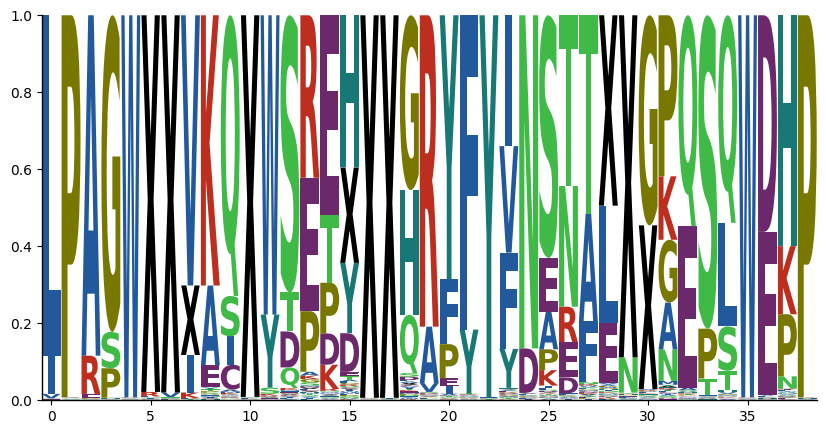

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,2000, 1, logdir=logdir, out_modelname=outmodel_name, beta=16 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-9,12])#[-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1500, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=16.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10


Epoch 1/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1500: 100%|██████████| 10/10 [00:01<00:00,  7.41samples/s]

Epoch 1/1500: 100%|██████████| 10/10 [00:01<00:00,  7.41samples/s, loss=1159.5087890625]

Epoch 1/1500: 100%|██████████| 10/10 [00:01<00:00,  6.24samples/s, loss=1159.5087890625]

Epoch 2/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 2/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1151.605224609375]

Epoch 2/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=1151.605224609375]

Epoch 3/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 3/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 3/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1149.3101806640625]

Epoch 3/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=1149.3101806640625]

Epoch 4/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 4/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 4/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1150.1229248046875]

Epoch 4/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=1150.1229248046875]

Epoch 5/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 5/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 5/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1142.619384765625]

Epoch 5/1500: 100%|██████████| 10/10 [00:01<00:00,  9.29samples/s, loss=1142.619384765625]

Epoch 6/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 6/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 6/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=1103.402587890625]

Epoch 6/1500: 100%|██████████| 10/10 [00:01<00:00,  9.30samples/s, loss=1103.402587890625]

Epoch 7/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 7/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 7/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=1103.3990478515625]

Epoch 7/1500: 100%|██████████| 10/10 [00:01<00:00,  8.85samples/s, loss=1103.3990478515625]

Epoch 8/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 8/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s]

Epoch 8/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=1115.9520263671875]

Epoch 8/1500: 100%|██████████| 10/10 [00:01<00:00,  8.84samples/s, loss=1115.9520263671875]

Epoch 9/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 9/1500: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s]

Epoch 9/1500: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=1120.5618896484375]

Epoch 9/1500: 100%|██████████| 10/10 [00:01<00:00,  9.12samples/s, loss=1120.5618896484375]

Epoch 10/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 10/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s]

Epoch 10/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=1114.1341552734375]

Epoch 10/1500: 100%|██████████| 10/10 [00:01<00:00,  9.04samples/s, loss=1114.1341552734375]

Epoch 11/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 11/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 11/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=1110.21923828125]

Epoch 11/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=1110.21923828125]

Epoch 12/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 12/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 12/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=1076.3240966796875]

Epoch 12/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=1076.3240966796875]

Epoch 13/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 13/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 13/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=1087.4515380859375]

Epoch 13/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=1087.4515380859375]

Epoch 14/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 14/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 14/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=1108.330322265625]

Epoch 14/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=1108.330322265625]

Epoch 15/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 15/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 15/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=1106.5816650390625]

Epoch 15/1500: 100%|██████████| 10/10 [00:01<00:00,  9.37samples/s, loss=1106.5816650390625]

Epoch 16/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 16/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 16/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=1116.1612548828125]

Epoch 16/1500: 100%|██████████| 10/10 [00:01<00:00,  9.26samples/s, loss=1116.1612548828125]

Epoch 17/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 17/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 17/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=1116.435302734375]

Epoch 17/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=1116.435302734375]

Epoch 18/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 18/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 18/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=1111.147216796875]

Epoch 18/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s, loss=1111.147216796875]

Epoch 19/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 19/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s]

Epoch 19/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1082.2237548828125]

Epoch 19/1500: 100%|██████████| 10/10 [00:01<00:00,  8.93samples/s, loss=1082.2237548828125]

Epoch 20/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 20/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s]

Epoch 20/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s, loss=1078.5552978515625]

Epoch 20/1500: 100%|██████████| 10/10 [00:01<00:00,  7.85samples/s, loss=1078.5552978515625]

Epoch 21/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 21/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 21/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1082.426025390625]

Epoch 21/1500: 100%|██████████| 10/10 [00:01<00:00,  9.72samples/s, loss=1082.426025390625]

Epoch 22/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 22/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 22/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1080.4962158203125]

Epoch 22/1500: 100%|██████████| 10/10 [00:01<00:00,  9.72samples/s, loss=1080.4962158203125]

Epoch 23/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 23/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 23/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1090.48388671875]

Epoch 23/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=1090.48388671875]

Epoch 24/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 24/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 24/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1093.866943359375]

Epoch 24/1500: 100%|██████████| 10/10 [00:01<00:00,  9.28samples/s, loss=1093.866943359375]

Epoch 25/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 25/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s]

Epoch 25/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=1096.8687744140625]

Epoch 25/1500: 100%|██████████| 10/10 [00:01<00:00,  8.65samples/s, loss=1096.8687744140625]

Epoch 26/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 26/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 26/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=1084.647705078125]

Epoch 26/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=1084.647705078125]

Epoch 27/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 27/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 27/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=1072.1353759765625]

Epoch 27/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=1072.1353759765625]

Epoch 28/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 28/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s]

Epoch 28/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=1093.98779296875]

Epoch 28/1500: 100%|██████████| 10/10 [00:01<00:00,  9.30samples/s, loss=1093.98779296875]

Epoch 29/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 29/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s]

Epoch 29/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1079.9921875]

Epoch 29/1500: 100%|██████████| 10/10 [00:01<00:00,  8.80samples/s, loss=1079.9921875]

Epoch 30/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 30/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s]

Epoch 30/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1084.166748046875]

Epoch 30/1500: 100%|██████████| 10/10 [00:01<00:00,  9.06samples/s, loss=1084.166748046875]

Epoch 31/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 31/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 31/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1096.1285400390625]

Epoch 31/1500: 100%|██████████| 10/10 [00:01<00:00,  8.76samples/s, loss=1096.1285400390625]

Epoch 32/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 32/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s]

Epoch 32/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=1056.2008056640625]

Epoch 32/1500: 100%|██████████| 10/10 [00:01<00:00,  9.09samples/s, loss=1056.2008056640625]

Epoch 33/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 33/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s]

Epoch 33/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=1071.329345703125]

Epoch 33/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s, loss=1071.329345703125]

Epoch 34/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 34/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 34/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=1070.735595703125]

Epoch 34/1500: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=1070.735595703125]

Epoch 35/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 35/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 35/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=1080.663330078125]

Epoch 35/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=1080.663330078125]

Epoch 36/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 36/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 36/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=1060.687255859375]

Epoch 36/1500: 100%|██████████| 10/10 [00:01<00:00,  9.43samples/s, loss=1060.687255859375]

Epoch 37/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 37/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 37/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=1106.1588134765625]

Epoch 37/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=1106.1588134765625]

Epoch 38/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 38/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s]

Epoch 38/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1084.4971923828125]

Epoch 38/1500: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=1084.4971923828125]

Epoch 39/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 39/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s]

Epoch 39/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=1090.6553955078125]

Epoch 39/1500: 100%|██████████| 10/10 [00:01<00:00,  7.94samples/s, loss=1090.6553955078125]

Epoch 40/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 40/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 40/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1072.5106201171875]

Epoch 40/1500: 100%|██████████| 10/10 [00:01<00:00,  9.29samples/s, loss=1072.5106201171875]

Epoch 41/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 41/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 41/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=1072.7210693359375]

Epoch 41/1500: 100%|██████████| 10/10 [00:01<00:00,  8.54samples/s, loss=1072.7210693359375]

Epoch 42/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 42/1500: 100%|██████████| 10/10 [00:00<00:00, 11.00samples/s]

Epoch 42/1500: 100%|██████████| 10/10 [00:00<00:00, 11.00samples/s, loss=1088.7215576171875]

Epoch 42/1500: 100%|██████████| 10/10 [00:01<00:00,  9.39samples/s, loss=1088.7215576171875]

Epoch 43/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 43/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 43/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=1080.4962158203125]

Epoch 43/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1080.4962158203125]

Epoch 44/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 44/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 44/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1072.7398681640625]

Epoch 44/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1072.7398681640625]

Epoch 45/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 45/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 45/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=1059.792236328125]

Epoch 45/1500: 100%|██████████| 10/10 [00:01<00:00,  9.77samples/s, loss=1059.792236328125]

Epoch 46/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 46/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 46/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=1069.458251953125]

Epoch 46/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=1069.458251953125]

Epoch 47/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 47/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 47/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1042.068115234375]

Epoch 47/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=1042.068115234375]

Epoch 48/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 48/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 48/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1053.37890625]

Epoch 48/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1053.37890625]

Epoch 49/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 49/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 49/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=1060.6495361328125]

Epoch 49/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=1060.6495361328125]

Epoch 50/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 50/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 50/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1069.60498046875]

Epoch 50/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1069.60498046875]

Epoch 51/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 51/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 51/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=1061.73828125]

Epoch 51/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1061.73828125]

Epoch 52/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 52/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 52/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1036.4156494140625]

Epoch 52/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1036.4156494140625]

Epoch 53/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 53/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 53/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1070.2818603515625]

Epoch 53/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1070.2818603515625]

Epoch 54/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 54/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 54/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1069.9573974609375]

Epoch 54/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1069.9573974609375]

Epoch 55/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 55/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 55/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1068.611328125]

Epoch 55/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1068.611328125]

Epoch 56/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 56/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 56/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=1074.6796875]

Epoch 56/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1074.6796875]

Epoch 57/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 57/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 57/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=1045.2569580078125]

Epoch 57/1500: 100%|██████████| 10/10 [00:01<00:00,  9.29samples/s, loss=1045.2569580078125]

Epoch 58/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 58/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 58/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1071.093017578125]

Epoch 58/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1071.093017578125]

Epoch 59/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 59/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 59/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=1090.701904296875]

Epoch 59/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1090.701904296875]

Epoch 60/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 60/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 60/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1069.53759765625]

Epoch 60/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1069.53759765625]

Epoch 61/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 61/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 61/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=1059.8238525390625]

Epoch 61/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1059.8238525390625]

Epoch 62/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 62/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 62/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=1090.394287109375]

Epoch 62/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1090.394287109375]

Epoch 63/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 63/1500: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s]

Epoch 63/1500: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s, loss=1080.5859375]

Epoch 63/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=1080.5859375]

Epoch 64/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 64/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 64/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1070.663818359375]

Epoch 64/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=1070.663818359375]

Epoch 65/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 65/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 65/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1079.83251953125]

Epoch 65/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1079.83251953125]

Epoch 66/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 66/1500: 100%|██████████| 10/10 [00:00<00:00, 11.12samples/s]

Epoch 66/1500: 100%|██████████| 10/10 [00:00<00:00, 11.12samples/s, loss=1083.1370849609375]

Epoch 66/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=1083.1370849609375]

Epoch 67/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 67/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s]

Epoch 67/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s, loss=1085.4298095703125]

Epoch 67/1500: 100%|██████████| 10/10 [00:01<00:00,  9.79samples/s, loss=1085.4298095703125]

Epoch 68/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 68/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 68/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1083.5723876953125]

Epoch 68/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1083.5723876953125]

Epoch 69/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 69/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 69/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1063.078125]

Epoch 69/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=1063.078125]

Epoch 70/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 70/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 70/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1062.5595703125]

Epoch 70/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=1062.5595703125]

Epoch 71/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 71/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 71/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1062.162109375]

Epoch 71/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=1062.162109375]

Epoch 72/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 72/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 72/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1078.17724609375]

Epoch 72/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1078.17724609375]

Epoch 73/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 73/1500: 100%|██████████| 10/10 [00:00<00:00, 11.07samples/s]

Epoch 73/1500: 100%|██████████| 10/10 [00:00<00:00, 11.07samples/s, loss=1061.1927490234375]

Epoch 73/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=1061.1927490234375]

Epoch 74/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 74/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s]

Epoch 74/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s, loss=1037.26220703125]

Epoch 74/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1037.26220703125]

Epoch 75/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 75/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 75/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1056.2615966796875]

Epoch 75/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1056.2615966796875]

Epoch 76/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 76/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s]

Epoch 76/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s, loss=1052.853271484375]

Epoch 76/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=1052.853271484375]

Epoch 77/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 77/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 77/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=1069.169677734375]

Epoch 77/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1069.169677734375]

Epoch 78/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 78/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 78/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1084.4501953125]

Epoch 78/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=1084.4501953125]

Epoch 79/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 79/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 79/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1085.291015625]

Epoch 79/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1085.291015625]

Epoch 80/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 80/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 80/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1039.178955078125]

Epoch 80/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1039.178955078125]

Epoch 81/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 81/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s]

Epoch 81/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s, loss=1057.045166015625]

Epoch 81/1500: 100%|██████████| 10/10 [00:01<00:00,  9.82samples/s, loss=1057.045166015625]

Epoch 82/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 82/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 82/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1054.9483642578125]

Epoch 82/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1054.9483642578125]

Epoch 83/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 83/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 83/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1037.19140625]

Epoch 83/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1037.19140625]

Epoch 84/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 84/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 84/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1060.83251953125]

Epoch 84/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1060.83251953125]

Epoch 85/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 85/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 85/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1060.8504638671875]

Epoch 85/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1060.8504638671875]

Epoch 86/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 86/1500: 100%|██████████| 10/10 [00:00<00:00, 11.01samples/s]

Epoch 86/1500: 100%|██████████| 10/10 [00:00<00:00, 11.01samples/s, loss=1065.7099609375]

Epoch 86/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=1065.7099609375]

Epoch 87/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 87/1500: 100%|██████████| 10/10 [00:00<00:00, 11.07samples/s]

Epoch 87/1500: 100%|██████████| 10/10 [00:00<00:00, 11.07samples/s, loss=1066.0858154296875]

Epoch 87/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1066.0858154296875]

Epoch 88/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 88/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 88/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1078.89306640625]

Epoch 88/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1078.89306640625]

Epoch 89/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 89/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 89/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1035.4989013671875]

Epoch 89/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1035.4989013671875]

Epoch 90/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 90/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 90/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1072.994140625]

Epoch 90/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1072.994140625]

Epoch 91/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 91/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 91/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1068.80419921875]

Epoch 91/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1068.80419921875]

Epoch 92/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 92/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 92/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1057.9149169921875]

Epoch 92/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1057.9149169921875]

Epoch 93/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 93/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 93/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=1045.2769775390625]

Epoch 93/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=1045.2769775390625]

Epoch 94/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 94/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 94/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1062.0980224609375]

Epoch 94/1500: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=1062.0980224609375]

Epoch 95/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 95/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 95/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=1049.1279296875]

Epoch 95/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s, loss=1049.1279296875]

Epoch 96/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 96/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 96/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1031.6171875]

Epoch 96/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1031.6171875]

Epoch 97/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 97/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 97/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1046.3359375]

Epoch 97/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1046.3359375]

Epoch 98/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 98/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 98/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1043.1507568359375]

Epoch 98/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1043.1507568359375]

Epoch 99/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 99/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 99/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1057.577392578125]

Epoch 99/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1057.577392578125]

Epoch 100/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 100/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 100/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1026.0206298828125]

Epoch 100/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=1026.0206298828125]

Epoch 101/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 101/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 101/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1033.017333984375]

Epoch 101/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=1033.017333984375]

Epoch 102/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 102/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 102/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1016.072021484375]

Epoch 102/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1016.072021484375]

Epoch 103/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 103/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 103/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1045.2744140625]

Epoch 103/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1045.2744140625]

Epoch 104/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 104/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 104/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1035.93994140625]

Epoch 104/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1035.93994140625]

Epoch 105/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 105/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 105/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1037.3348388671875]

Epoch 105/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1037.3348388671875]

Epoch 106/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 106/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 106/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1015.8615112304688]

Epoch 106/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1015.8615112304688]

Epoch 107/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 107/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 107/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1042.8291015625]

Epoch 107/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=1042.8291015625]

Epoch 108/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 108/1500: 100%|██████████| 10/10 [00:01<00:00,  8.44samples/s]

Epoch 108/1500: 100%|██████████| 10/10 [00:01<00:00,  8.44samples/s, loss=1042.2200927734375]

Epoch 108/1500: 100%|██████████| 10/10 [00:01<00:00,  7.65samples/s, loss=1042.2200927734375]

Epoch 109/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 109/1500: 100%|██████████| 10/10 [00:00<00:00, 11.12samples/s]

Epoch 109/1500: 100%|██████████| 10/10 [00:00<00:00, 11.12samples/s, loss=1017.0822143554688]

Epoch 109/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=1017.0822143554688]

Epoch 110/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 110/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 110/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=1046.4835205078125]

Epoch 110/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=1046.4835205078125]

Epoch 111/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 111/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 111/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1035.771728515625]

Epoch 111/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1035.771728515625]

Epoch 112/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 112/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 112/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1042.6229248046875]

Epoch 112/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1042.6229248046875]

Epoch 113/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 113/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 113/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1044.47021484375]

Epoch 113/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1044.47021484375]

Epoch 114/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 114/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 114/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1046.86767578125]

Epoch 114/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=1046.86767578125]

Epoch 115/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 115/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 115/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1059.53076171875]

Epoch 115/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1059.53076171875]

Epoch 116/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 116/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 116/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1021.0909423828125]

Epoch 116/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1021.0909423828125]

Epoch 117/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 117/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s]

Epoch 117/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s, loss=1047.629150390625]

Epoch 117/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=1047.629150390625]

Epoch 118/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 118/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 118/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1040.703369140625]

Epoch 118/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1040.703369140625]

Epoch 119/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 119/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 119/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=1049.0941162109375]

Epoch 119/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=1049.0941162109375]

Epoch 120/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 120/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 120/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1028.210205078125]

Epoch 120/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=1028.210205078125]

Epoch 121/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 121/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 121/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1041.8497314453125]

Epoch 121/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1041.8497314453125]

Epoch 122/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 122/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 122/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=1056.23291015625]

Epoch 122/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=1056.23291015625]

Epoch 123/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 123/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 123/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1053.0794677734375]

Epoch 123/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1053.0794677734375]

Epoch 124/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 124/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 124/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1018.1709594726562]

Epoch 124/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1018.1709594726562]

Epoch 125/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 125/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 125/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1036.1229248046875]

Epoch 125/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1036.1229248046875]

Epoch 126/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 126/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s]

Epoch 126/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=1016.208740234375]

Epoch 126/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=1016.208740234375]

Epoch 127/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 127/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 127/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1036.9661865234375]

Epoch 127/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1036.9661865234375]

Epoch 128/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 128/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 128/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1024.880859375]

Epoch 128/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1024.880859375]

Epoch 129/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 129/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 129/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=1043.5013427734375]

Epoch 129/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1043.5013427734375]

Epoch 130/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 130/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 130/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1017.1862182617188]

Epoch 130/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1017.1862182617188]

Epoch 131/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 131/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 131/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=1043.330810546875]

Epoch 131/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=1043.330810546875]

Epoch 132/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 132/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 132/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=1017.9672241210938]

Epoch 132/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=1017.9672241210938]

Epoch 133/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 133/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 133/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1013.6744384765625]

Epoch 133/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1013.6744384765625]

Epoch 134/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 134/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 134/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1018.37548828125]

Epoch 134/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1018.37548828125]

Epoch 135/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 135/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 135/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1047.5123291015625]

Epoch 135/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1047.5123291015625]

Epoch 136/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 136/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 136/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1053.1553955078125]

Epoch 136/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=1053.1553955078125]

Epoch 137/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 137/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 137/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1041.00439453125]

Epoch 137/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1041.00439453125]

Epoch 138/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 138/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 138/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1035.4671630859375]

Epoch 138/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1035.4671630859375]

Epoch 139/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 139/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 139/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1021.033935546875]

Epoch 139/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=1021.033935546875]

Epoch 140/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 140/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 140/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1017.8046264648438]

Epoch 140/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1017.8046264648438]

Epoch 141/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 141/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 141/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1035.0775146484375]

Epoch 141/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=1035.0775146484375]

Epoch 142/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 142/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 142/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1032.31982421875]

Epoch 142/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1032.31982421875]

Epoch 143/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 143/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 143/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1030.0850830078125]

Epoch 143/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1030.0850830078125]

Epoch 144/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 144/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 144/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1004.3702392578125]

Epoch 144/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1004.3702392578125]

Epoch 145/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 145/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 145/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1023.050537109375]

Epoch 145/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1023.050537109375]

Epoch 146/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 146/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 146/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1017.4756469726562]

Epoch 146/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=1017.4756469726562]

Epoch 147/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 147/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 147/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1048.2425537109375]

Epoch 147/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1048.2425537109375]

Epoch 148/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 148/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 148/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1019.507080078125]

Epoch 148/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=1019.507080078125]

Epoch 149/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 149/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 149/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1028.4105224609375]

Epoch 149/1500: 100%|██████████| 10/10 [00:01<00:00,  9.72samples/s, loss=1028.4105224609375]

Epoch 150/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 150/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 150/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1024.96630859375]

Epoch 150/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1024.96630859375]

Epoch 151/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 151/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s]

Epoch 151/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=1030.6519775390625]

Epoch 151/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=1030.6519775390625]

Epoch 152/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 152/1500: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s]

Epoch 152/1500: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s, loss=1021.9547729492188]

Epoch 152/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=1021.9547729492188]

Epoch 153/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 153/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 153/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=1033.8123779296875]

Epoch 153/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1033.8123779296875]

Epoch 154/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 154/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 154/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1012.8952026367188]

Epoch 154/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1012.8952026367188]

Epoch 155/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 155/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 155/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1015.6126098632812]

Epoch 155/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1015.6126098632812]

Epoch 156/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 156/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 156/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1048.4451904296875]

Epoch 156/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=1048.4451904296875]

Epoch 157/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 157/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 157/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1036.194580078125]

Epoch 157/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=1036.194580078125]

Epoch 158/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 158/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 158/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1018.9926147460938]

Epoch 158/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1018.9926147460938]

Epoch 159/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 159/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 159/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1054.693359375]

Epoch 159/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1054.693359375]

Epoch 160/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 160/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 160/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1042.425537109375]

Epoch 160/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1042.425537109375]

Epoch 161/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 161/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 161/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1039.3359375]

Epoch 161/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1039.3359375]

Epoch 162/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 162/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 162/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1010.1985473632812]

Epoch 162/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1010.1985473632812]

Epoch 163/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 163/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 163/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=1061.7210693359375]

Epoch 163/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=1061.7210693359375]

Epoch 164/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 164/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 164/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1062.957275390625]

Epoch 164/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1062.957275390625]

Epoch 165/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 165/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 165/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=1057.4140625]

Epoch 165/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1057.4140625]

Epoch 166/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 166/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]

Epoch 166/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=1033.413818359375]

Epoch 166/1500: 100%|██████████| 10/10 [00:01<00:00,  9.43samples/s, loss=1033.413818359375]

Epoch 167/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 167/1500: 100%|██████████| 10/10 [00:01<00:00,  7.45samples/s]

Epoch 167/1500: 100%|██████████| 10/10 [00:01<00:00,  7.45samples/s, loss=1026.44384765625]

Epoch 167/1500: 100%|██████████| 10/10 [00:01<00:00,  6.89samples/s, loss=1026.44384765625]

Epoch 168/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 168/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 168/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1054.87939453125]

Epoch 168/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1054.87939453125]

Epoch 169/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 169/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 169/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1045.679443359375]

Epoch 169/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1045.679443359375]

Epoch 170/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 170/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 170/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1025.4598388671875]

Epoch 170/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=1025.4598388671875]

Epoch 171/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 171/1500: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s]

Epoch 171/1500: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s, loss=1041.8404541015625]

Epoch 171/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=1041.8404541015625]

Epoch 172/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 172/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 172/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1042.591552734375]

Epoch 172/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1042.591552734375]

Epoch 173/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 173/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 173/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1023.7288818359375]

Epoch 173/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=1023.7288818359375]

Epoch 174/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 174/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 174/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1024.59716796875]

Epoch 174/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1024.59716796875]

Epoch 175/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 175/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 175/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1018.3684692382812]

Epoch 175/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1018.3684692382812]

Epoch 176/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 176/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 176/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1024.3399658203125]

Epoch 176/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1024.3399658203125]

Epoch 177/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 177/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 177/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1002.607421875]

Epoch 177/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=1002.607421875]

Epoch 178/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 178/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 178/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1028.1187744140625]

Epoch 178/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1028.1187744140625]

Epoch 179/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 179/1500: 100%|██████████| 10/10 [00:00<00:00, 11.08samples/s]

Epoch 179/1500: 100%|██████████| 10/10 [00:00<00:00, 11.08samples/s, loss=1013.6568603515625]

Epoch 179/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1013.6568603515625]

Epoch 180/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 180/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 180/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1020.13720703125]

Epoch 180/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=1020.13720703125]

Epoch 181/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 181/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 181/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1025.4810791015625]

Epoch 181/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1025.4810791015625]

Epoch 182/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 182/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 182/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=1015.6692504882812]

Epoch 182/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1015.6692504882812]

Epoch 183/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 183/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 183/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1013.4812622070312]

Epoch 183/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=1013.4812622070312]

Epoch 184/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 184/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 184/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1018.185791015625]

Epoch 184/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=1018.185791015625]

Epoch 185/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 185/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 185/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=1043.6072998046875]

Epoch 185/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=1043.6072998046875]

Epoch 186/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 186/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 186/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=1030.8216552734375]

Epoch 186/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1030.8216552734375]

Epoch 187/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 187/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 187/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1019.4573974609375]

Epoch 187/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=1019.4573974609375]

Epoch 188/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 188/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 188/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=996.075927734375]

Epoch 188/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=996.075927734375]

Epoch 189/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 189/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 189/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=995.2471313476562]

Epoch 189/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=995.2471313476562]

Epoch 190/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 190/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 190/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=1024.2640380859375]

Epoch 190/1500: 100%|██████████| 10/10 [00:01<00:00,  9.93samples/s, loss=1024.2640380859375]

Epoch 191/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 191/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 191/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=995.2250366210938]

Epoch 191/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=995.2250366210938]

Epoch 192/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 192/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 192/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1037.4261474609375]

Epoch 192/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1037.4261474609375]

Epoch 193/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 193/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 193/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=1008.0894775390625]

Epoch 193/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1008.0894775390625]

Epoch 194/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 194/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 194/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=1032.8345947265625]

Epoch 194/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1032.8345947265625]

Epoch 195/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 195/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 195/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1043.615234375]

Epoch 195/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=1043.615234375]

Epoch 196/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 196/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 196/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1039.724365234375]

Epoch 196/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=1039.724365234375]

Epoch 197/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 197/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 197/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1020.2176513671875]

Epoch 197/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1020.2176513671875]

Epoch 198/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 198/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s]

Epoch 198/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s, loss=1027.326416015625]

Epoch 198/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1027.326416015625]

Epoch 199/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 199/1500: 100%|██████████| 10/10 [00:00<00:00, 10.99samples/s]

Epoch 199/1500: 100%|██████████| 10/10 [00:00<00:00, 10.99samples/s, loss=1018.729248046875]

Epoch 199/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=1018.729248046875]

Epoch 200/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 200/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 200/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1021.6118774414062]

Epoch 200/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=1021.6118774414062]

Epoch 201/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 201/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 201/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1013.075439453125]

Epoch 201/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1013.075439453125]

Epoch 202/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 202/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 202/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1019.7847900390625]

Epoch 202/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1019.7847900390625]

Epoch 203/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 203/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 203/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=1025.2503662109375]

Epoch 203/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=1025.2503662109375]

Epoch 204/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 204/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 204/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1019.2705688476562]

Epoch 204/1500: 100%|██████████| 10/10 [00:01<00:00,  9.72samples/s, loss=1019.2705688476562]

Epoch 205/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

From Here


Epoch 205/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 205/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1023.6322021484375]

Epoch 205/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1023.6322021484375]

Epoch 206/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 206/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s]

Epoch 206/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1004.9862670898438]

Epoch 206/1500: 100%|██████████| 10/10 [00:01<00:00,  9.21samples/s, loss=1004.9862670898438]

Epoch 207/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 207/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s]

Epoch 207/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=1018.420654296875]

Epoch 207/1500: 100%|██████████| 10/10 [00:01<00:00,  9.14samples/s, loss=1018.420654296875]

Epoch 208/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 208/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 208/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1037.4609375]

Epoch 208/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1037.4609375]

Epoch 209/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 209/1500: 100%|██████████| 10/10 [00:00<00:00, 11.00samples/s]

Epoch 209/1500: 100%|██████████| 10/10 [00:00<00:00, 11.00samples/s, loss=1051.9453125]

Epoch 209/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=1051.9453125]

Epoch 210/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 210/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 210/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1019.8519897460938]

Epoch 210/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1019.8519897460938]

Epoch 211/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 211/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 211/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1035.6539306640625]

Epoch 211/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1035.6539306640625]

Epoch 212/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 212/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 212/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=998.8191528320312]

Epoch 212/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=998.8191528320312]

Epoch 213/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 213/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 213/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1016.5925903320312]

Epoch 213/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=1016.5925903320312]

Epoch 214/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 214/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 214/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=1020.5961303710938]

Epoch 214/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1020.5961303710938]

Epoch 215/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 215/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 215/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1011.8445434570312]

Epoch 215/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1011.8445434570312]

Epoch 216/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 216/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s]

Epoch 216/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=1016.0570678710938]

Epoch 216/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=1016.0570678710938]

Epoch 217/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 217/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 217/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1017.4114379882812]

Epoch 217/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=1017.4114379882812]

Epoch 218/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 218/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 218/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1002.2154541015625]

Epoch 218/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1002.2154541015625]

Epoch 219/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 219/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 219/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1008.1802978515625]

Epoch 219/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1008.1802978515625]

Epoch 220/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 220/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 220/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1024.24853515625]

Epoch 220/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1024.24853515625]

Epoch 221/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 221/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 221/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=1013.3298950195312]

Epoch 221/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1013.3298950195312]

Epoch 222/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 222/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 222/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1017.997802734375]

Epoch 222/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=1017.997802734375]

Epoch 223/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 223/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 223/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1030.855224609375]

Epoch 223/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1030.855224609375]

Epoch 224/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 224/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 224/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=998.6964111328125]

Epoch 224/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=998.6964111328125]

Epoch 225/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 225/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s]

Epoch 225/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=987.5202026367188]

Epoch 225/1500: 100%|██████████| 10/10 [00:01<00:00,  9.37samples/s, loss=987.5202026367188]

Epoch 226/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 226/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 226/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=1022.95458984375]

Epoch 226/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=1022.95458984375]

Epoch 227/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 227/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 227/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1028.49267578125]

Epoch 227/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=1028.49267578125]

Epoch 228/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 228/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 228/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=1015.6466064453125]

Epoch 228/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1015.6466064453125]

Epoch 229/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 229/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 229/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=996.94580078125]

Epoch 229/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=996.94580078125]

Epoch 230/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 230/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 230/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1008.9656372070312]

Epoch 230/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=1008.9656372070312]

Epoch 231/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 231/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 231/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=996.8541259765625]

Epoch 231/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=996.8541259765625]

Epoch 232/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 232/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 232/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=994.0543212890625]

Epoch 232/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=994.0543212890625]

Epoch 233/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 233/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 233/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=1005.799072265625]

Epoch 233/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1005.799072265625]

Epoch 234/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 234/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 234/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=996.4414672851562]

Epoch 234/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=996.4414672851562]

Epoch 235/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 235/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 235/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1000.1644287109375]

Epoch 235/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1000.1644287109375]

Epoch 236/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 236/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 236/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=1022.509033203125]

Epoch 236/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=1022.509033203125]

Epoch 237/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 237/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 237/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=1014.3016357421875]

Epoch 237/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=1014.3016357421875]

Epoch 238/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 238/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 238/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=996.4567260742188]

Epoch 238/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=996.4567260742188]

Epoch 239/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 239/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 239/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=989.4302368164062]

Epoch 239/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=989.4302368164062]

Epoch 240/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 240/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 240/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=1019.0811157226562]

Epoch 240/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=1019.0811157226562]

Epoch 241/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 241/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 241/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=992.9956665039062]

Epoch 241/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=992.9956665039062]

Epoch 242/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 242/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 242/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=1000.1705322265625]

Epoch 242/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=1000.1705322265625]

Epoch 243/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 243/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s]

Epoch 243/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=982.8848876953125]

Epoch 243/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=982.8848876953125]

Epoch 244/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 244/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 244/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=1002.863525390625]

Epoch 244/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1002.863525390625]

Epoch 245/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 245/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s]

Epoch 245/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=980.0861206054688]

Epoch 245/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=980.0861206054688]

Epoch 246/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 246/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 246/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=987.8629150390625]

Epoch 246/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=987.8629150390625]

Epoch 247/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 247/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 247/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=985.3388061523438]

Epoch 247/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=985.3388061523438]

Epoch 248/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 248/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 248/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=989.0584716796875]

Epoch 248/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=989.0584716796875]

Epoch 249/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 249/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 249/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=988.5512084960938]

Epoch 249/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=988.5512084960938]

Epoch 250/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 250/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 250/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=983.9932250976562]

Epoch 250/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=983.9932250976562]

Epoch 251/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 251/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 251/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=995.380126953125]

Epoch 251/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=995.380126953125]

Epoch 252/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 252/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 252/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=998.8330688476562]

Epoch 252/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=998.8330688476562]

Epoch 253/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 253/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 253/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=992.3873901367188]

Epoch 253/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=992.3873901367188]

Epoch 254/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 254/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 254/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=995.0966186523438]

Epoch 254/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=995.0966186523438]

Epoch 255/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 255/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 255/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=989.5261840820312]

Epoch 255/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=989.5261840820312]

Epoch 256/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 256/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 256/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=979.65869140625]

Epoch 256/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=979.65869140625]

Epoch 257/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 257/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 257/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=998.4235229492188]

Epoch 257/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=998.4235229492188]

Epoch 258/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 258/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 258/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=975.3916625976562]

Epoch 258/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=975.3916625976562]

Epoch 259/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 259/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 259/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=1010.3527221679688]

Epoch 259/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=1010.3527221679688]

Epoch 260/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 260/1500: 100%|██████████| 10/10 [00:01<00:00,  9.80samples/s]

Epoch 260/1500: 100%|██████████| 10/10 [00:01<00:00,  9.80samples/s, loss=984.9801025390625]

Epoch 260/1500: 100%|██████████| 10/10 [00:01<00:00,  8.64samples/s, loss=984.9801025390625]

Epoch 261/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 261/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 261/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=990.5328979492188]

Epoch 261/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=990.5328979492188]

Epoch 262/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 262/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s]

Epoch 262/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s, loss=997.3136596679688]

Epoch 262/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=997.3136596679688]

Epoch 263/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 263/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 263/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=991.1300048828125]

Epoch 263/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=991.1300048828125]

Epoch 264/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 264/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 264/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=997.1914672851562]

Epoch 264/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=997.1914672851562]

Epoch 265/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 265/1500: 100%|██████████| 10/10 [00:01<00:00,  8.79samples/s]

Epoch 265/1500: 100%|██████████| 10/10 [00:01<00:00,  8.79samples/s, loss=1000.1218872070312]

Epoch 265/1500: 100%|██████████| 10/10 [00:01<00:00,  7.85samples/s, loss=1000.1218872070312]

Epoch 266/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 266/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 266/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=998.802490234375]

Epoch 266/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=998.802490234375]

Epoch 267/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 267/1500: 100%|██████████| 10/10 [00:01<00:00,  9.31samples/s]

Epoch 267/1500: 100%|██████████| 10/10 [00:01<00:00,  9.31samples/s, loss=996.3136596679688]

Epoch 267/1500: 100%|██████████| 10/10 [00:01<00:00,  8.46samples/s, loss=996.3136596679688]

Epoch 268/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 268/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s]

Epoch 268/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s, loss=993.8057861328125]

Epoch 268/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=993.8057861328125]

Epoch 269/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 269/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 269/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=976.5294799804688]

Epoch 269/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=976.5294799804688]

Epoch 270/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 270/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 270/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=997.9490966796875]

Epoch 270/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=997.9490966796875]

Epoch 271/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 271/1500: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s]

Epoch 271/1500: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s, loss=1011.0361328125]

Epoch 271/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=1011.0361328125]

Epoch 272/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 272/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 272/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=985.7703857421875]

Epoch 272/1500: 100%|██████████| 10/10 [00:01<00:00,  8.91samples/s, loss=985.7703857421875]

Epoch 273/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 273/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 273/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=1029.442138671875]

Epoch 273/1500: 100%|██████████| 10/10 [00:01<00:00,  9.07samples/s, loss=1029.442138671875]

Epoch 274/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 274/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s]

Epoch 274/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=997.9602661132812]

Epoch 274/1500: 100%|██████████| 10/10 [00:01<00:00,  8.32samples/s, loss=997.9602661132812]

Epoch 275/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 275/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 275/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=991.5011596679688]

Epoch 275/1500: 100%|██████████| 10/10 [00:01<00:00,  8.74samples/s, loss=991.5011596679688]

Epoch 276/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 276/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 276/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1003.5379638671875]

Epoch 276/1500: 100%|██████████| 10/10 [00:01<00:00,  8.97samples/s, loss=1003.5379638671875]

Epoch 277/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 277/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s]

Epoch 277/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=1009.8779296875]

Epoch 277/1500: 100%|██████████| 10/10 [00:01<00:00,  8.99samples/s, loss=1009.8779296875]

Epoch 278/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 278/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 278/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=992.8729248046875]

Epoch 278/1500: 100%|██████████| 10/10 [00:01<00:00,  8.97samples/s, loss=992.8729248046875]

Epoch 279/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 279/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 279/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=994.6544799804688]

Epoch 279/1500: 100%|██████████| 10/10 [00:01<00:00,  8.99samples/s, loss=994.6544799804688]

Epoch 280/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 280/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s]

Epoch 280/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=1004.9039306640625]

Epoch 280/1500: 100%|██████████| 10/10 [00:01<00:00,  8.61samples/s, loss=1004.9039306640625]

Epoch 281/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 281/1500: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s]

Epoch 281/1500: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=997.9791870117188]

Epoch 281/1500: 100%|██████████| 10/10 [00:01<00:00,  8.45samples/s, loss=997.9791870117188]

Epoch 282/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 282/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s]

Epoch 282/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=992.9188842773438]

Epoch 282/1500: 100%|██████████| 10/10 [00:01<00:00,  8.72samples/s, loss=992.9188842773438]

Epoch 283/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 283/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 283/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=1004.2777099609375]

Epoch 283/1500: 100%|██████████| 10/10 [00:01<00:00,  9.18samples/s, loss=1004.2777099609375]

Epoch 284/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 284/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 284/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=977.41943359375]

Epoch 284/1500: 100%|██████████| 10/10 [00:01<00:00,  9.20samples/s, loss=977.41943359375]

Epoch 285/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 285/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 285/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=989.9259643554688]

Epoch 285/1500: 100%|██████████| 10/10 [00:01<00:00,  9.12samples/s, loss=989.9259643554688]

Epoch 286/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 286/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s]

Epoch 286/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=987.2047729492188]

Epoch 286/1500: 100%|██████████| 10/10 [00:01<00:00,  8.43samples/s, loss=987.2047729492188]

Epoch 287/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 287/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s]

Epoch 287/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s, loss=982.5335083007812]

Epoch 287/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=982.5335083007812]

Epoch 288/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 288/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 288/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=991.94384765625]

Epoch 288/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=991.94384765625]

Epoch 289/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 289/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 289/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=1005.4445190429688]

Epoch 289/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=1005.4445190429688]

Epoch 290/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 290/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 290/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=992.6017456054688]

Epoch 290/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=992.6017456054688]

Epoch 291/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 291/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 291/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=1009.139404296875]

Epoch 291/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=1009.139404296875]

Epoch 292/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 292/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 292/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=1012.6607055664062]

Epoch 292/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=1012.6607055664062]

Epoch 293/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 293/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s]

Epoch 293/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=996.4933471679688]

Epoch 293/1500: 100%|██████████| 10/10 [00:01<00:00,  9.22samples/s, loss=996.4933471679688]

Epoch 294/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 294/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s]

Epoch 294/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=986.8239135742188]

Epoch 294/1500: 100%|██████████| 10/10 [00:01<00:00,  9.72samples/s, loss=986.8239135742188]

Epoch 295/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 295/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 295/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=1013.0759887695312]

Epoch 295/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=1013.0759887695312]

Epoch 296/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 296/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 296/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=1019.1738891601562]

Epoch 296/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=1019.1738891601562]

Epoch 297/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 297/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 297/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=990.18505859375]

Epoch 297/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=990.18505859375]

Epoch 298/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 298/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 298/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=990.7037353515625]

Epoch 298/1500: 100%|██████████| 10/10 [00:01<00:00,  9.31samples/s, loss=990.7037353515625]

Epoch 299/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 299/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s]

Epoch 299/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=992.2874755859375]

Epoch 299/1500: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=992.2874755859375]

Epoch 300/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 300/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 300/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=1001.0787353515625]

Epoch 300/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=1001.0787353515625]

Epoch 301/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 301/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 301/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=1005.894287109375]

Epoch 301/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=1005.894287109375]

Epoch 302/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 302/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 302/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=982.4761352539062]

Epoch 302/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=982.4761352539062]

Epoch 303/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 303/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 303/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=986.8070068359375]

Epoch 303/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=986.8070068359375]

Epoch 304/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 304/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 304/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=999.2908935546875]

Epoch 304/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=999.2908935546875]

Epoch 305/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 305/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 305/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=974.5838012695312]

Epoch 305/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=974.5838012695312]

Epoch 306/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 306/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 306/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=982.5842895507812]

Epoch 306/1500: 100%|██████████| 10/10 [00:01<00:00,  9.19samples/s, loss=982.5842895507812]

Epoch 307/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 307/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 307/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=1006.7269897460938]

Epoch 307/1500: 100%|██████████| 10/10 [00:01<00:00,  9.32samples/s, loss=1006.7269897460938]

Epoch 308/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 308/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 308/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=989.9981689453125]

Epoch 308/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=989.9981689453125]

Epoch 309/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 309/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 309/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=984.8448486328125]

Epoch 309/1500: 100%|██████████| 10/10 [00:01<00:00,  9.29samples/s, loss=984.8448486328125]

Epoch 310/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 310/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 310/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=1008.195556640625]

Epoch 310/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s, loss=1008.195556640625]

Epoch 311/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 311/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 311/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=988.9757080078125]

Epoch 311/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=988.9757080078125]

Epoch 312/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 312/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 312/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=985.3532104492188]

Epoch 312/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=985.3532104492188]

Epoch 313/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 313/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s]

Epoch 313/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s, loss=997.3768310546875]

Epoch 313/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=997.3768310546875]

Epoch 314/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 314/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 314/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=983.0521850585938]

Epoch 314/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=983.0521850585938]

Epoch 315/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 315/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s]

Epoch 315/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=978.5216064453125]

Epoch 315/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=978.5216064453125]

Epoch 316/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 316/1500: 100%|██████████| 10/10 [00:00<00:00, 10.98samples/s]

Epoch 316/1500: 100%|██████████| 10/10 [00:00<00:00, 10.98samples/s, loss=979.226806640625]

Epoch 316/1500: 100%|██████████| 10/10 [00:01<00:00,  9.31samples/s, loss=979.226806640625]

Epoch 317/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 317/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 317/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=976.36474609375]

Epoch 317/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=976.36474609375]

Epoch 318/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 318/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 318/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=975.2074584960938]

Epoch 318/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=975.2074584960938]

Epoch 319/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 319/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s]

Epoch 319/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=977.079833984375]

Epoch 319/1500: 100%|██████████| 10/10 [00:01<00:00,  8.88samples/s, loss=977.079833984375]

Epoch 320/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 320/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 320/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=981.8969116210938]

Epoch 320/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=981.8969116210938]

Epoch 321/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 321/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 321/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=968.7251586914062]

Epoch 321/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=968.7251586914062]

Epoch 322/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 322/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s]

Epoch 322/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s, loss=970.8429565429688]

Epoch 322/1500: 100%|██████████| 10/10 [00:01<00:00,  9.37samples/s, loss=970.8429565429688]

Epoch 323/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 323/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 323/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=967.5158081054688]

Epoch 323/1500: 100%|██████████| 10/10 [00:01<00:00,  9.37samples/s, loss=967.5158081054688]

Epoch 324/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 324/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 324/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=984.3577880859375]

Epoch 324/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=984.3577880859375]

Epoch 325/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 325/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 325/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=980.7818603515625]

Epoch 325/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=980.7818603515625]

Epoch 326/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 326/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 326/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=970.3956298828125]

Epoch 326/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=970.3956298828125]

Epoch 327/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 327/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 327/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=982.0236206054688]

Epoch 327/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=982.0236206054688]

Epoch 328/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 328/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 328/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=985.25634765625]

Epoch 328/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=985.25634765625]

Epoch 329/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 329/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 329/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=982.0457763671875]

Epoch 329/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=982.0457763671875]

Epoch 330/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 330/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 330/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=968.942138671875]

Epoch 330/1500: 100%|██████████| 10/10 [00:01<00:00,  9.12samples/s, loss=968.942138671875]

Epoch 331/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 331/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s]

Epoch 331/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=969.7509765625]

Epoch 331/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=969.7509765625]

Epoch 332/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 332/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 332/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=966.7711791992188]

Epoch 332/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=966.7711791992188]

Epoch 333/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 333/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 333/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=966.9784545898438]

Epoch 333/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=966.9784545898438]

Epoch 334/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 334/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 334/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=974.6565551757812]

Epoch 334/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=974.6565551757812]

Epoch 335/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 335/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s]

Epoch 335/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=967.7836303710938]

Epoch 335/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=967.7836303710938]

Epoch 336/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 336/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 336/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=965.3948364257812]

Epoch 336/1500: 100%|██████████| 10/10 [00:01<00:00,  9.33samples/s, loss=965.3948364257812]

Epoch 337/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 337/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 337/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=981.6153564453125]

Epoch 337/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=981.6153564453125]

Epoch 338/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 338/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 338/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=968.0423583984375]

Epoch 338/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=968.0423583984375]

Epoch 339/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 339/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 339/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=982.0950317382812]

Epoch 339/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=982.0950317382812]

Epoch 340/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 340/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 340/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=969.2102661132812]

Epoch 340/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s, loss=969.2102661132812]

Epoch 341/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 341/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s]

Epoch 341/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=992.2012939453125]

Epoch 341/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=992.2012939453125]

Epoch 342/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 342/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s]

Epoch 342/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=976.6651611328125]

Epoch 342/1500: 100%|██████████| 10/10 [00:01<00:00,  9.34samples/s, loss=976.6651611328125]

Epoch 343/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 343/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 343/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=963.104736328125]

Epoch 343/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=963.104736328125]

Epoch 344/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 344/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 344/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=977.5863647460938]

Epoch 344/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=977.5863647460938]

Epoch 345/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 345/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s]

Epoch 345/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s, loss=972.6530151367188]

Epoch 345/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=972.6530151367188]

Epoch 346/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 346/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 346/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=970.4942016601562]

Epoch 346/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=970.4942016601562]

Epoch 347/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 347/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 347/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=966.4957275390625]

Epoch 347/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=966.4957275390625]

Epoch 348/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 348/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 348/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=982.633544921875]

Epoch 348/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=982.633544921875]

Epoch 349/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 349/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s]

Epoch 349/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=981.5697631835938]

Epoch 349/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=981.5697631835938]

Epoch 350/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 350/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 350/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=964.925537109375]

Epoch 350/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=964.925537109375]

Epoch 351/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 351/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 351/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=976.8088989257812]

Epoch 351/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=976.8088989257812]

Epoch 352/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 352/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 352/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=964.2642822265625]

Epoch 352/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=964.2642822265625]

Epoch 353/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 353/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 353/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=965.26220703125]

Epoch 353/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=965.26220703125]

Epoch 354/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 354/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 354/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=972.764892578125]

Epoch 354/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=972.764892578125]

Epoch 355/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 355/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 355/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=971.8325805664062]

Epoch 355/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=971.8325805664062]

Epoch 356/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 356/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s]

Epoch 356/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=963.5698852539062]

Epoch 356/1500: 100%|██████████| 10/10 [00:01<00:00,  9.14samples/s, loss=963.5698852539062]

Epoch 357/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 357/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 357/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=963.6195068359375]

Epoch 357/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=963.6195068359375]

Epoch 358/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 358/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 358/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=962.2653198242188]

Epoch 358/1500: 100%|██████████| 10/10 [00:01<00:00,  9.72samples/s, loss=962.2653198242188]

Epoch 359/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 359/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 359/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=967.5288696289062]

Epoch 359/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=967.5288696289062]

Epoch 360/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 360/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 360/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=964.72216796875]

Epoch 360/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=964.72216796875]

Epoch 361/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 361/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 361/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=961.1795654296875]

Epoch 361/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=961.1795654296875]

Epoch 362/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 362/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 362/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=962.2850341796875]

Epoch 362/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=962.2850341796875]

Epoch 363/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 363/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 363/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=955.7727661132812]

Epoch 363/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=955.7727661132812]

Epoch 364/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 364/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 364/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=975.4021606445312]

Epoch 364/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=975.4021606445312]

Epoch 365/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 365/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 365/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=964.8091430664062]

Epoch 365/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=964.8091430664062]

Epoch 366/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 366/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 366/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=973.3692016601562]

Epoch 366/1500: 100%|██████████| 10/10 [00:01<00:00,  9.39samples/s, loss=973.3692016601562]

Epoch 367/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 367/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 367/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=959.4453125]

Epoch 367/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=959.4453125]

Epoch 368/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 368/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s]

Epoch 368/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=959.14599609375]

Epoch 368/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=959.14599609375]

Epoch 369/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 369/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s]

Epoch 369/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s, loss=956.4659423828125]

Epoch 369/1500: 100%|██████████| 10/10 [00:01<00:00,  8.32samples/s, loss=956.4659423828125]

Epoch 370/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 370/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 370/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=963.7603759765625]

Epoch 370/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=963.7603759765625]

Epoch 371/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 371/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 371/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=976.9442138671875]

Epoch 371/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=976.9442138671875]

Epoch 372/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 372/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 372/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=954.100341796875]

Epoch 372/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=954.100341796875]

Epoch 373/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 373/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 373/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=971.61572265625]

Epoch 373/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=971.61572265625]

Epoch 374/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 374/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 374/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=958.7000732421875]

Epoch 374/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=958.7000732421875]

Epoch 375/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 375/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 375/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=960.0093994140625]

Epoch 375/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=960.0093994140625]

Epoch 376/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 376/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 376/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=955.113525390625]

Epoch 376/1500: 100%|██████████| 10/10 [00:01<00:00,  9.19samples/s, loss=955.113525390625]

Epoch 377/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 377/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 377/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=966.4490356445312]

Epoch 377/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=966.4490356445312]

Epoch 378/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 378/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 378/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=976.8848266601562]

Epoch 378/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=976.8848266601562]

Epoch 379/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 379/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 379/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=961.2210083007812]

Epoch 379/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=961.2210083007812]

Epoch 380/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 380/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s]

Epoch 380/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s, loss=979.5709838867188]

Epoch 380/1500: 100%|██████████| 10/10 [00:01<00:00,  9.77samples/s, loss=979.5709838867188]

Epoch 381/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 381/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s]

Epoch 381/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=965.4830932617188]

Epoch 381/1500: 100%|██████████| 10/10 [00:01<00:00,  8.94samples/s, loss=965.4830932617188]

Epoch 382/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 382/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 382/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=957.3551025390625]

Epoch 382/1500: 100%|██████████| 10/10 [00:01<00:00,  9.20samples/s, loss=957.3551025390625]

Epoch 383/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 383/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 383/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=957.7169189453125]

Epoch 383/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=957.7169189453125]

Epoch 384/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 384/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 384/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=962.0374145507812]

Epoch 384/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=962.0374145507812]

Epoch 385/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 385/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 385/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=965.7818603515625]

Epoch 385/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=965.7818603515625]

Epoch 386/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 386/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 386/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=962.6036987304688]

Epoch 386/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=962.6036987304688]

Epoch 387/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 387/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 387/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=955.765869140625]

Epoch 387/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=955.765869140625]

Epoch 388/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 388/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 388/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=967.895263671875]

Epoch 388/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=967.895263671875]

Epoch 389/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 389/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 389/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=965.8909301757812]

Epoch 389/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=965.8909301757812]

Epoch 390/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 390/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 390/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=963.4227294921875]

Epoch 390/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=963.4227294921875]

Epoch 391/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 391/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 391/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=959.1620483398438]

Epoch 391/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=959.1620483398438]

Epoch 392/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 392/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 392/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=976.8145141601562]

Epoch 392/1500: 100%|██████████| 10/10 [00:01<00:00,  9.16samples/s, loss=976.8145141601562]

Epoch 393/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 393/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 393/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=960.6070556640625]

Epoch 393/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=960.6070556640625]

Epoch 394/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 394/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 394/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=967.0828247070312]

Epoch 394/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=967.0828247070312]

Epoch 395/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 395/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 395/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=959.0529174804688]

Epoch 395/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=959.0529174804688]

Epoch 396/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 396/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 396/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=966.5989379882812]

Epoch 396/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=966.5989379882812]

Epoch 397/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 397/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 397/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=959.01171875]

Epoch 397/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=959.01171875]

Epoch 398/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 398/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 398/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=959.4512939453125]

Epoch 398/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=959.4512939453125]

Epoch 399/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 399/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 399/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=956.3922119140625]

Epoch 399/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=956.3922119140625]

Epoch 400/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 400/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 400/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=961.0091552734375]

Epoch 400/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=961.0091552734375]

Epoch 401/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 401/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 401/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=964.6759033203125]

Epoch 401/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=964.6759033203125]

Epoch 402/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 402/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 402/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=959.3626098632812]

Epoch 402/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=959.3626098632812]

Epoch 403/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 403/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 403/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=955.0169067382812]

Epoch 403/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=955.0169067382812]

Epoch 404/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 404/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s]

Epoch 404/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s, loss=956.9093017578125]

Epoch 404/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=956.9093017578125]

Epoch 405/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 405/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 405/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=959.8551025390625]

Epoch 405/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=959.8551025390625]

Epoch 406/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 406/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 406/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=962.5326538085938]

Epoch 406/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=962.5326538085938]

Epoch 407/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 407/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 407/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=957.1973266601562]

Epoch 407/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=957.1973266601562]

Epoch 408/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 408/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s]

Epoch 408/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s, loss=961.6475830078125]

Epoch 408/1500: 100%|██████████| 10/10 [00:01<00:00,  9.77samples/s, loss=961.6475830078125]

Epoch 409/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 409/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 409/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=954.93505859375]

Epoch 409/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=954.93505859375]

Epoch 410/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 410/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 410/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=966.1203002929688]

Epoch 410/1500: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=966.1203002929688]

Epoch 411/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 411/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 411/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=952.8133544921875]

Epoch 411/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=952.8133544921875]

Epoch 412/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 412/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 412/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=963.8867797851562]

Epoch 412/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=963.8867797851562]

Epoch 413/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 413/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 413/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=954.7933959960938]

Epoch 413/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=954.7933959960938]

Epoch 414/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 414/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s]

Epoch 414/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s, loss=975.17578125]

Epoch 414/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=975.17578125]

Epoch 415/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 415/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 415/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=957.3262329101562]

Epoch 415/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=957.3262329101562]

Epoch 416/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 416/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 416/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=960.4995727539062]

Epoch 416/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=960.4995727539062]

Epoch 417/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 417/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s]

Epoch 417/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=962.1495971679688]

Epoch 417/1500: 100%|██████████| 10/10 [00:01<00:00,  9.18samples/s, loss=962.1495971679688]

Epoch 418/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 418/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s]

Epoch 418/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=954.5577392578125]

Epoch 418/1500: 100%|██████████| 10/10 [00:01<00:00,  9.08samples/s, loss=954.5577392578125]

Epoch 419/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 419/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 419/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=961.4535522460938]

Epoch 419/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=961.4535522460938]

Epoch 420/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 420/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 420/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=954.2716674804688]

Epoch 420/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=954.2716674804688]

Epoch 421/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 421/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 421/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=954.1307373046875]

Epoch 421/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=954.1307373046875]

Epoch 422/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 422/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 422/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=950.1321411132812]

Epoch 422/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=950.1321411132812]

Epoch 423/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 423/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 423/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=963.374755859375]

Epoch 423/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=963.374755859375]

Epoch 424/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 424/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 424/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=956.9046630859375]

Epoch 424/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=956.9046630859375]

Epoch 425/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 425/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 425/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=950.720703125]

Epoch 425/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=950.720703125]

Epoch 426/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 426/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 426/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=953.1277465820312]

Epoch 426/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=953.1277465820312]

Epoch 427/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 427/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 427/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=953.25390625]

Epoch 427/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=953.25390625]

Epoch 428/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 428/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 428/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=953.9243774414062]

Epoch 428/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=953.9243774414062]

Epoch 429/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 429/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]

Epoch 429/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=952.2005615234375]

Epoch 429/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=952.2005615234375]

Epoch 430/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 430/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 430/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=954.3768310546875]

Epoch 430/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=954.3768310546875]

Epoch 431/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 431/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s]

Epoch 431/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s, loss=953.4859008789062]

Epoch 431/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=953.4859008789062]

Epoch 432/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 432/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 432/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=970.5963745117188]

Epoch 432/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=970.5963745117188]

Epoch 433/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 433/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 433/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=956.3775024414062]

Epoch 433/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=956.3775024414062]

Epoch 434/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 434/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 434/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=958.32373046875]

Epoch 434/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=958.32373046875]

Epoch 435/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 435/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 435/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=953.5131225585938]

Epoch 435/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=953.5131225585938]

Epoch 436/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 436/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s]

Epoch 436/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=954.4730224609375]

Epoch 436/1500: 100%|██████████| 10/10 [00:01<00:00,  9.05samples/s, loss=954.4730224609375]

Epoch 437/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 437/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 437/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=951.5671997070312]

Epoch 437/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=951.5671997070312]

Epoch 438/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 438/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 438/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=951.8058471679688]

Epoch 438/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=951.8058471679688]

Epoch 439/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 439/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 439/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=955.3843994140625]

Epoch 439/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=955.3843994140625]

Epoch 440/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 440/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 440/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=950.7852783203125]

Epoch 440/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=950.7852783203125]

Epoch 441/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 441/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 441/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=955.6932373046875]

Epoch 441/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=955.6932373046875]

Epoch 442/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 442/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 442/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=955.353271484375]

Epoch 442/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=955.353271484375]

Epoch 443/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 443/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 443/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=956.9402465820312]

Epoch 443/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=956.9402465820312]

Epoch 444/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 444/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 444/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=952.0354614257812]

Epoch 444/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=952.0354614257812]

Epoch 445/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 445/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 445/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=951.660400390625]

Epoch 445/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=951.660400390625]

Epoch 446/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 446/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 446/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=950.50634765625]

Epoch 446/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=950.50634765625]

Epoch 447/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 447/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s]

Epoch 447/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=950.0695190429688]

Epoch 447/1500: 100%|██████████| 10/10 [00:01<00:00,  9.04samples/s, loss=950.0695190429688]

Epoch 448/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 448/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 448/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=949.7972412109375]

Epoch 448/1500: 100%|██████████| 10/10 [00:01<00:00,  8.81samples/s, loss=949.7972412109375]

Epoch 449/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 449/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s]

Epoch 449/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s, loss=952.6632690429688]

Epoch 449/1500: 100%|██████████| 10/10 [00:01<00:00,  9.26samples/s, loss=952.6632690429688]

Epoch 450/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 450/1500: 100%|██████████| 10/10 [00:00<00:00, 10.98samples/s]

Epoch 450/1500: 100%|██████████| 10/10 [00:00<00:00, 10.98samples/s, loss=952.205322265625]

Epoch 450/1500: 100%|██████████| 10/10 [00:01<00:00,  9.26samples/s, loss=952.205322265625]

Epoch 451/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 451/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 451/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=949.3986206054688]

Epoch 451/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=949.3986206054688]

Epoch 452/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 452/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 452/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=946.9773559570312]

Epoch 452/1500: 100%|██████████| 10/10 [00:01<00:00,  9.13samples/s, loss=946.9773559570312]

Epoch 453/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 453/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 453/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=956.1157836914062]

Epoch 453/1500: 100%|██████████| 10/10 [00:01<00:00,  9.02samples/s, loss=956.1157836914062]

Epoch 454/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 454/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 454/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=951.4240112304688]

Epoch 454/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=951.4240112304688]

Epoch 455/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 455/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 455/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=956.4443969726562]

Epoch 455/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=956.4443969726562]

Epoch 456/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 456/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 456/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=980.1006469726562]

Epoch 456/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=980.1006469726562]

Epoch 457/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 457/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s]

Epoch 457/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=947.0586547851562]

Epoch 457/1500: 100%|██████████| 10/10 [00:01<00:00,  8.65samples/s, loss=947.0586547851562]

Epoch 458/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 458/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 458/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=966.4097900390625]

Epoch 458/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=966.4097900390625]

Epoch 459/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 459/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 459/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=957.7628784179688]

Epoch 459/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=957.7628784179688]

Epoch 460/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 460/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s]

Epoch 460/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=951.9532470703125]

Epoch 460/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=951.9532470703125]

Epoch 461/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 461/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s]

Epoch 461/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=946.834228515625]

Epoch 461/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s, loss=946.834228515625]

Epoch 462/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 462/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 462/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=960.333984375]

Epoch 462/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=960.333984375]

Epoch 463/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 463/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 463/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=955.4486694335938]

Epoch 463/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=955.4486694335938]

Epoch 464/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 464/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 464/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=947.0758666992188]

Epoch 464/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=947.0758666992188]

Epoch 465/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 465/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 465/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=952.9825439453125]

Epoch 465/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=952.9825439453125]

Epoch 466/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 466/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 466/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=955.4580688476562]

Epoch 466/1500: 100%|██████████| 10/10 [00:01<00:00,  9.13samples/s, loss=955.4580688476562]

Epoch 467/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 467/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 467/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=951.7913208007812]

Epoch 467/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=951.7913208007812]

Epoch 468/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 468/1500: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s]

Epoch 468/1500: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=962.7516479492188]

Epoch 468/1500: 100%|██████████| 10/10 [00:01<00:00,  9.28samples/s, loss=962.7516479492188]

Epoch 469/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 469/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s]

Epoch 469/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=958.65185546875]

Epoch 469/1500: 100%|██████████| 10/10 [00:01<00:00,  8.77samples/s, loss=958.65185546875]

Epoch 470/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 470/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s]

Epoch 470/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=947.8673706054688]

Epoch 470/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=947.8673706054688]

Epoch 471/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 471/1500: 100%|██████████| 10/10 [00:01<00:00,  6.82samples/s]

Epoch 471/1500: 100%|██████████| 10/10 [00:01<00:00,  6.82samples/s, loss=961.6857299804688]

Epoch 471/1500: 100%|██████████| 10/10 [00:01<00:00,  6.08samples/s, loss=961.6857299804688]

Epoch 472/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 472/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 472/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=950.6976318359375]

Epoch 472/1500: 100%|██████████| 10/10 [00:01<00:00,  9.43samples/s, loss=950.6976318359375]

Epoch 473/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 473/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 473/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=963.5603637695312]

Epoch 473/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s, loss=963.5603637695312]

Epoch 474/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 474/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s]

Epoch 474/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=955.5361328125]

Epoch 474/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=955.5361328125]

Epoch 475/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 475/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 475/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=954.8847045898438]

Epoch 475/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=954.8847045898438]

Epoch 476/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 476/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 476/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=963.6480712890625]

Epoch 476/1500: 100%|██████████| 10/10 [00:01<00:00,  8.96samples/s, loss=963.6480712890625]

Epoch 477/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 477/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s]

Epoch 477/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s, loss=952.6015014648438]

Epoch 477/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=952.6015014648438]

Epoch 478/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 478/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 478/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=957.8658447265625]

Epoch 478/1500: 100%|██████████| 10/10 [00:01<00:00,  8.94samples/s, loss=957.8658447265625]

Epoch 479/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 479/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 479/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=946.9449462890625]

Epoch 479/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=946.9449462890625]

Epoch 480/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 480/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 480/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=953.155517578125]

Epoch 480/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=953.155517578125]

Epoch 481/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 481/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 481/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=951.2119140625]

Epoch 481/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=951.2119140625]

Epoch 482/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 482/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 482/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=948.2555541992188]

Epoch 482/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=948.2555541992188]

Epoch 483/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 483/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s]

Epoch 483/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=948.4453735351562]

Epoch 483/1500: 100%|██████████| 10/10 [00:01<00:00,  8.91samples/s, loss=948.4453735351562]

Epoch 484/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 484/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 484/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=949.4044189453125]

Epoch 484/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=949.4044189453125]

Epoch 485/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 485/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 485/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=949.1741943359375]

Epoch 485/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=949.1741943359375]

Epoch 486/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 486/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 486/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=948.068115234375]

Epoch 486/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=948.068115234375]

Epoch 487/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 487/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 487/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=953.638671875]

Epoch 487/1500: 100%|██████████| 10/10 [00:01<00:00,  8.91samples/s, loss=953.638671875]

Epoch 488/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 488/1500: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s]

Epoch 488/1500: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s, loss=951.5499267578125]

Epoch 488/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=951.5499267578125]

Epoch 489/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 489/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 489/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=951.2914428710938]

Epoch 489/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=951.2914428710938]

Epoch 490/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 490/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 490/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=957.0866088867188]

Epoch 490/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=957.0866088867188]

Epoch 491/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 491/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 491/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=948.85107421875]

Epoch 491/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=948.85107421875]

Epoch 492/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 492/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 492/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=956.9830322265625]

Epoch 492/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=956.9830322265625]

Epoch 493/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 493/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 493/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=947.9317016601562]

Epoch 493/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=947.9317016601562]

Epoch 494/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 494/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 494/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=967.859130859375]

Epoch 494/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=967.859130859375]

Epoch 495/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 495/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 495/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=956.8031616210938]

Epoch 495/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=956.8031616210938]

Epoch 496/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 496/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 496/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=958.7040405273438]

Epoch 496/1500: 100%|██████████| 10/10 [00:01<00:00,  9.17samples/s, loss=958.7040405273438]

Epoch 497/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 497/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 497/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=946.8939819335938]

Epoch 497/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=946.8939819335938]

Epoch 498/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 498/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s]

Epoch 498/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s, loss=968.0925903320312]

Epoch 498/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=968.0925903320312]

Epoch 499/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 499/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 499/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=956.9288940429688]

Epoch 499/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=956.9288940429688]

Epoch 500/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 500/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 500/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=969.582275390625]

Epoch 500/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=969.582275390625]

Epoch 501/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 501/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 501/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=951.1599731445312]

Epoch 501/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=951.1599731445312]

Epoch 502/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 502/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 502/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=962.628662109375]

Epoch 502/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=962.628662109375]

Epoch 503/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 503/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 503/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=963.1322021484375]

Epoch 503/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=963.1322021484375]

Epoch 504/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 504/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s]

Epoch 504/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s, loss=950.6912841796875]

Epoch 504/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=950.6912841796875]

Epoch 505/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 505/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 505/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=954.7427978515625]

Epoch 505/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=954.7427978515625]

Epoch 506/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 506/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 506/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=949.4302978515625]

Epoch 506/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=949.4302978515625]

Epoch 507/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 507/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 507/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=965.5536499023438]

Epoch 507/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=965.5536499023438]

Epoch 508/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 508/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 508/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=951.7311401367188]

Epoch 508/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=951.7311401367188]

Epoch 509/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 509/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 509/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=952.737548828125]

Epoch 509/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=952.737548828125]

Epoch 510/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 510/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 510/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=947.9995727539062]

Epoch 510/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=947.9995727539062]

Epoch 511/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 511/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 511/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=958.3117065429688]

Epoch 511/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=958.3117065429688]

Epoch 512/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 512/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 512/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=952.3990478515625]

Epoch 512/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=952.3990478515625]

Epoch 513/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 513/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 513/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=950.0220947265625]

Epoch 513/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=950.0220947265625]

Epoch 514/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 514/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 514/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=948.7047729492188]

Epoch 514/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=948.7047729492188]

Epoch 515/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 515/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 515/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=951.5817260742188]

Epoch 515/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=951.5817260742188]

Epoch 516/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 516/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 516/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=952.7593994140625]

Epoch 516/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=952.7593994140625]

Epoch 517/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 517/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 517/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=948.5183715820312]

Epoch 517/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=948.5183715820312]

Epoch 518/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 518/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 518/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=948.248046875]

Epoch 518/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=948.248046875]

Epoch 519/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 519/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 519/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=961.2762451171875]

Epoch 519/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=961.2762451171875]

Epoch 520/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 520/1500: 100%|██████████| 10/10 [00:01<00:00,  8.13samples/s]

Epoch 520/1500: 100%|██████████| 10/10 [00:01<00:00,  8.13samples/s, loss=951.4484252929688]

Epoch 520/1500: 100%|██████████| 10/10 [00:01<00:00,  7.25samples/s, loss=951.4484252929688]

Epoch 521/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 521/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 521/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=965.6950073242188]

Epoch 521/1500: 100%|██████████| 10/10 [00:01<00:00,  9.93samples/s, loss=965.6950073242188]

Epoch 522/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 522/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 522/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=946.6056518554688]

Epoch 522/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=946.6056518554688]

Epoch 523/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 523/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 523/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=963.2244873046875]

Epoch 523/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=963.2244873046875]

Epoch 524/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 524/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 524/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=957.6318359375]

Epoch 524/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=957.6318359375]

Epoch 525/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 525/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 525/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=950.8611450195312]

Epoch 525/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=950.8611450195312]

Epoch 526/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 526/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 526/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=950.7146606445312]

Epoch 526/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=950.7146606445312]

Epoch 527/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 527/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s]

Epoch 527/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s, loss=953.3130493164062]

Epoch 527/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=953.3130493164062]

Epoch 528/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 528/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 528/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=951.9639282226562]

Epoch 528/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=951.9639282226562]

Epoch 529/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 529/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 529/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=958.3858032226562]

Epoch 529/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=958.3858032226562]

Epoch 530/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 530/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 530/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=962.0537719726562]

Epoch 530/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=962.0537719726562]

Epoch 531/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 531/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 531/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=949.5332641601562]

Epoch 531/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=949.5332641601562]

Epoch 532/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 532/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 532/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=960.9559326171875]

Epoch 532/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=960.9559326171875]

Epoch 533/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 533/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]

Epoch 533/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=949.4332275390625]

Epoch 533/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=949.4332275390625]

Epoch 534/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 534/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 534/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=965.6746215820312]

Epoch 534/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=965.6746215820312]

Epoch 535/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 535/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 535/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=949.9723510742188]

Epoch 535/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=949.9723510742188]

Epoch 536/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 536/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 536/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=979.66064453125]

Epoch 536/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=979.66064453125]

Epoch 537/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 537/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 537/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=953.88330078125]

Epoch 537/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=953.88330078125]

Epoch 538/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 538/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]

Epoch 538/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=983.58447265625]

Epoch 538/1500: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=983.58447265625]

Epoch 539/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 539/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 539/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=968.7717895507812]

Epoch 539/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=968.7717895507812]

Epoch 540/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 540/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 540/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=971.2218627929688]

Epoch 540/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=971.2218627929688]

Epoch 541/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 541/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 541/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=971.6173706054688]

Epoch 541/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=971.6173706054688]

Epoch 542/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 542/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 542/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=954.007080078125]

Epoch 542/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=954.007080078125]

Epoch 543/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 543/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 543/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=965.4732055664062]

Epoch 543/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=965.4732055664062]

Epoch 544/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 544/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 544/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=947.154541015625]

Epoch 544/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=947.154541015625]

Epoch 545/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 545/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 545/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=965.4721069335938]

Epoch 545/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=965.4721069335938]

Epoch 546/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 546/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 546/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=954.5823364257812]

Epoch 546/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=954.5823364257812]

Epoch 547/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 547/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 547/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=962.1054077148438]

Epoch 547/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=962.1054077148438]

Epoch 548/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 548/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s]

Epoch 548/1500: 100%|██████████| 10/10 [00:00<00:00, 11.09samples/s, loss=950.9671020507812]

Epoch 548/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=950.9671020507812]

Epoch 549/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 549/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 549/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=955.395751953125]

Epoch 549/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=955.395751953125]

Epoch 550/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 550/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 550/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=961.998291015625]

Epoch 550/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=961.998291015625]

Epoch 551/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 551/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 551/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=953.8538818359375]

Epoch 551/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=953.8538818359375]

Epoch 552/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 552/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 552/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=954.9915771484375]

Epoch 552/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=954.9915771484375]

Epoch 553/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 553/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s]

Epoch 553/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s, loss=949.3463134765625]

Epoch 553/1500: 100%|██████████| 10/10 [00:01<00:00,  9.80samples/s, loss=949.3463134765625]

Epoch 554/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 554/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s]

Epoch 554/1500: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=955.2276000976562]

Epoch 554/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=955.2276000976562]

Epoch 555/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 555/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 555/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=952.7665405273438]

Epoch 555/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=952.7665405273438]

Epoch 556/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 556/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 556/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=958.1301879882812]

Epoch 556/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=958.1301879882812]

Epoch 557/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 557/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 557/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=950.6421508789062]

Epoch 557/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=950.6421508789062]

Epoch 558/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 558/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 558/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=949.1722412109375]

Epoch 558/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=949.1722412109375]

Epoch 559/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 559/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 559/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=952.755126953125]

Epoch 559/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=952.755126953125]

Epoch 560/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 560/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 560/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=954.4904174804688]

Epoch 560/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=954.4904174804688]

Epoch 561/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 561/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 561/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=952.7643432617188]

Epoch 561/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=952.7643432617188]

Epoch 562/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 562/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 562/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=947.59033203125]

Epoch 562/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=947.59033203125]

Epoch 563/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 563/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]

Epoch 563/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=952.3336791992188]

Epoch 563/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=952.3336791992188]

Epoch 564/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 564/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 564/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=951.0322265625]

Epoch 564/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=951.0322265625]

Epoch 565/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 565/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 565/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=949.6398315429688]

Epoch 565/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=949.6398315429688]

Epoch 566/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 566/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 566/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=945.8703002929688]

Epoch 566/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=945.8703002929688]

Epoch 567/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 567/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 567/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=945.306396484375]

Epoch 567/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=945.306396484375]

Epoch 568/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 568/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 568/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=957.1507568359375]

Epoch 568/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=957.1507568359375]

Epoch 569/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 569/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 569/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=946.8973999023438]

Epoch 569/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=946.8973999023438]

Epoch 570/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 570/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 570/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=944.6232299804688]

Epoch 570/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=944.6232299804688]

Epoch 571/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 571/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 571/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=945.2479248046875]

Epoch 571/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=945.2479248046875]

Epoch 572/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 572/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 572/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=945.865234375]

Epoch 572/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=945.865234375]

Epoch 573/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 573/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 573/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=944.0533447265625]

Epoch 573/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=944.0533447265625]

Epoch 574/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 574/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 574/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=945.6121215820312]

Epoch 574/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=945.6121215820312]

Epoch 575/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 575/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s]

Epoch 575/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=944.9000244140625]

Epoch 575/1500: 100%|██████████| 10/10 [00:01<00:00,  8.58samples/s, loss=944.9000244140625]

Epoch 576/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 576/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 576/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=943.2047119140625]

Epoch 576/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=943.2047119140625]

Epoch 577/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 577/1500: 100%|██████████| 10/10 [00:01<00:00,  8.26samples/s]

Epoch 577/1500: 100%|██████████| 10/10 [00:01<00:00,  8.26samples/s, loss=946.7308349609375]

Epoch 577/1500: 100%|██████████| 10/10 [00:01<00:00,  7.58samples/s, loss=946.7308349609375]

Epoch 578/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 578/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 578/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=946.870361328125]

Epoch 578/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=946.870361328125]

Epoch 579/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 579/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 579/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=950.605224609375]

Epoch 579/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=950.605224609375]

Epoch 580/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 580/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 580/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=943.3848876953125]

Epoch 580/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=943.3848876953125]

Epoch 581/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 581/1500: 100%|██████████| 10/10 [00:01<00:00,  9.24samples/s]

Epoch 581/1500: 100%|██████████| 10/10 [00:01<00:00,  9.24samples/s, loss=954.5799560546875]

Epoch 581/1500: 100%|██████████| 10/10 [00:01<00:00,  8.39samples/s, loss=954.5799560546875]

Epoch 582/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 582/1500: 100%|██████████| 10/10 [00:00<00:00, 11.07samples/s]

Epoch 582/1500: 100%|██████████| 10/10 [00:00<00:00, 11.07samples/s, loss=948.9509887695312]

Epoch 582/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=948.9509887695312]

Epoch 583/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 583/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 583/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=944.2725830078125]

Epoch 583/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=944.2725830078125]

Epoch 584/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 584/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 584/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=945.1337890625]

Epoch 584/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=945.1337890625]

Epoch 585/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 585/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 585/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=946.0872802734375]

Epoch 585/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=946.0872802734375]

Epoch 586/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 586/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 586/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=948.0136108398438]

Epoch 586/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=948.0136108398438]

Epoch 587/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 587/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 587/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=951.5653686523438]

Epoch 587/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=951.5653686523438]

Epoch 588/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 588/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 588/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=953.8969116210938]

Epoch 588/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=953.8969116210938]

Epoch 589/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 589/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 589/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=943.2805786132812]

Epoch 589/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=943.2805786132812]

Epoch 590/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 590/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 590/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=947.9532470703125]

Epoch 590/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=947.9532470703125]

Epoch 591/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 591/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 591/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=942.8760986328125]

Epoch 591/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=942.8760986328125]

Epoch 592/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 592/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s]

Epoch 592/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=943.8255615234375]

Epoch 592/1500: 100%|██████████| 10/10 [00:01<00:00,  9.21samples/s, loss=943.8255615234375]

Epoch 593/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 593/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 593/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=943.7339477539062]

Epoch 593/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=943.7339477539062]

Epoch 594/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 594/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 594/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=946.5142211914062]

Epoch 594/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=946.5142211914062]

Epoch 595/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 595/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 595/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=944.2815551757812]

Epoch 595/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=944.2815551757812]

Epoch 596/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 596/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 596/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=943.0450439453125]

Epoch 596/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=943.0450439453125]

Epoch 597/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 597/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 597/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=946.485595703125]

Epoch 597/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=946.485595703125]

Epoch 598/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 598/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 598/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=944.955810546875]

Epoch 598/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=944.955810546875]

Epoch 599/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 599/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 599/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=942.8787841796875]

Epoch 599/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=942.8787841796875]

Epoch 600/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 600/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 600/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=944.1725463867188]

Epoch 600/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=944.1725463867188]

Epoch 601/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 601/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 601/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=943.7401123046875]

Epoch 601/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=943.7401123046875]

Epoch 602/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 602/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 602/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=945.3866577148438]

Epoch 602/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=945.3866577148438]

Epoch 603/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 603/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]

Epoch 603/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=945.6461181640625]

Epoch 603/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=945.6461181640625]

Epoch 604/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 604/1500: 100%|██████████| 10/10 [00:01<00:00,  7.62samples/s]

Epoch 604/1500: 100%|██████████| 10/10 [00:01<00:00,  7.62samples/s, loss=942.8527221679688]

Epoch 604/1500: 100%|██████████| 10/10 [00:01<00:00,  6.70samples/s, loss=942.8527221679688]

Epoch 605/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 605/1500: 100%|██████████| 10/10 [00:01<00:00,  9.39samples/s]

Epoch 605/1500: 100%|██████████| 10/10 [00:01<00:00,  9.39samples/s, loss=945.4404296875]

Epoch 605/1500: 100%|██████████| 10/10 [00:01<00:00,  7.84samples/s, loss=945.4404296875]

Epoch 606/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 606/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 606/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=943.2236938476562]

Epoch 606/1500: 100%|██████████| 10/10 [00:01<00:00,  8.70samples/s, loss=943.2236938476562]

Epoch 607/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 607/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s]

Epoch 607/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=945.3330078125]

Epoch 607/1500: 100%|██████████| 10/10 [00:01<00:00,  8.91samples/s, loss=945.3330078125]

Epoch 608/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 608/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s]

Epoch 608/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=944.373046875]

Epoch 608/1500: 100%|██████████| 10/10 [00:01<00:00,  8.08samples/s, loss=944.373046875]

Epoch 609/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 609/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s]

Epoch 609/1500: 100%|██████████| 10/10 [00:00<00:00, 10.87samples/s, loss=945.2635498046875]

Epoch 609/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=945.2635498046875]

Epoch 610/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 610/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 610/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=942.2184448242188]

Epoch 610/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=942.2184448242188]

Epoch 611/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 611/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 611/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=944.0742797851562]

Epoch 611/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=944.0742797851562]

Epoch 612/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 612/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 612/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=942.8233032226562]

Epoch 612/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=942.8233032226562]

Epoch 613/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 613/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 613/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=943.8560791015625]

Epoch 613/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=943.8560791015625]

Epoch 614/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 614/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 614/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=946.8072509765625]

Epoch 614/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=946.8072509765625]

Epoch 615/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 615/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 615/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=948.8741455078125]

Epoch 615/1500: 100%|██████████| 10/10 [00:01<00:00,  9.36samples/s, loss=948.8741455078125]

Epoch 616/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 616/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 616/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=944.5166015625]

Epoch 616/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=944.5166015625]

Epoch 617/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 617/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s]

Epoch 617/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=958.391357421875]

Epoch 617/1500: 100%|██████████| 10/10 [00:01<00:00,  9.04samples/s, loss=958.391357421875]

Epoch 618/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 618/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 618/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=946.8775634765625]

Epoch 618/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=946.8775634765625]

Epoch 619/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 619/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 619/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=952.0430297851562]

Epoch 619/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=952.0430297851562]

Epoch 620/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 620/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 620/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=943.12255859375]

Epoch 620/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=943.12255859375]

Epoch 621/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 621/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 621/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=949.2081298828125]

Epoch 621/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=949.2081298828125]

Epoch 622/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 622/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s]

Epoch 622/1500: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s, loss=948.6781005859375]

Epoch 622/1500: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=948.6781005859375]

Epoch 623/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 623/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 623/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=945.5962524414062]

Epoch 623/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=945.5962524414062]

Epoch 624/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 624/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 624/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=948.23388671875]

Epoch 624/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=948.23388671875]

Epoch 625/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 625/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 625/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=944.3629150390625]

Epoch 625/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=944.3629150390625]

Epoch 626/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 626/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 626/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=951.11962890625]

Epoch 626/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=951.11962890625]

Epoch 627/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 627/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 627/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=943.1140747070312]

Epoch 627/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=943.1140747070312]

Epoch 628/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 628/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s]

Epoch 628/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=946.786865234375]

Epoch 628/1500: 100%|██████████| 10/10 [00:01<00:00,  9.10samples/s, loss=946.786865234375]

Epoch 629/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 629/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 629/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=942.5938110351562]

Epoch 629/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=942.5938110351562]

Epoch 630/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 630/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 630/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=946.7183227539062]

Epoch 630/1500: 100%|██████████| 10/10 [00:01<00:00,  9.05samples/s, loss=946.7183227539062]

Epoch 631/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 631/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 631/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=945.380126953125]

Epoch 631/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=945.380126953125]

Epoch 632/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 632/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 632/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=950.951416015625]

Epoch 632/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s, loss=950.951416015625]

Epoch 633/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 633/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 633/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=950.6072387695312]

Epoch 633/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=950.6072387695312]

Epoch 634/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 634/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 634/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=940.92724609375]

Epoch 634/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=940.92724609375]

Epoch 635/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 635/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 635/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=947.225830078125]

Epoch 635/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=947.225830078125]

Epoch 636/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 636/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 636/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=942.4251708984375]

Epoch 636/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=942.4251708984375]

Epoch 637/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 637/1500: 100%|██████████| 10/10 [00:01<00:00,  7.58samples/s]

Epoch 637/1500: 100%|██████████| 10/10 [00:01<00:00,  7.58samples/s, loss=954.9212646484375]

Epoch 637/1500: 100%|██████████| 10/10 [00:01<00:00,  6.93samples/s, loss=954.9212646484375]

Epoch 638/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 638/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 638/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=947.0198364257812]

Epoch 638/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=947.0198364257812]

Epoch 639/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 639/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 639/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=941.5449829101562]

Epoch 639/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=941.5449829101562]

Epoch 640/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 640/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s]

Epoch 640/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=945.4801025390625]

Epoch 640/1500: 100%|██████████| 10/10 [00:01<00:00,  9.22samples/s, loss=945.4801025390625]

Epoch 641/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 641/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s]

Epoch 641/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=943.0350341796875]

Epoch 641/1500: 100%|██████████| 10/10 [00:01<00:00,  9.34samples/s, loss=943.0350341796875]

Epoch 642/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 642/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 642/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=945.52490234375]

Epoch 642/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=945.52490234375]

Epoch 643/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 643/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 643/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=945.0254516601562]

Epoch 643/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=945.0254516601562]

Epoch 644/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 644/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 644/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=943.5771484375]

Epoch 644/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=943.5771484375]

Epoch 645/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 645/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s]

Epoch 645/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s, loss=952.8244018554688]

Epoch 645/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=952.8244018554688]

Epoch 646/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 646/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 646/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=942.602783203125]

Epoch 646/1500: 100%|██████████| 10/10 [00:01<00:00,  9.18samples/s, loss=942.602783203125]

Epoch 647/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 647/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 647/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=944.0816650390625]

Epoch 647/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=944.0816650390625]

Epoch 648/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 648/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 648/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=944.1348266601562]

Epoch 648/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=944.1348266601562]

Epoch 649/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 649/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 649/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=940.6970825195312]

Epoch 649/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=940.6970825195312]

Epoch 650/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 650/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 650/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=946.353271484375]

Epoch 650/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=946.353271484375]

Epoch 651/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 651/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 651/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=941.6444091796875]

Epoch 651/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=941.6444091796875]

Epoch 652/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 652/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s]

Epoch 652/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=945.142578125]

Epoch 652/1500: 100%|██████████| 10/10 [00:01<00:00,  8.92samples/s, loss=945.142578125]

Epoch 653/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 653/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 653/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=943.3815307617188]

Epoch 653/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=943.3815307617188]

Epoch 654/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 654/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 654/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=945.8005981445312]

Epoch 654/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=945.8005981445312]

Epoch 655/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 655/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 655/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=947.086669921875]

Epoch 655/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=947.086669921875]

Epoch 656/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 656/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s]

Epoch 656/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=940.8380737304688]

Epoch 656/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=940.8380737304688]

Epoch 657/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 657/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s]

Epoch 657/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=947.1824340820312]

Epoch 657/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=947.1824340820312]

Epoch 658/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 658/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 658/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=945.6769409179688]

Epoch 658/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=945.6769409179688]

Epoch 659/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 659/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 659/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=942.5965576171875]

Epoch 659/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=942.5965576171875]

Epoch 660/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 660/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s]

Epoch 660/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=941.9165649414062]

Epoch 660/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=941.9165649414062]

Epoch 661/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 661/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s]

Epoch 661/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=940.3050537109375]

Epoch 661/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=940.3050537109375]

Epoch 662/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 662/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s]

Epoch 662/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=943.8250732421875]

Epoch 662/1500: 100%|██████████| 10/10 [00:01<00:00,  8.92samples/s, loss=943.8250732421875]

Epoch 663/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 663/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 663/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=942.226318359375]

Epoch 663/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=942.226318359375]

Epoch 664/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 664/1500: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s]

Epoch 664/1500: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=944.033447265625]

Epoch 664/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=944.033447265625]

Epoch 665/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 665/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 665/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=940.0540161132812]

Epoch 665/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=940.0540161132812]

Epoch 666/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 666/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s]

Epoch 666/1500: 100%|██████████| 10/10 [00:00<00:00, 10.85samples/s, loss=941.2153930664062]

Epoch 666/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=941.2153930664062]

Epoch 667/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 667/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 667/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=940.7817993164062]

Epoch 667/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=940.7817993164062]

Epoch 668/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 668/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s]

Epoch 668/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=939.9525146484375]

Epoch 668/1500: 100%|██████████| 10/10 [00:01<00:00,  8.57samples/s, loss=939.9525146484375]

Epoch 669/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 669/1500: 100%|██████████| 10/10 [00:01<00:00,  7.38samples/s]

Epoch 669/1500: 100%|██████████| 10/10 [00:01<00:00,  7.38samples/s, loss=943.3892822265625]

Epoch 669/1500: 100%|██████████| 10/10 [00:01<00:00,  6.66samples/s, loss=943.3892822265625]

Epoch 670/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 670/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s]

Epoch 670/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=941.126220703125]

Epoch 670/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=941.126220703125]

Epoch 671/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 671/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 671/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=943.9820556640625]

Epoch 671/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=943.9820556640625]

Epoch 672/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 672/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 672/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=943.790771484375]

Epoch 672/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=943.790771484375]

Epoch 673/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 673/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 673/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=942.020263671875]

Epoch 673/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=942.020263671875]

Epoch 674/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 674/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 674/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=942.0130615234375]

Epoch 674/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=942.0130615234375]

Epoch 675/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 675/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 675/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=941.027099609375]

Epoch 675/1500: 100%|██████████| 10/10 [00:01<00:00,  9.03samples/s, loss=941.027099609375]

Epoch 676/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 676/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 676/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=942.8858032226562]

Epoch 676/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=942.8858032226562]

Epoch 677/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 677/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 677/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=946.203369140625]

Epoch 677/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=946.203369140625]

Epoch 678/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 678/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 678/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=942.9135131835938]

Epoch 678/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=942.9135131835938]

Epoch 679/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 679/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 679/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=942.2096557617188]

Epoch 679/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=942.2096557617188]

Epoch 680/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 680/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 680/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=943.1005249023438]

Epoch 680/1500: 100%|██████████| 10/10 [00:01<00:00,  9.28samples/s, loss=943.1005249023438]

Epoch 681/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 681/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s]

Epoch 681/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=939.5802612304688]

Epoch 681/1500: 100%|██████████| 10/10 [00:01<00:00,  9.21samples/s, loss=939.5802612304688]

Epoch 682/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 682/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 682/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=946.2637329101562]

Epoch 682/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=946.2637329101562]

Epoch 683/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 683/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 683/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=946.7005615234375]

Epoch 683/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=946.7005615234375]

Epoch 684/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 684/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 684/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=940.5557861328125]

Epoch 684/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=940.5557861328125]

Epoch 685/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 685/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 685/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=950.2379760742188]

Epoch 685/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=950.2379760742188]

Epoch 686/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 686/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 686/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=946.52734375]

Epoch 686/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=946.52734375]

Epoch 687/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 687/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 687/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=940.3858642578125]

Epoch 687/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=940.3858642578125]

Epoch 688/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 688/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 688/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=949.85009765625]

Epoch 688/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=949.85009765625]

Epoch 689/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 689/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 689/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=945.7344360351562]

Epoch 689/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=945.7344360351562]

Epoch 690/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 690/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 690/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=941.1693115234375]

Epoch 690/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=941.1693115234375]

Epoch 691/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 691/1500: 100%|██████████| 10/10 [00:01<00:00,  8.09samples/s]

Epoch 691/1500: 100%|██████████| 10/10 [00:01<00:00,  8.09samples/s, loss=952.595947265625]

Epoch 691/1500: 100%|██████████| 10/10 [00:01<00:00,  7.19samples/s, loss=952.595947265625]

Epoch 692/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 692/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 692/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=944.5694580078125]

Epoch 692/1500: 100%|██████████| 10/10 [00:01<00:00,  9.39samples/s, loss=944.5694580078125]

Epoch 693/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 693/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s]

Epoch 693/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=942.528076171875]

Epoch 693/1500: 100%|██████████| 10/10 [00:01<00:00,  8.64samples/s, loss=942.528076171875]

Epoch 694/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 694/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 694/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=953.2056884765625]

Epoch 694/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=953.2056884765625]

Epoch 695/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 695/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 695/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=943.1954956054688]

Epoch 695/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=943.1954956054688]

Epoch 696/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 696/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 696/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=946.0494384765625]

Epoch 696/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=946.0494384765625]

Epoch 697/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 697/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 697/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=947.788330078125]

Epoch 697/1500: 100%|██████████| 10/10 [00:01<00:00,  9.13samples/s, loss=947.788330078125]

Epoch 698/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 698/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 698/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=940.9354858398438]

Epoch 698/1500: 100%|██████████| 10/10 [00:01<00:00,  9.37samples/s, loss=940.9354858398438]

Epoch 699/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 699/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 699/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=942.5650024414062]

Epoch 699/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=942.5650024414062]

Epoch 700/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 700/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 700/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=945.0816040039062]

Epoch 700/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=945.0816040039062]

Epoch 701/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 701/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 701/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=940.1851196289062]

Epoch 701/1500: 100%|██████████| 10/10 [00:01<00:00,  9.16samples/s, loss=940.1851196289062]

Epoch 702/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 702/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 702/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=946.7796020507812]

Epoch 702/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=946.7796020507812]

Epoch 703/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 703/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 703/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=942.4542236328125]

Epoch 703/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=942.4542236328125]

Epoch 704/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 704/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 704/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=941.64208984375]

Epoch 704/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=941.64208984375]

Epoch 705/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 705/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s]

Epoch 705/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=949.3027954101562]

Epoch 705/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=949.3027954101562]

Epoch 706/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 706/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 706/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=942.1832275390625]

Epoch 706/1500: 100%|██████████| 10/10 [00:01<00:00,  9.16samples/s, loss=942.1832275390625]

Epoch 707/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 707/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 707/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=944.2930297851562]

Epoch 707/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=944.2930297851562]

Epoch 708/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 708/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 708/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=949.437255859375]

Epoch 708/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=949.437255859375]

Epoch 709/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 709/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 709/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=939.7720336914062]

Epoch 709/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=939.7720336914062]

Epoch 710/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 710/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s]

Epoch 710/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=942.7339477539062]

Epoch 710/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=942.7339477539062]

Epoch 711/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 711/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 711/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=945.5453491210938]

Epoch 711/1500: 100%|██████████| 10/10 [00:01<00:00,  9.10samples/s, loss=945.5453491210938]

Epoch 712/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 712/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 712/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=944.2354736328125]

Epoch 712/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=944.2354736328125]

Epoch 713/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 713/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 713/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=945.7197265625]

Epoch 713/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=945.7197265625]

Epoch 714/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 714/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 714/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=940.6362915039062]

Epoch 714/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=940.6362915039062]

Epoch 715/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 715/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 715/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=940.9074096679688]

Epoch 715/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=940.9074096679688]

Epoch 716/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 716/1500: 100%|██████████| 10/10 [00:00<00:00, 11.08samples/s]

Epoch 716/1500: 100%|██████████| 10/10 [00:00<00:00, 11.08samples/s, loss=942.2928466796875]

Epoch 716/1500: 100%|██████████| 10/10 [00:01<00:00,  9.36samples/s, loss=942.2928466796875]

Epoch 717/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 717/1500: 100%|██████████| 10/10 [00:00<00:00, 10.98samples/s]

Epoch 717/1500: 100%|██████████| 10/10 [00:00<00:00, 10.98samples/s, loss=941.5200805664062]

Epoch 717/1500: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=941.5200805664062]

Epoch 718/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 718/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 718/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=938.318115234375]

Epoch 718/1500: 100%|██████████| 10/10 [00:01<00:00,  8.97samples/s, loss=938.318115234375]

Epoch 719/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 719/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s]

Epoch 719/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=938.2645263671875]

Epoch 719/1500: 100%|██████████| 10/10 [00:01<00:00,  8.82samples/s, loss=938.2645263671875]

Epoch 720/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 720/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s]

Epoch 720/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=938.4346923828125]

Epoch 720/1500: 100%|██████████| 10/10 [00:01<00:00,  9.18samples/s, loss=938.4346923828125]

Epoch 721/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 721/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 721/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=938.8372802734375]

Epoch 721/1500: 100%|██████████| 10/10 [00:01<00:00,  9.18samples/s, loss=938.8372802734375]

Epoch 722/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 722/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 722/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=941.0508422851562]

Epoch 722/1500: 100%|██████████| 10/10 [00:01<00:00,  9.24samples/s, loss=941.0508422851562]

Epoch 723/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 723/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s]

Epoch 723/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=940.4476928710938]

Epoch 723/1500: 100%|██████████| 10/10 [00:01<00:00,  9.07samples/s, loss=940.4476928710938]

Epoch 724/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 724/1500: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s]

Epoch 724/1500: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=940.4341430664062]

Epoch 724/1500: 100%|██████████| 10/10 [00:01<00:00,  9.10samples/s, loss=940.4341430664062]

Epoch 725/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 725/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 725/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=941.6237182617188]

Epoch 725/1500: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=941.6237182617188]

Epoch 726/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 726/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 726/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=941.180908203125]

Epoch 726/1500: 100%|██████████| 10/10 [00:01<00:00,  9.13samples/s, loss=941.180908203125]

Epoch 727/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 727/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 727/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=943.901611328125]

Epoch 727/1500: 100%|██████████| 10/10 [00:01<00:00,  8.86samples/s, loss=943.901611328125]

Epoch 728/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 728/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s]

Epoch 728/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=940.6878051757812]

Epoch 728/1500: 100%|██████████| 10/10 [00:01<00:00,  9.08samples/s, loss=940.6878051757812]

Epoch 729/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 729/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s]

Epoch 729/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=941.5151977539062]

Epoch 729/1500: 100%|██████████| 10/10 [00:01<00:00,  8.16samples/s, loss=941.5151977539062]

Epoch 730/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 730/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s]

Epoch 730/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=938.44189453125]

Epoch 730/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=938.44189453125]

Epoch 731/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 731/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s]

Epoch 731/1500: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=945.2569580078125]

Epoch 731/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=945.2569580078125]

Epoch 732/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 732/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 732/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=943.3762817382812]

Epoch 732/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=943.3762817382812]

Epoch 733/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 733/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 733/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=940.154541015625]

Epoch 733/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=940.154541015625]

Epoch 734/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 734/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 734/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=941.279541015625]

Epoch 734/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=941.279541015625]

Epoch 735/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 735/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 735/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=944.8460693359375]

Epoch 735/1500: 100%|██████████| 10/10 [00:01<00:00,  9.26samples/s, loss=944.8460693359375]

Epoch 736/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 736/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s]

Epoch 736/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=943.240478515625]

Epoch 736/1500: 100%|██████████| 10/10 [00:01<00:00,  8.63samples/s, loss=943.240478515625]

Epoch 737/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 737/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s]

Epoch 737/1500: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=939.6154174804688]

Epoch 737/1500: 100%|██████████| 10/10 [00:01<00:00,  9.15samples/s, loss=939.6154174804688]

Epoch 738/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 738/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 738/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=939.4556274414062]

Epoch 738/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=939.4556274414062]

Epoch 739/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 739/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 739/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=941.8359375]

Epoch 739/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=941.8359375]

Epoch 740/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 740/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 740/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=942.8943481445312]

Epoch 740/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=942.8943481445312]

Epoch 741/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 741/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 741/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=938.2388916015625]

Epoch 741/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=938.2388916015625]

Epoch 742/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 742/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 742/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=942.3215942382812]

Epoch 742/1500: 100%|██████████| 10/10 [00:01<00:00,  9.68samples/s, loss=942.3215942382812]

Epoch 743/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 743/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 743/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=939.6923828125]

Epoch 743/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=939.6923828125]

Epoch 744/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 744/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 744/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=939.5122680664062]

Epoch 744/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=939.5122680664062]

Epoch 745/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 745/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 745/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=940.1436157226562]

Epoch 745/1500: 100%|██████████| 10/10 [00:01<00:00,  8.73samples/s, loss=940.1436157226562]

Epoch 746/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 746/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 746/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=937.6514892578125]

Epoch 746/1500: 100%|██████████| 10/10 [00:01<00:00,  9.21samples/s, loss=937.6514892578125]

Epoch 747/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 747/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 747/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=940.135498046875]

Epoch 747/1500: 100%|██████████| 10/10 [00:01<00:00,  8.45samples/s, loss=940.135498046875]

Epoch 748/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 748/1500: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]

Epoch 748/1500: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=941.4534301757812]

Epoch 748/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=941.4534301757812]

Epoch 749/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 749/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 749/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=940.1676635742188]

Epoch 749/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=940.1676635742188]

Epoch 750/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 750/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 750/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=941.0298461914062]

Epoch 750/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=941.0298461914062]

Epoch 751/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 751/1500: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s]

Epoch 751/1500: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=941.238525390625]

Epoch 751/1500: 100%|██████████| 10/10 [00:01<00:00,  9.17samples/s, loss=941.238525390625]

Epoch 752/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 752/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 752/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=941.6217041015625]

Epoch 752/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=941.6217041015625]

Epoch 753/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 753/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 753/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=943.6967163085938]

Epoch 753/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s, loss=943.6967163085938]

Epoch 754/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 754/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 754/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=939.2293701171875]

Epoch 754/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=939.2293701171875]

Epoch 755/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 755/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 755/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=940.0643920898438]

Epoch 755/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=940.0643920898438]

Epoch 756/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 756/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 756/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=943.32373046875]

Epoch 756/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=943.32373046875]

Epoch 757/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 757/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 757/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=936.8432006835938]

Epoch 757/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=936.8432006835938]

Epoch 758/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 758/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 758/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=939.9808349609375]

Epoch 758/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=939.9808349609375]

Epoch 759/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 759/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 759/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=940.2761840820312]

Epoch 759/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=940.2761840820312]

Epoch 760/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 760/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 760/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=940.853271484375]

Epoch 760/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=940.853271484375]

Epoch 761/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 761/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 761/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=938.2754516601562]

Epoch 761/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=938.2754516601562]

Epoch 762/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 762/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 762/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=938.6848754882812]

Epoch 762/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=938.6848754882812]

Epoch 763/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 763/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 763/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=936.7745361328125]

Epoch 763/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=936.7745361328125]

Epoch 764/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 764/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 764/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=939.7476196289062]

Epoch 764/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=939.7476196289062]

Epoch 765/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 765/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 765/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=946.4938354492188]

Epoch 765/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=946.4938354492188]

Epoch 766/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 766/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 766/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=940.5753173828125]

Epoch 766/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=940.5753173828125]

Epoch 767/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 767/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 767/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=955.6669311523438]

Epoch 767/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=955.6669311523438]

Epoch 768/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 768/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]

Epoch 768/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=952.1370239257812]

Epoch 768/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=952.1370239257812]

Epoch 769/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 769/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 769/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=947.8529052734375]

Epoch 769/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=947.8529052734375]

Epoch 770/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 770/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 770/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=944.2680053710938]

Epoch 770/1500: 100%|██████████| 10/10 [00:01<00:00,  9.79samples/s, loss=944.2680053710938]

Epoch 771/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 771/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 771/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=938.8263549804688]

Epoch 771/1500: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=938.8263549804688]

Epoch 772/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 772/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 772/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=939.6243896484375]

Epoch 772/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=939.6243896484375]

Epoch 773/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 773/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 773/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=942.5150756835938]

Epoch 773/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=942.5150756835938]

Epoch 774/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 774/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 774/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=937.4627075195312]

Epoch 774/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=937.4627075195312]

Epoch 775/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 775/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 775/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=939.88330078125]

Epoch 775/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=939.88330078125]

Epoch 776/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 776/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 776/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=941.8717651367188]

Epoch 776/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=941.8717651367188]

Epoch 777/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 777/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 777/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=939.4285888671875]

Epoch 777/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=939.4285888671875]

Epoch 778/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 778/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 778/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=941.8911743164062]

Epoch 778/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=941.8911743164062]

Epoch 779/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 779/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 779/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=943.1422729492188]

Epoch 779/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=943.1422729492188]

Epoch 780/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 780/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 780/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=943.5513305664062]

Epoch 780/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=943.5513305664062]

Epoch 781/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 781/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 781/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=939.3070678710938]

Epoch 781/1500: 100%|██████████| 10/10 [00:01<00:00,  9.77samples/s, loss=939.3070678710938]

Epoch 782/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 782/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 782/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=941.7171630859375]

Epoch 782/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=941.7171630859375]

Epoch 783/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 783/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 783/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=942.724609375]

Epoch 783/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=942.724609375]

Epoch 784/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 784/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 784/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=937.8613891601562]

Epoch 784/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=937.8613891601562]

Epoch 785/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 785/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 785/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=940.6034545898438]

Epoch 785/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=940.6034545898438]

Epoch 786/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 786/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 786/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=952.2100830078125]

Epoch 786/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=952.2100830078125]

Epoch 787/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 787/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 787/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=947.6088256835938]

Epoch 787/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=947.6088256835938]

Epoch 788/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 788/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 788/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=939.0020751953125]

Epoch 788/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=939.0020751953125]

Epoch 789/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 789/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 789/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=942.4381713867188]

Epoch 789/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=942.4381713867188]

Epoch 790/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 790/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 790/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=945.0977783203125]

Epoch 790/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=945.0977783203125]

Epoch 791/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 791/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 791/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=940.9476928710938]

Epoch 791/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=940.9476928710938]

Epoch 792/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 792/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 792/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=936.834716796875]

Epoch 792/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=936.834716796875]

Epoch 793/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 793/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 793/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=942.9876098632812]

Epoch 793/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=942.9876098632812]

Epoch 794/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 794/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 794/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=939.3524780273438]

Epoch 794/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=939.3524780273438]

Epoch 795/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 795/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 795/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=940.8927001953125]

Epoch 795/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=940.8927001953125]

Epoch 796/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 796/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 796/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=937.7235107421875]

Epoch 796/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=937.7235107421875]

Epoch 797/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 797/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 797/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=937.8786010742188]

Epoch 797/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=937.8786010742188]

Epoch 798/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 798/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 798/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=939.1235961914062]

Epoch 798/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=939.1235961914062]

Epoch 799/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 799/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 799/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=940.7393188476562]

Epoch 799/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=940.7393188476562]

Epoch 800/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 800/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 800/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=936.6370849609375]

Epoch 800/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=936.6370849609375]

Epoch 801/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 801/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 801/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=937.5574951171875]

Epoch 801/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=937.5574951171875]

Epoch 802/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 802/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]

Epoch 802/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=938.2962646484375]

Epoch 802/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=938.2962646484375]

Epoch 803/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 803/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s]

Epoch 803/1500: 100%|██████████| 10/10 [00:01<00:00, 10.01samples/s, loss=941.112060546875]

Epoch 803/1500: 100%|██████████| 10/10 [00:01<00:00,  9.01samples/s, loss=941.112060546875]

Epoch 804/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 804/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 804/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=941.2360229492188]

Epoch 804/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=941.2360229492188]

Epoch 805/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 805/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 805/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=937.7113037109375]

Epoch 805/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=937.7113037109375]

Epoch 806/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 806/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]

Epoch 806/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=939.7470092773438]

Epoch 806/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=939.7470092773438]

Epoch 807/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 807/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 807/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=940.2067260742188]

Epoch 807/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=940.2067260742188]

Epoch 808/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 808/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 808/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=939.5669555664062]

Epoch 808/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=939.5669555664062]

Epoch 809/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 809/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 809/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=941.10888671875]

Epoch 809/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=941.10888671875]

Epoch 810/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 810/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s]

Epoch 810/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=941.0109252929688]

Epoch 810/1500: 100%|██████████| 10/10 [00:01<00:00,  9.21samples/s, loss=941.0109252929688]

Epoch 811/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 811/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 811/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=936.6458740234375]

Epoch 811/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=936.6458740234375]

Epoch 812/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 812/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 812/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=943.9219970703125]

Epoch 812/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=943.9219970703125]

Epoch 813/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 813/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 813/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=939.975830078125]

Epoch 813/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=939.975830078125]

Epoch 814/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 814/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]

Epoch 814/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=941.78076171875]

Epoch 814/1500: 100%|██████████| 10/10 [00:01<00:00,  9.82samples/s, loss=941.78076171875]

Epoch 815/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 815/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 815/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=946.8558349609375]

Epoch 815/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=946.8558349609375]

Epoch 816/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 816/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 816/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=953.5125732421875]

Epoch 816/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=953.5125732421875]

Epoch 817/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 817/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s]

Epoch 817/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=937.3500366210938]

Epoch 817/1500: 100%|██████████| 10/10 [00:01<00:00,  8.58samples/s, loss=937.3500366210938]

Epoch 818/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 818/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 818/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=952.1497802734375]

Epoch 818/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=952.1497802734375]

Epoch 819/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 819/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 819/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=953.1514282226562]

Epoch 819/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=953.1514282226562]

Epoch 820/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 820/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 820/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=938.5361938476562]

Epoch 820/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=938.5361938476562]

Epoch 821/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 821/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 821/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=945.280517578125]

Epoch 821/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=945.280517578125]

Epoch 822/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 822/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 822/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=961.1544189453125]

Epoch 822/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=961.1544189453125]

Epoch 823/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 823/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 823/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=937.12353515625]

Epoch 823/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=937.12353515625]

Epoch 824/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 824/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 824/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=948.9429931640625]

Epoch 824/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=948.9429931640625]

Epoch 825/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 825/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 825/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=944.7285766601562]

Epoch 825/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=944.7285766601562]

Epoch 826/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 826/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 826/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=940.8094482421875]

Epoch 826/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=940.8094482421875]

Epoch 827/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 827/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 827/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=956.31298828125]

Epoch 827/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=956.31298828125]

Epoch 828/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 828/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 828/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=940.9841918945312]

Epoch 828/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=940.9841918945312]

Epoch 829/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 829/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 829/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=945.96240234375]

Epoch 829/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=945.96240234375]

Epoch 830/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 830/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 830/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=940.0419921875]

Epoch 830/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=940.0419921875]

Epoch 831/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 831/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 831/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=949.7171630859375]

Epoch 831/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=949.7171630859375]

Epoch 832/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 832/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s]

Epoch 832/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=945.3374633789062]

Epoch 832/1500: 100%|██████████| 10/10 [00:01<00:00,  8.93samples/s, loss=945.3374633789062]

Epoch 833/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 833/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 833/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=943.8587036132812]

Epoch 833/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=943.8587036132812]

Epoch 834/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 834/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 834/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=955.9107055664062]

Epoch 834/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=955.9107055664062]

Epoch 835/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 835/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 835/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=938.709228515625]

Epoch 835/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=938.709228515625]

Epoch 836/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 836/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 836/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=949.9376220703125]

Epoch 836/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=949.9376220703125]

Epoch 837/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 837/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 837/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=942.888427734375]

Epoch 837/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=942.888427734375]

Epoch 838/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 838/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 838/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=958.5883178710938]

Epoch 838/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=958.5883178710938]

Epoch 839/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 839/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 839/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=943.6041259765625]

Epoch 839/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=943.6041259765625]

Epoch 840/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 840/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 840/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=956.2864379882812]

Epoch 840/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=956.2864379882812]

Epoch 841/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 841/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s]

Epoch 841/1500: 100%|██████████| 10/10 [00:00<00:00, 10.94samples/s, loss=945.8243408203125]

Epoch 841/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=945.8243408203125]

Epoch 842/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 842/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 842/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=945.1599731445312]

Epoch 842/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=945.1599731445312]

Epoch 843/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 843/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 843/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=952.2319946289062]

Epoch 843/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=952.2319946289062]

Epoch 844/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 844/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 844/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=938.256103515625]

Epoch 844/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=938.256103515625]

Epoch 845/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 845/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 845/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=945.71435546875]

Epoch 845/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=945.71435546875]

Epoch 846/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 846/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 846/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=937.8032836914062]

Epoch 846/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=937.8032836914062]

Epoch 847/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 847/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 847/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=950.3172607421875]

Epoch 847/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=950.3172607421875]

Epoch 848/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 848/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 848/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=939.06689453125]

Epoch 848/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=939.06689453125]

Epoch 849/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 849/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 849/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=946.9246215820312]

Epoch 849/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=946.9246215820312]

Epoch 850/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 850/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 850/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=941.304443359375]

Epoch 850/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=941.304443359375]

Epoch 851/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 851/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 851/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=938.8907470703125]

Epoch 851/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=938.8907470703125]

Epoch 852/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 852/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 852/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=949.14501953125]

Epoch 852/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=949.14501953125]

Epoch 853/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 853/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 853/1500: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=938.4130859375]

Epoch 853/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s, loss=938.4130859375]

Epoch 854/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 854/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 854/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=940.2030029296875]

Epoch 854/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=940.2030029296875]

Epoch 855/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 855/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 855/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=940.7860107421875]

Epoch 855/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=940.7860107421875]

Epoch 856/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 856/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 856/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=936.7525634765625]

Epoch 856/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=936.7525634765625]

Epoch 857/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 857/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 857/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=938.9613647460938]

Epoch 857/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=938.9613647460938]

Epoch 858/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 858/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 858/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=937.1204223632812]

Epoch 858/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=937.1204223632812]

Epoch 859/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 859/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 859/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=938.9017944335938]

Epoch 859/1500: 100%|██████████| 10/10 [00:01<00:00,  9.79samples/s, loss=938.9017944335938]

Epoch 860/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 860/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 860/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=938.098876953125]

Epoch 860/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=938.098876953125]

Epoch 861/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 861/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s]

Epoch 861/1500: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s, loss=937.404052734375]

Epoch 861/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=937.404052734375]

Epoch 862/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 862/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 862/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=938.5721435546875]

Epoch 862/1500: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=938.5721435546875]

Epoch 863/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 863/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]

Epoch 863/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=938.4838256835938]

Epoch 863/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=938.4838256835938]

Epoch 864/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 864/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 864/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=938.704345703125]

Epoch 864/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=938.704345703125]

Epoch 865/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 865/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 865/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=938.8255004882812]

Epoch 865/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=938.8255004882812]

Epoch 866/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 866/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s]

Epoch 866/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=941.4241943359375]

Epoch 866/1500: 100%|██████████| 10/10 [00:01<00:00,  8.42samples/s, loss=941.4241943359375]

Epoch 867/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 867/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 867/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=936.3709106445312]

Epoch 867/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=936.3709106445312]

Epoch 868/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 868/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 868/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=939.5401611328125]

Epoch 868/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=939.5401611328125]

Epoch 869/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 869/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 869/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=940.1178588867188]

Epoch 869/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=940.1178588867188]

Epoch 870/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 870/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 870/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=935.4696655273438]

Epoch 870/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=935.4696655273438]

Epoch 871/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 871/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 871/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=944.5543823242188]

Epoch 871/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=944.5543823242188]

Epoch 872/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 872/1500: 100%|██████████| 10/10 [00:01<00:00,  8.90samples/s]

Epoch 872/1500: 100%|██████████| 10/10 [00:01<00:00,  8.90samples/s, loss=936.6392822265625]

Epoch 872/1500: 100%|██████████| 10/10 [00:01<00:00,  8.09samples/s, loss=936.6392822265625]

Epoch 873/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 873/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 873/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=941.0077514648438]

Epoch 873/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=941.0077514648438]

Epoch 874/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 874/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 874/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=938.4630737304688]

Epoch 874/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=938.4630737304688]

Epoch 875/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 875/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 875/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=937.1506958007812]

Epoch 875/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=937.1506958007812]

Epoch 876/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 876/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 876/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=939.9996337890625]

Epoch 876/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=939.9996337890625]

Epoch 877/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 877/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 877/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=936.655029296875]

Epoch 877/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=936.655029296875]

Epoch 878/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 878/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 878/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=938.123779296875]

Epoch 878/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=938.123779296875]

Epoch 879/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 879/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s]

Epoch 879/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=941.846435546875]

Epoch 879/1500: 100%|██████████| 10/10 [00:01<00:00,  9.35samples/s, loss=941.846435546875]

Epoch 880/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 880/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 880/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=937.3945922851562]

Epoch 880/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=937.3945922851562]

Epoch 881/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 881/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]

Epoch 881/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=937.1625366210938]

Epoch 881/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=937.1625366210938]

Epoch 882/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 882/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]

Epoch 882/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=940.269775390625]

Epoch 882/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=940.269775390625]

Epoch 883/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 883/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 883/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=950.7225341796875]

Epoch 883/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s, loss=950.7225341796875]

Epoch 884/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 884/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 884/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=941.25390625]

Epoch 884/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=941.25390625]

Epoch 885/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 885/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 885/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=941.90380859375]

Epoch 885/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=941.90380859375]

Epoch 886/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 886/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 886/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=937.1912231445312]

Epoch 886/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=937.1912231445312]

Epoch 887/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 887/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 887/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=945.8521118164062]

Epoch 887/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=945.8521118164062]

Epoch 888/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 888/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 888/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=938.8408813476562]

Epoch 888/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=938.8408813476562]

Epoch 889/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 889/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 889/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=938.1336669921875]

Epoch 889/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=938.1336669921875]

Epoch 890/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 890/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s]

Epoch 890/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s, loss=941.3018188476562]

Epoch 890/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=941.3018188476562]

Epoch 891/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 891/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]

Epoch 891/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=938.3164672851562]

Epoch 891/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=938.3164672851562]

Epoch 892/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 892/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 892/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=940.0613403320312]

Epoch 892/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=940.0613403320312]

Epoch 893/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 893/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 893/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=942.8525390625]

Epoch 893/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=942.8525390625]

Epoch 894/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 894/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 894/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=937.3598022460938]

Epoch 894/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=937.3598022460938]

Epoch 895/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 895/1500: 100%|██████████| 10/10 [00:00<00:00, 11.01samples/s]

Epoch 895/1500: 100%|██████████| 10/10 [00:00<00:00, 11.01samples/s, loss=942.4042358398438]

Epoch 895/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=942.4042358398438]

Epoch 896/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 896/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 896/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=946.669677734375]

Epoch 896/1500: 100%|██████████| 10/10 [00:01<00:00,  9.24samples/s, loss=946.669677734375]

Epoch 897/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 897/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 897/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=937.6541137695312]

Epoch 897/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=937.6541137695312]

Epoch 898/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 898/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 898/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=939.9038696289062]

Epoch 898/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=939.9038696289062]

Epoch 899/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 899/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 899/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=938.0120239257812]

Epoch 899/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=938.0120239257812]

Epoch 900/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 900/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 900/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=939.178466796875]

Epoch 900/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=939.178466796875]

Epoch 901/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 901/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 901/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=939.6409912109375]

Epoch 901/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=939.6409912109375]

Epoch 902/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 902/1500: 100%|██████████| 10/10 [00:01<00:00,  8.66samples/s]

Epoch 902/1500: 100%|██████████| 10/10 [00:01<00:00,  8.66samples/s, loss=933.263671875]

Epoch 902/1500: 100%|██████████| 10/10 [00:01<00:00,  7.91samples/s, loss=933.263671875]

Epoch 903/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 903/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 903/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=938.9253540039062]

Epoch 903/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=938.9253540039062]

Epoch 904/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 904/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 904/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=935.1741943359375]

Epoch 904/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=935.1741943359375]

Epoch 905/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 905/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 905/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=937.0437622070312]

Epoch 905/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=937.0437622070312]

Epoch 906/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 906/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 906/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=937.4910888671875]

Epoch 906/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=937.4910888671875]

Epoch 907/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 907/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 907/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=943.3958740234375]

Epoch 907/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=943.3958740234375]

Epoch 908/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 908/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]

Epoch 908/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=939.9256591796875]

Epoch 908/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=939.9256591796875]

Epoch 909/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 909/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 909/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=936.4397583007812]

Epoch 909/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=936.4397583007812]

Epoch 910/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 910/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 910/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=937.3653564453125]

Epoch 910/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=937.3653564453125]

Epoch 911/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 911/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]

Epoch 911/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=936.5880737304688]

Epoch 911/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=936.5880737304688]

Epoch 912/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 912/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 912/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=936.6079711914062]

Epoch 912/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=936.6079711914062]

Epoch 913/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 913/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]

Epoch 913/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=937.4492797851562]

Epoch 913/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=937.4492797851562]

Epoch 914/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 914/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 914/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=938.296630859375]

Epoch 914/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=938.296630859375]

Epoch 915/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 915/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 915/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=937.6602172851562]

Epoch 915/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=937.6602172851562]

Epoch 916/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 916/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 916/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=939.90673828125]

Epoch 916/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=939.90673828125]

Epoch 917/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 917/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]

Epoch 917/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=934.0910034179688]

Epoch 917/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=934.0910034179688]

Epoch 918/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 918/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s]

Epoch 918/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=937.360107421875]

Epoch 918/1500: 100%|██████████| 10/10 [00:01<00:00,  9.12samples/s, loss=937.360107421875]

Epoch 919/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 919/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 919/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=934.4306640625]

Epoch 919/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=934.4306640625]

Epoch 920/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 920/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 920/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=934.5535888671875]

Epoch 920/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=934.5535888671875]

Epoch 921/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 921/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]

Epoch 921/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=936.1547241210938]

Epoch 921/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=936.1547241210938]

Epoch 922/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 922/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 922/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=939.1832275390625]

Epoch 922/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=939.1832275390625]

Epoch 923/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 923/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 923/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=936.43603515625]

Epoch 923/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=936.43603515625]

Epoch 924/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 924/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 924/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=937.6876220703125]

Epoch 924/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=937.6876220703125]

Epoch 925/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 925/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 925/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=935.8338623046875]

Epoch 925/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=935.8338623046875]

Epoch 926/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 926/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s]

Epoch 926/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=940.03662109375]

Epoch 926/1500: 100%|██████████| 10/10 [00:01<00:00,  8.86samples/s, loss=940.03662109375]

Epoch 927/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 927/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 927/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=934.768798828125]

Epoch 927/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=934.768798828125]

Epoch 928/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 928/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 928/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=936.5588989257812]

Epoch 928/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=936.5588989257812]

Epoch 929/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 929/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 929/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=940.0816650390625]

Epoch 929/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=940.0816650390625]

Epoch 930/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 930/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 930/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=943.0563354492188]

Epoch 930/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=943.0563354492188]

Epoch 931/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 931/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 931/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=937.2694091796875]

Epoch 931/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=937.2694091796875]

Epoch 932/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 932/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 932/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=939.46337890625]

Epoch 932/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=939.46337890625]

Epoch 933/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 933/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s]

Epoch 933/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=939.2969360351562]

Epoch 933/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=939.2969360351562]

Epoch 934/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 934/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 934/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=940.4452514648438]

Epoch 934/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=940.4452514648438]

Epoch 935/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 935/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 935/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=934.7279663085938]

Epoch 935/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=934.7279663085938]

Epoch 936/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 936/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 936/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=939.6354370117188]

Epoch 936/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=939.6354370117188]

Epoch 937/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 937/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s]

Epoch 937/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=939.5548706054688]

Epoch 937/1500: 100%|██████████| 10/10 [00:01<00:00,  8.98samples/s, loss=939.5548706054688]

Epoch 938/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 938/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 938/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=955.7678833007812]

Epoch 938/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=955.7678833007812]

Epoch 939/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 939/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s]

Epoch 939/1500: 100%|██████████| 10/10 [00:01<00:00, 10.01samples/s, loss=936.5833740234375]

Epoch 939/1500: 100%|██████████| 10/10 [00:01<00:00,  9.02samples/s, loss=936.5833740234375]

Epoch 940/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 940/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 940/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=943.7098999023438]

Epoch 940/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=943.7098999023438]

Epoch 941/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 941/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 941/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=941.73828125]

Epoch 941/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=941.73828125]

Epoch 942/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 942/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 942/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=939.5543212890625]

Epoch 942/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=939.5543212890625]

Epoch 943/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 943/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 943/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=936.2284545898438]

Epoch 943/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=936.2284545898438]

Epoch 944/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 944/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 944/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=934.7535400390625]

Epoch 944/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=934.7535400390625]

Epoch 945/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 945/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 945/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=936.6530151367188]

Epoch 945/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=936.6530151367188]

Epoch 946/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 946/1500: 100%|██████████| 10/10 [00:00<00:00, 11.12samples/s]

Epoch 946/1500: 100%|██████████| 10/10 [00:00<00:00, 11.12samples/s, loss=944.7496337890625]

Epoch 946/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=944.7496337890625]

Epoch 947/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 947/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 947/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=939.42333984375]

Epoch 947/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=939.42333984375]

Epoch 948/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 948/1500: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s]

Epoch 948/1500: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=937.442626953125]

Epoch 948/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=937.442626953125]

Epoch 949/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 949/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 949/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=941.8646240234375]

Epoch 949/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=941.8646240234375]

Epoch 950/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 950/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 950/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=938.5776977539062]

Epoch 950/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=938.5776977539062]

Epoch 951/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 951/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 951/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=940.5087280273438]

Epoch 951/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=940.5087280273438]

Epoch 952/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 952/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 952/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=941.6409912109375]

Epoch 952/1500: 100%|██████████| 10/10 [00:01<00:00,  9.37samples/s, loss=941.6409912109375]

Epoch 953/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 953/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 953/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=944.1587524414062]

Epoch 953/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=944.1587524414062]

Epoch 954/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 954/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 954/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=936.2579956054688]

Epoch 954/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=936.2579956054688]

Epoch 955/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 955/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 955/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=942.031494140625]

Epoch 955/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=942.031494140625]

Epoch 956/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 956/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 956/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=936.4353637695312]

Epoch 956/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=936.4353637695312]

Epoch 957/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 957/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 957/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=940.8900146484375]

Epoch 957/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=940.8900146484375]

Epoch 958/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 958/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 958/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=936.7994995117188]

Epoch 958/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=936.7994995117188]

Epoch 959/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 959/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 959/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=935.4950561523438]

Epoch 959/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=935.4950561523438]

Epoch 960/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 960/1500: 100%|██████████| 10/10 [00:00<00:00, 11.08samples/s]

Epoch 960/1500: 100%|██████████| 10/10 [00:00<00:00, 11.08samples/s, loss=936.089111328125]

Epoch 960/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=936.089111328125]

Epoch 961/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 961/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 961/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=934.8521118164062]

Epoch 961/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=934.8521118164062]

Epoch 962/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 962/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 962/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=934.7062377929688]

Epoch 962/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=934.7062377929688]

Epoch 963/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 963/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 963/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=935.6961059570312]

Epoch 963/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=935.6961059570312]

Epoch 964/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 964/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s]

Epoch 964/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=936.4284057617188]

Epoch 964/1500: 100%|██████████| 10/10 [00:01<00:00,  9.16samples/s, loss=936.4284057617188]

Epoch 965/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 965/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 965/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=936.3761596679688]

Epoch 965/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=936.3761596679688]

Epoch 966/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 966/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 966/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=938.9334716796875]

Epoch 966/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=938.9334716796875]

Epoch 967/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 967/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 967/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=936.2045288085938]

Epoch 967/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=936.2045288085938]

Epoch 968/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 968/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 968/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=937.5031127929688]

Epoch 968/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=937.5031127929688]

Epoch 969/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 969/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 969/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=937.2161865234375]

Epoch 969/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=937.2161865234375]

Epoch 970/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 970/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 970/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=936.0863037109375]

Epoch 970/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=936.0863037109375]

Epoch 971/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 971/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 971/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=933.9342651367188]

Epoch 971/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=933.9342651367188]

Epoch 972/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 972/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s]

Epoch 972/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=937.1430053710938]

Epoch 972/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=937.1430053710938]

Epoch 973/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 973/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 973/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=941.1204223632812]

Epoch 973/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=941.1204223632812]

Epoch 974/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 974/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 974/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=938.2178344726562]

Epoch 974/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=938.2178344726562]

Epoch 975/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 975/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]

Epoch 975/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=933.841064453125]

Epoch 975/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=933.841064453125]

Epoch 976/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 976/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 976/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=937.6231689453125]

Epoch 976/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=937.6231689453125]

Epoch 977/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 977/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 977/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=934.716552734375]

Epoch 977/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=934.716552734375]

Epoch 978/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 978/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 978/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=936.3471069335938]

Epoch 978/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=936.3471069335938]

Epoch 979/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 979/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 979/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=934.40283203125]

Epoch 979/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=934.40283203125]

Epoch 980/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 980/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 980/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=941.3134765625]

Epoch 980/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=941.3134765625]

Epoch 981/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 981/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 981/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=936.8548583984375]

Epoch 981/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=936.8548583984375]

Epoch 982/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 982/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 982/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=938.0827026367188]

Epoch 982/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=938.0827026367188]

Epoch 983/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 983/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 983/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=935.4251098632812]

Epoch 983/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=935.4251098632812]

Epoch 984/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 984/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 984/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=942.0982055664062]

Epoch 984/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=942.0982055664062]

Epoch 985/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 985/1500: 100%|██████████| 10/10 [00:01<00:00,  9.04samples/s]

Epoch 985/1500: 100%|██████████| 10/10 [00:01<00:00,  9.04samples/s, loss=937.5615234375]

Epoch 985/1500: 100%|██████████| 10/10 [00:01<00:00,  8.23samples/s, loss=937.5615234375]

Epoch 986/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 986/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 986/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=940.6674194335938]

Epoch 986/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=940.6674194335938]

Epoch 987/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 987/1500: 100%|██████████| 10/10 [00:01<00:00,  7.66samples/s]

Epoch 987/1500: 100%|██████████| 10/10 [00:01<00:00,  7.66samples/s, loss=948.1956787109375]

Epoch 987/1500: 100%|██████████| 10/10 [00:01<00:00,  7.07samples/s, loss=948.1956787109375]

Epoch 988/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 988/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 988/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=937.1866455078125]

Epoch 988/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=937.1866455078125]

Epoch 989/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 989/1500: 100%|██████████| 10/10 [00:01<00:00,  8.70samples/s]

Epoch 989/1500: 100%|██████████| 10/10 [00:01<00:00,  8.70samples/s, loss=939.254638671875]

Epoch 989/1500: 100%|██████████| 10/10 [00:01<00:00,  7.94samples/s, loss=939.254638671875]

Epoch 990/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 990/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 990/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=941.616943359375]

Epoch 990/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=941.616943359375]

Epoch 991/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 991/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]

Epoch 991/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=940.0944213867188]

Epoch 991/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=940.0944213867188]

Epoch 992/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 992/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 992/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=942.9125366210938]

Epoch 992/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=942.9125366210938]

Epoch 993/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 993/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s]

Epoch 993/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=945.0767822265625]

Epoch 993/1500: 100%|██████████| 10/10 [00:01<00:00,  8.99samples/s, loss=945.0767822265625]

Epoch 994/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 994/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s]

Epoch 994/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=945.4370727539062]

Epoch 994/1500: 100%|██████████| 10/10 [00:01<00:00,  8.92samples/s, loss=945.4370727539062]

Epoch 995/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 995/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 995/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=946.4521484375]

Epoch 995/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=946.4521484375]

Epoch 996/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 996/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 996/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=948.8739013671875]

Epoch 996/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=948.8739013671875]

Epoch 997/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 997/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 997/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=935.255615234375]

Epoch 997/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=935.255615234375]

Epoch 998/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 998/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s]

Epoch 998/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=948.4635620117188]

Epoch 998/1500: 100%|██████████| 10/10 [00:01<00:00,  9.08samples/s, loss=948.4635620117188]

Epoch 999/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 999/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 999/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=940.593505859375]

Epoch 999/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=940.593505859375]

Epoch 1000/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1000/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1000/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=937.62646484375]

Epoch 1000/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=937.62646484375]

Epoch 1001/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1001/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 1001/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=942.5341796875]

Epoch 1001/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=942.5341796875]

Epoch 1002/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1002/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1002/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=936.3340454101562]

Epoch 1002/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=936.3340454101562]

Epoch 1003/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1003/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 1003/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=938.5362548828125]

Epoch 1003/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=938.5362548828125]

Epoch 1004/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1004/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 1004/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=941.3235473632812]

Epoch 1004/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=941.3235473632812]

Epoch 1005/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1005/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 1005/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=943.0596923828125]

Epoch 1005/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=943.0596923828125]

Epoch 1006/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1006/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1006/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=939.5667724609375]

Epoch 1006/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=939.5667724609375]

Epoch 1007/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1007/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1007/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=940.015869140625]

Epoch 1007/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=940.015869140625]

Epoch 1008/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1008/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]

Epoch 1008/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=935.9718017578125]

Epoch 1008/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=935.9718017578125]

Epoch 1009/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1009/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]

Epoch 1009/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=951.7437133789062]

Epoch 1009/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=951.7437133789062]

Epoch 1010/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1010/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1010/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=943.56298828125]

Epoch 1010/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=943.56298828125]

Epoch 1011/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1011/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1011/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=933.367919921875]

Epoch 1011/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=933.367919921875]

Epoch 1012/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1012/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1012/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=947.288330078125]

Epoch 1012/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=947.288330078125]

Epoch 1013/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1013/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 1013/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=953.9349365234375]

Epoch 1013/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=953.9349365234375]

Epoch 1014/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1014/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 1014/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=938.7903442382812]

Epoch 1014/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=938.7903442382812]

Epoch 1015/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1015/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1015/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=932.8992919921875]

Epoch 1015/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=932.8992919921875]

Epoch 1016/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1016/1500: 100%|██████████| 10/10 [00:01<00:00,  6.52samples/s]

Epoch 1016/1500: 100%|██████████| 10/10 [00:01<00:00,  6.52samples/s, loss=936.9930419921875]

Epoch 1016/1500: 100%|██████████| 10/10 [00:01<00:00,  6.08samples/s, loss=936.9930419921875]

Epoch 1017/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1017/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1017/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=938.216796875]

Epoch 1017/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=938.216796875]

Epoch 1018/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1018/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1018/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=936.08837890625]

Epoch 1018/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=936.08837890625]

Epoch 1019/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1019/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 1019/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=933.8427124023438]

Epoch 1019/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=933.8427124023438]

Epoch 1020/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1020/1500: 100%|██████████| 10/10 [00:01<00:00,  7.18samples/s]

Epoch 1020/1500: 100%|██████████| 10/10 [00:01<00:00,  7.18samples/s, loss=937.5457763671875]

Epoch 1020/1500: 100%|██████████| 10/10 [00:01<00:00,  6.65samples/s, loss=937.5457763671875]

Epoch 1021/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1021/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 1021/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=934.9065551757812]

Epoch 1021/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=934.9065551757812]

Epoch 1022/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1022/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1022/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=935.9390869140625]

Epoch 1022/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=935.9390869140625]

Epoch 1023/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1023/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 1023/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=936.3601684570312]

Epoch 1023/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=936.3601684570312]

Epoch 1024/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1024/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 1024/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=942.2822265625]

Epoch 1024/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=942.2822265625]

Epoch 1025/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1025/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 1025/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=932.5468139648438]

Epoch 1025/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=932.5468139648438]

Epoch 1026/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1026/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 1026/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=933.3980102539062]

Epoch 1026/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=933.3980102539062]

Epoch 1027/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1027/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1027/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=934.5071411132812]

Epoch 1027/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=934.5071411132812]

Epoch 1028/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1028/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 1028/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=936.7673950195312]

Epoch 1028/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=936.7673950195312]

Epoch 1029/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1029/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 1029/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=936.80517578125]

Epoch 1029/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=936.80517578125]

Epoch 1030/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1030/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]

Epoch 1030/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=935.8413696289062]

Epoch 1030/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=935.8413696289062]

Epoch 1031/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1031/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1031/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=935.7772216796875]

Epoch 1031/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=935.7772216796875]

Epoch 1032/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1032/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 1032/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=940.806640625]

Epoch 1032/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=940.806640625]

Epoch 1033/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1033/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 1033/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=950.65625]

Epoch 1033/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=950.65625]

Epoch 1034/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1034/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]

Epoch 1034/1500: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=936.301513671875]

Epoch 1034/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=936.301513671875]

Epoch 1035/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1035/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]

Epoch 1035/1500: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=940.1797485351562]

Epoch 1035/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=940.1797485351562]

Epoch 1036/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1036/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 1036/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=942.7901000976562]

Epoch 1036/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=942.7901000976562]

Epoch 1037/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1037/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 1037/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=940.25048828125]

Epoch 1037/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=940.25048828125]

Epoch 1038/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1038/1500: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s]

Epoch 1038/1500: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s, loss=935.2813110351562]

Epoch 1038/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=935.2813110351562]

Epoch 1039/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1039/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 1039/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=939.072509765625]

Epoch 1039/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=939.072509765625]

Epoch 1040/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1040/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]

Epoch 1040/1500: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=934.4307250976562]

Epoch 1040/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=934.4307250976562]

Epoch 1041/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1041/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1041/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=943.044677734375]

Epoch 1041/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=943.044677734375]

Epoch 1042/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1042/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1042/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=941.5839233398438]

Epoch 1042/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=941.5839233398438]

Epoch 1043/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1043/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 1043/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=934.8788452148438]

Epoch 1043/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=934.8788452148438]

Epoch 1044/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1044/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1044/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=942.221435546875]

Epoch 1044/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=942.221435546875]

Epoch 1045/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1045/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 1045/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=934.0467529296875]

Epoch 1045/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=934.0467529296875]

Epoch 1046/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1046/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 1046/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=941.9056396484375]

Epoch 1046/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=941.9056396484375]

Epoch 1047/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1047/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 1047/1500: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=946.0908203125]

Epoch 1047/1500: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=946.0908203125]

Epoch 1048/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1048/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 1048/1500: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=932.8463134765625]

Epoch 1048/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=932.8463134765625]

Epoch 1049/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1049/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 1049/1500: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=943.9063110351562]

Epoch 1049/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=943.9063110351562]

Epoch 1050/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1050/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1050/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=937.9291381835938]

Epoch 1050/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=937.9291381835938]

Epoch 1051/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1051/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 1051/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=941.780029296875]

Epoch 1051/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=941.780029296875]

Epoch 1052/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1052/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1052/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=940.04248046875]

Epoch 1052/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=940.04248046875]

Epoch 1053/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1053/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1053/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=938.558349609375]

Epoch 1053/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=938.558349609375]

Epoch 1054/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1054/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 1054/1500: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=935.7283325195312]

Epoch 1054/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=935.7283325195312]

Epoch 1055/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1055/1500: 100%|██████████| 10/10 [00:01<00:00,  9.16samples/s]

Epoch 1055/1500: 100%|██████████| 10/10 [00:01<00:00,  9.16samples/s, loss=937.510009765625]

Epoch 1055/1500: 100%|██████████| 10/10 [00:01<00:00,  8.33samples/s, loss=937.510009765625]

Epoch 1056/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1056/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1056/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=935.4923706054688]

Epoch 1056/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=935.4923706054688]

Epoch 1057/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1057/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 1057/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=938.6441040039062]

Epoch 1057/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=938.6441040039062]

Epoch 1058/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1058/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 1058/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=938.2333984375]

Epoch 1058/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=938.2333984375]

Epoch 1059/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1059/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1059/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=939.39306640625]

Epoch 1059/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=939.39306640625]

Epoch 1060/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1060/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 1060/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=941.4432373046875]

Epoch 1060/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=941.4432373046875]

Epoch 1061/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1061/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1061/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=933.0943603515625]

Epoch 1061/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=933.0943603515625]

Epoch 1062/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1062/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1062/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=943.3685302734375]

Epoch 1062/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=943.3685302734375]

Epoch 1063/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1063/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 1063/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=936.160888671875]

Epoch 1063/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=936.160888671875]

Epoch 1064/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1064/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 1064/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=939.0159912109375]

Epoch 1064/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=939.0159912109375]

Epoch 1065/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1065/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 1065/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=942.3963012695312]

Epoch 1065/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=942.3963012695312]

Epoch 1066/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1066/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 1066/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=934.9174194335938]

Epoch 1066/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=934.9174194335938]

Epoch 1067/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1067/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 1067/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=934.6588745117188]

Epoch 1067/1500: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=934.6588745117188]

Epoch 1068/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1068/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1068/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=935.8089599609375]

Epoch 1068/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=935.8089599609375]

Epoch 1069/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1069/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]

Epoch 1069/1500: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=934.9035034179688]

Epoch 1069/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=934.9035034179688]

Epoch 1070/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1070/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]

Epoch 1070/1500: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=935.4463500976562]

Epoch 1070/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=935.4463500976562]

Epoch 1071/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1071/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1071/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=941.8318481445312]

Epoch 1071/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=941.8318481445312]

Epoch 1072/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1072/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 1072/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=936.9227294921875]

Epoch 1072/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=936.9227294921875]

Epoch 1073/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1073/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1073/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=936.5802612304688]

Epoch 1073/1500: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=936.5802612304688]

Epoch 1074/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1074/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1074/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=934.2002563476562]

Epoch 1074/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=934.2002563476562]

Epoch 1075/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1075/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 1075/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=938.0448608398438]

Epoch 1075/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=938.0448608398438]

Epoch 1076/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1076/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1076/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=933.2789916992188]

Epoch 1076/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=933.2789916992188]

Epoch 1077/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1077/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1077/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=938.5270385742188]

Epoch 1077/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=938.5270385742188]

Epoch 1078/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1078/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1078/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=937.4117431640625]

Epoch 1078/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=937.4117431640625]

Epoch 1079/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1079/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 1079/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=936.2539672851562]

Epoch 1079/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=936.2539672851562]

Epoch 1080/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1080/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1080/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=932.6200561523438]

Epoch 1080/1500: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=932.6200561523438]

Epoch 1081/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1081/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]

Epoch 1081/1500: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=934.22021484375]

Epoch 1081/1500: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=934.22021484375]

Epoch 1082/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1082/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1082/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=933.1480102539062]

Epoch 1082/1500: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=933.1480102539062]

Epoch 1083/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1083/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 1083/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=934.293701171875]

Epoch 1083/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=934.293701171875]

Epoch 1084/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1084/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]

Epoch 1084/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=935.0966796875]

Epoch 1084/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=935.0966796875]

Epoch 1085/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1085/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s]

Epoch 1085/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=934.54931640625]

Epoch 1085/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=934.54931640625]

Epoch 1086/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1086/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s]

Epoch 1086/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=934.1131591796875]

Epoch 1086/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=934.1131591796875]

Epoch 1087/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1087/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 1087/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=937.8416748046875]

Epoch 1087/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=937.8416748046875]

Epoch 1088/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1088/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 1088/1500: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=936.817626953125]

Epoch 1088/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=936.817626953125]

Epoch 1089/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1089/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 1089/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=932.6297607421875]

Epoch 1089/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=932.6297607421875]

Epoch 1090/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1090/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 1090/1500: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=934.3165283203125]

Epoch 1090/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=934.3165283203125]

Epoch 1091/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1091/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 1091/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=939.70947265625]

Epoch 1091/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=939.70947265625]

Epoch 1092/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1092/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 1092/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=938.248291015625]

Epoch 1092/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=938.248291015625]

Epoch 1093/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1093/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 1093/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=931.7327270507812]

Epoch 1093/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=931.7327270507812]

Epoch 1094/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1094/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1094/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=938.01025390625]

Epoch 1094/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=938.01025390625]

Epoch 1095/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1095/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 1095/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=942.4652099609375]

Epoch 1095/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=942.4652099609375]

Epoch 1096/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1096/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1096/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=940.7140502929688]

Epoch 1096/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=940.7140502929688]

Epoch 1097/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1097/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 1097/1500: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=937.728271484375]

Epoch 1097/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=937.728271484375]

Epoch 1098/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1098/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 1098/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=945.588623046875]

Epoch 1098/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=945.588623046875]

Epoch 1099/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1099/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1099/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=942.910888671875]

Epoch 1099/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=942.910888671875]

Epoch 1100/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1100/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1100/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=939.95166015625]

Epoch 1100/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=939.95166015625]

Epoch 1101/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1101/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1101/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=937.6661376953125]

Epoch 1101/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=937.6661376953125]

Epoch 1102/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1102/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 1102/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=935.8494873046875]

Epoch 1102/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=935.8494873046875]

Epoch 1103/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1103/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]

Epoch 1103/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=935.457275390625]

Epoch 1103/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=935.457275390625]

Epoch 1104/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1104/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 1104/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=938.4959716796875]

Epoch 1104/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=938.4959716796875]

Epoch 1105/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1105/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 1105/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=937.6476440429688]

Epoch 1105/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=937.6476440429688]

Epoch 1106/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1106/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 1106/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=933.9038696289062]

Epoch 1106/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=933.9038696289062]

Epoch 1107/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1107/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s]

Epoch 1107/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s, loss=936.3125610351562]

Epoch 1107/1500: 100%|██████████| 10/10 [00:01<00:00,  9.82samples/s, loss=936.3125610351562]

Epoch 1108/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1108/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]

Epoch 1108/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=937.341796875]

Epoch 1108/1500: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=937.341796875]

Epoch 1109/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1109/1500: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s]

Epoch 1109/1500: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s, loss=937.280517578125]

Epoch 1109/1500: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=937.280517578125]

Epoch 1110/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1110/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 1110/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=934.3737182617188]

Epoch 1110/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=934.3737182617188]

Epoch 1111/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1111/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s]

Epoch 1111/1500: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=935.3165283203125]

Epoch 1111/1500: 100%|██████████| 10/10 [00:01<00:00,  9.09samples/s, loss=935.3165283203125]

Epoch 1112/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1112/1500: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s]

Epoch 1112/1500: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s, loss=934.7232055664062]

Epoch 1112/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=934.7232055664062]

Epoch 1113/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1113/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]

Epoch 1113/1500: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=937.1878051757812]

Epoch 1113/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=937.1878051757812]

Epoch 1114/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1114/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1114/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=941.2205200195312]

Epoch 1114/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=941.2205200195312]

Epoch 1115/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1115/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 1115/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=935.2208862304688]

Epoch 1115/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=935.2208862304688]

Epoch 1116/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1116/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 1116/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=934.7259521484375]

Epoch 1116/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=934.7259521484375]

Epoch 1117/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1117/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s]

Epoch 1117/1500: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=939.9945678710938]

Epoch 1117/1500: 100%|██████████| 10/10 [00:01<00:00,  8.88samples/s, loss=939.9945678710938]

Epoch 1118/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1118/1500: 100%|██████████| 10/10 [00:01<00:00,  9.31samples/s]

Epoch 1118/1500: 100%|██████████| 10/10 [00:01<00:00,  9.31samples/s, loss=937.8341674804688]

Epoch 1118/1500: 100%|██████████| 10/10 [00:01<00:00,  8.45samples/s, loss=937.8341674804688]

Epoch 1119/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1119/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s]

Epoch 1119/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=938.2797241210938]

Epoch 1119/1500: 100%|██████████| 10/10 [00:01<00:00,  9.11samples/s, loss=938.2797241210938]

Epoch 1120/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1120/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 1120/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=934.5359497070312]

Epoch 1120/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=934.5359497070312]

Epoch 1121/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1121/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]

Epoch 1121/1500: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=934.0073852539062]

Epoch 1121/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=934.0073852539062]

Epoch 1122/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1122/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s]

Epoch 1122/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=934.770263671875]

Epoch 1122/1500: 100%|██████████| 10/10 [00:01<00:00,  8.74samples/s, loss=934.770263671875]

Epoch 1123/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1123/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 1123/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=935.422119140625]

Epoch 1123/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=935.422119140625]

Epoch 1124/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1124/1500: 100%|██████████| 10/10 [00:01<00:00,  8.63samples/s]

Epoch 1124/1500: 100%|██████████| 10/10 [00:01<00:00,  8.63samples/s, loss=935.5614624023438]

Epoch 1124/1500: 100%|██████████| 10/10 [00:01<00:00,  7.81samples/s, loss=935.5614624023438]

Epoch 1125/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1125/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s]

Epoch 1125/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=937.5551147460938]

Epoch 1125/1500: 100%|██████████| 10/10 [00:01<00:00,  9.20samples/s, loss=937.5551147460938]

Epoch 1126/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1126/1500: 100%|██████████| 10/10 [00:01<00:00,  8.84samples/s]

Epoch 1126/1500: 100%|██████████| 10/10 [00:01<00:00,  8.84samples/s, loss=933.9032592773438]

Epoch 1126/1500: 100%|██████████| 10/10 [00:01<00:00,  8.07samples/s, loss=933.9032592773438]

Epoch 1127/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1127/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 1127/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=933.8239135742188]

Epoch 1127/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=933.8239135742188]

Epoch 1128/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1128/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 1128/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=933.7899780273438]

Epoch 1128/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=933.7899780273438]

Epoch 1129/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1129/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 1129/1500: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=936.2863159179688]

Epoch 1129/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=936.2863159179688]

Epoch 1130/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1130/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 1130/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=934.19873046875]

Epoch 1130/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=934.19873046875]

Epoch 1131/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1131/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 1131/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=934.46630859375]

Epoch 1131/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=934.46630859375]

Epoch 1132/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1132/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 1132/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=933.5188598632812]

Epoch 1132/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=933.5188598632812]

Epoch 1133/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1133/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 1133/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=936.0069580078125]

Epoch 1133/1500: 100%|██████████| 10/10 [00:01<00:00,  9.30samples/s, loss=936.0069580078125]

Epoch 1134/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1134/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 1134/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=933.4706420898438]

Epoch 1134/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=933.4706420898438]

Epoch 1135/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1135/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1135/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=935.2138671875]

Epoch 1135/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=935.2138671875]

Epoch 1136/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1136/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 1136/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=936.1134643554688]

Epoch 1136/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=936.1134643554688]

Epoch 1137/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1137/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]

Epoch 1137/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=935.9387817382812]

Epoch 1137/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=935.9387817382812]

Epoch 1138/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1138/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 1138/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=932.571533203125]

Epoch 1138/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=932.571533203125]

Epoch 1139/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1139/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]

Epoch 1139/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=938.9609985351562]

Epoch 1139/1500: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=938.9609985351562]

Epoch 1140/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1140/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]

Epoch 1140/1500: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=937.9838256835938]

Epoch 1140/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=937.9838256835938]

Epoch 1141/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1141/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 1141/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=933.75537109375]

Epoch 1141/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=933.75537109375]

Epoch 1142/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1142/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 1142/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=933.7477416992188]

Epoch 1142/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=933.7477416992188]

Epoch 1143/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1143/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s]

Epoch 1143/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=934.81591796875]

Epoch 1143/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=934.81591796875]

Epoch 1144/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1144/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]

Epoch 1144/1500: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=934.246826171875]

Epoch 1144/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=934.246826171875]

Epoch 1145/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1145/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 1145/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=933.7689819335938]

Epoch 1145/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=933.7689819335938]

Epoch 1146/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1146/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s]

Epoch 1146/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=932.8057250976562]

Epoch 1146/1500: 100%|██████████| 10/10 [00:01<00:00,  8.71samples/s, loss=932.8057250976562]

Epoch 1147/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1147/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 1147/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=934.06298828125]

Epoch 1147/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=934.06298828125]

Epoch 1148/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1148/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s]

Epoch 1148/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=935.08984375]

Epoch 1148/1500: 100%|██████████| 10/10 [00:01<00:00,  8.84samples/s, loss=935.08984375]

Epoch 1149/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1149/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1149/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=935.9339599609375]

Epoch 1149/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=935.9339599609375]

Epoch 1150/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1150/1500: 100%|██████████| 10/10 [00:00<00:00, 10.99samples/s]

Epoch 1150/1500: 100%|██████████| 10/10 [00:00<00:00, 10.99samples/s, loss=931.9458618164062]

Epoch 1150/1500: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=931.9458618164062]

Epoch 1151/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1151/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 1151/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=936.2457885742188]

Epoch 1151/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=936.2457885742188]

Epoch 1152/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1152/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 1152/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=935.1537475585938]

Epoch 1152/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=935.1537475585938]

Epoch 1153/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1153/1500: 100%|██████████| 10/10 [00:01<00:00,  8.11samples/s]

Epoch 1153/1500: 100%|██████████| 10/10 [00:01<00:00,  8.11samples/s, loss=935.4854125976562]

Epoch 1153/1500: 100%|██████████| 10/10 [00:01<00:00,  7.25samples/s, loss=935.4854125976562]

Epoch 1154/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1154/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s]

Epoch 1154/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s, loss=940.033447265625]

Epoch 1154/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=940.033447265625]

Epoch 1155/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1155/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 1155/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=934.0438842773438]

Epoch 1155/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=934.0438842773438]

Epoch 1156/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1156/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s]

Epoch 1156/1500: 100%|██████████| 10/10 [00:00<00:00, 10.78samples/s, loss=934.523681640625]

Epoch 1156/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=934.523681640625]

Epoch 1157/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1157/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1157/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=934.0894165039062]

Epoch 1157/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=934.0894165039062]

Epoch 1158/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1158/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s]

Epoch 1158/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s, loss=935.3204345703125]

Epoch 1158/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=935.3204345703125]

Epoch 1159/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1159/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 1159/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=935.5242309570312]

Epoch 1159/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=935.5242309570312]

Epoch 1160/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1160/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 1160/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=936.5349731445312]

Epoch 1160/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=936.5349731445312]

Epoch 1161/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1161/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 1161/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=933.664794921875]

Epoch 1161/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=933.664794921875]

Epoch 1162/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1162/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s]

Epoch 1162/1500: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=934.497314453125]

Epoch 1162/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=934.497314453125]

Epoch 1163/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1163/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 1163/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=935.1799926757812]

Epoch 1163/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=935.1799926757812]

Epoch 1164/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1164/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]

Epoch 1164/1500: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=939.1722412109375]

Epoch 1164/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=939.1722412109375]

Epoch 1165/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1165/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 1165/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=939.0447387695312]

Epoch 1165/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=939.0447387695312]

Epoch 1166/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1166/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 1166/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=943.8333129882812]

Epoch 1166/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=943.8333129882812]

Epoch 1167/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1167/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 1167/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=946.2568969726562]

Epoch 1167/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=946.2568969726562]

Epoch 1168/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1168/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s]

Epoch 1168/1500: 100%|██████████| 10/10 [00:00<00:00, 11.11samples/s, loss=937.0641479492188]

Epoch 1168/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=937.0641479492188]

Epoch 1169/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1169/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 1169/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=934.2177734375]

Epoch 1169/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=934.2177734375]

Epoch 1170/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1170/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 1170/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=941.4697265625]

Epoch 1170/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=941.4697265625]

Epoch 1171/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1171/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 1171/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=942.9841918945312]

Epoch 1171/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=942.9841918945312]

Epoch 1172/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1172/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1172/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=937.6791381835938]

Epoch 1172/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=937.6791381835938]

Epoch 1173/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1173/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 1173/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=935.3162841796875]

Epoch 1173/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=935.3162841796875]

Epoch 1174/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1174/1500: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]

Epoch 1174/1500: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=935.2325439453125]

Epoch 1174/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=935.2325439453125]

Epoch 1175/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1175/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s]

Epoch 1175/1500: 100%|██████████| 10/10 [00:00<00:00, 11.18samples/s, loss=937.5274658203125]

Epoch 1175/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=937.5274658203125]

Epoch 1176/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1176/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s]

Epoch 1176/1500: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=934.2445068359375]

Epoch 1176/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=934.2445068359375]

Epoch 1177/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1177/1500: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s]

Epoch 1177/1500: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s, loss=937.1948852539062]

Epoch 1177/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=937.1948852539062]

Epoch 1178/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1178/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s]

Epoch 1178/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=934.8836669921875]

Epoch 1178/1500: 100%|██████████| 10/10 [00:01<00:00,  9.39samples/s, loss=934.8836669921875]

Epoch 1179/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1179/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]

Epoch 1179/1500: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=936.3828735351562]

Epoch 1179/1500: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=936.3828735351562]

Epoch 1180/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1180/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 1180/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=932.5172119140625]

Epoch 1180/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=932.5172119140625]

Epoch 1181/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1181/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]

Epoch 1181/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=938.997802734375]

Epoch 1181/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=938.997802734375]

Epoch 1182/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1182/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 1182/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=933.6641845703125]

Epoch 1182/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=933.6641845703125]

Epoch 1183/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1183/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 1183/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=936.7855834960938]

Epoch 1183/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=936.7855834960938]

Epoch 1184/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1184/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 1184/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=936.6558837890625]

Epoch 1184/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=936.6558837890625]

Epoch 1185/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1185/1500: 100%|██████████| 10/10 [00:00<00:00, 10.99samples/s]

Epoch 1185/1500: 100%|██████████| 10/10 [00:00<00:00, 10.99samples/s, loss=939.475341796875]

Epoch 1185/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=939.475341796875]

Epoch 1186/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1186/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 1186/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=935.7616577148438]

Epoch 1186/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=935.7616577148438]

Epoch 1187/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1187/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 1187/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=935.7044067382812]

Epoch 1187/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=935.7044067382812]

Epoch 1188/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1188/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]

Epoch 1188/1500: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=935.0167846679688]

Epoch 1188/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=935.0167846679688]

Epoch 1189/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1189/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]

Epoch 1189/1500: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=948.0689086914062]

Epoch 1189/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=948.0689086914062]

Epoch 1190/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1190/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]

Epoch 1190/1500: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=932.175048828125]

Epoch 1190/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=932.175048828125]

Epoch 1191/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1191/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 1191/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=936.9480590820312]

Epoch 1191/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=936.9480590820312]

Epoch 1192/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1192/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 1192/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=933.7011108398438]

Epoch 1192/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=933.7011108398438]

Epoch 1193/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1193/1500: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]

Epoch 1193/1500: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=936.0036010742188]

Epoch 1193/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=936.0036010742188]

Epoch 1194/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1194/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]

Epoch 1194/1500: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=934.2898559570312]

Epoch 1194/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=934.2898559570312]

Epoch 1195/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1195/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 1195/1500: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=934.79541015625]

Epoch 1195/1500: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=934.79541015625]

Epoch 1196/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1196/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 1196/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=934.3803100585938]

Epoch 1196/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=934.3803100585938]

Epoch 1197/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1197/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 1197/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=933.6603393554688]

Epoch 1197/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=933.6603393554688]

Epoch 1198/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1198/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s]

Epoch 1198/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s, loss=934.0697631835938]

Epoch 1198/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=934.0697631835938]

Epoch 1199/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1199/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s]

Epoch 1199/1500: 100%|██████████| 10/10 [00:00<00:00, 11.15samples/s, loss=933.570556640625]

Epoch 1199/1500: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=933.570556640625]

Epoch 1200/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1200/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 1200/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=935.5718383789062]

Epoch 1200/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=935.5718383789062]

Epoch 1201/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1201/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 1201/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=938.697265625]

Epoch 1201/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=938.697265625]

Epoch 1202/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1202/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s]

Epoch 1202/1500: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=952.2679443359375]

Epoch 1202/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=952.2679443359375]

Epoch 1203/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1203/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s]

Epoch 1203/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s, loss=940.5823364257812]

Epoch 1203/1500: 100%|██████████| 10/10 [00:01<00:00,  7.77samples/s, loss=940.5823364257812]

Epoch 1204/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1204/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s]

Epoch 1204/1500: 100%|██████████| 10/10 [00:01<00:00, 10.01samples/s, loss=933.3819580078125]

Epoch 1204/1500: 100%|██████████| 10/10 [00:01<00:00,  8.45samples/s, loss=933.3819580078125]

Epoch 1205/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1205/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 1205/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=935.9653930664062]

Epoch 1205/1500: 100%|██████████| 10/10 [00:01<00:00,  8.85samples/s, loss=935.9653930664062]

Epoch 1206/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1206/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s]

Epoch 1206/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=933.8482666015625]

Epoch 1206/1500: 100%|██████████| 10/10 [00:01<00:00,  8.31samples/s, loss=933.8482666015625]

Epoch 1207/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1207/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 1207/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=935.6113891601562]

Epoch 1207/1500: 100%|██████████| 10/10 [00:01<00:00,  9.05samples/s, loss=935.6113891601562]

Epoch 1208/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1208/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s]

Epoch 1208/1500: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=933.7664184570312]

Epoch 1208/1500: 100%|██████████| 10/10 [00:01<00:00,  8.30samples/s, loss=933.7664184570312]

Epoch 1209/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1209/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s]

Epoch 1209/1500: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=935.0332641601562]

Epoch 1209/1500: 100%|██████████| 10/10 [00:01<00:00,  9.00samples/s, loss=935.0332641601562]

Epoch 1210/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1210/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 1210/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=933.2652587890625]

Epoch 1210/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=933.2652587890625]

Epoch 1211/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1211/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 1211/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=932.7098388671875]

Epoch 1211/1500: 100%|██████████| 10/10 [00:01<00:00,  9.19samples/s, loss=932.7098388671875]

Epoch 1212/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1212/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 1212/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=932.1217041015625]

Epoch 1212/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=932.1217041015625]

Epoch 1213/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1213/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 1213/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=935.8335571289062]

Epoch 1213/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=935.8335571289062]

Epoch 1214/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1214/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 1214/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=937.0505981445312]

Epoch 1214/1500: 100%|██████████| 10/10 [00:01<00:00,  9.66samples/s, loss=937.0505981445312]

Epoch 1215/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1215/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]

Epoch 1215/1500: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=937.0744018554688]

Epoch 1215/1500: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=937.0744018554688]

Epoch 1216/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1216/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 1216/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=932.2139282226562]

Epoch 1216/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=932.2139282226562]

Epoch 1217/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1217/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 1217/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=937.7056274414062]

Epoch 1217/1500: 100%|██████████| 10/10 [00:01<00:00,  9.18samples/s, loss=937.7056274414062]

Epoch 1218/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1218/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s]

Epoch 1218/1500: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=942.3784790039062]

Epoch 1218/1500: 100%|██████████| 10/10 [00:01<00:00,  9.27samples/s, loss=942.3784790039062]

Epoch 1219/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1219/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 1219/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=936.4954833984375]

Epoch 1219/1500: 100%|██████████| 10/10 [00:01<00:00,  9.63samples/s, loss=936.4954833984375]

Epoch 1220/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1220/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]

Epoch 1220/1500: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=931.9234008789062]

Epoch 1220/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=931.9234008789062]

Epoch 1221/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1221/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 1221/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=936.9014282226562]

Epoch 1221/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=936.9014282226562]

Epoch 1222/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1222/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 1222/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=941.7974243164062]

Epoch 1222/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=941.7974243164062]

Epoch 1223/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1223/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 1223/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=938.7144775390625]

Epoch 1223/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=938.7144775390625]

Epoch 1224/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1224/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s]

Epoch 1224/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=934.0030517578125]

Epoch 1224/1500: 100%|██████████| 10/10 [00:01<00:00,  8.67samples/s, loss=934.0030517578125]

Epoch 1225/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1225/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s]

Epoch 1225/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=932.3654174804688]

Epoch 1225/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=932.3654174804688]

Epoch 1226/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1226/1500: 100%|██████████| 10/10 [00:01<00:00,  8.65samples/s]

Epoch 1226/1500: 100%|██████████| 10/10 [00:01<00:00,  8.65samples/s, loss=932.6278686523438]

Epoch 1226/1500: 100%|██████████| 10/10 [00:01<00:00,  7.75samples/s, loss=932.6278686523438]

Epoch 1227/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1227/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 1227/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=933.183349609375]

Epoch 1227/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=933.183349609375]

Epoch 1228/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1228/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 1228/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=932.5975341796875]

Epoch 1228/1500: 100%|██████████| 10/10 [00:01<00:00,  9.10samples/s, loss=932.5975341796875]

Epoch 1229/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1229/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s]

Epoch 1229/1500: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=931.9680786132812]

Epoch 1229/1500: 100%|██████████| 10/10 [00:01<00:00,  8.89samples/s, loss=931.9680786132812]

Epoch 1230/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1230/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 1230/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=932.47119140625]

Epoch 1230/1500: 100%|██████████| 10/10 [00:01<00:00,  9.34samples/s, loss=932.47119140625]

Epoch 1231/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1231/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 1231/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=931.7411499023438]

Epoch 1231/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=931.7411499023438]

Epoch 1232/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1232/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 1232/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=931.076171875]

Epoch 1232/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=931.076171875]

Epoch 1233/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1233/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s]

Epoch 1233/1500: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=932.9085083007812]

Epoch 1233/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=932.9085083007812]

Epoch 1234/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1234/1500: 100%|██████████| 10/10 [00:01<00:00,  8.58samples/s]

Epoch 1234/1500: 100%|██████████| 10/10 [00:01<00:00,  8.58samples/s, loss=934.158935546875]

Epoch 1234/1500: 100%|██████████| 10/10 [00:01<00:00,  7.81samples/s, loss=934.158935546875]

Epoch 1235/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1235/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 1235/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=938.7664794921875]

Epoch 1235/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s, loss=938.7664794921875]

Epoch 1236/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1236/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 1236/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=943.1826171875]

Epoch 1236/1500: 100%|██████████| 10/10 [00:01<00:00,  9.26samples/s, loss=943.1826171875]

Epoch 1237/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1237/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 1237/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=942.8599853515625]

Epoch 1237/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=942.8599853515625]

Epoch 1238/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1238/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]

Epoch 1238/1500: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=934.7310180664062]

Epoch 1238/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=934.7310180664062]

Epoch 1239/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1239/1500: 100%|██████████| 10/10 [00:01<00:00,  8.67samples/s]

Epoch 1239/1500: 100%|██████████| 10/10 [00:01<00:00,  8.67samples/s, loss=935.4010009765625]

Epoch 1239/1500: 100%|██████████| 10/10 [00:01<00:00,  7.91samples/s, loss=935.4010009765625]

Epoch 1240/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1240/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s]

Epoch 1240/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=939.7153930664062]

Epoch 1240/1500: 100%|██████████| 10/10 [00:01<00:00,  8.38samples/s, loss=939.7153930664062]

Epoch 1241/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1241/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 1241/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=935.3845825195312]

Epoch 1241/1500: 100%|██████████| 10/10 [00:01<00:00,  9.51samples/s, loss=935.3845825195312]

Epoch 1242/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1242/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 1242/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=933.3214721679688]

Epoch 1242/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=933.3214721679688]

Epoch 1243/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1243/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s]

Epoch 1243/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=937.7111206054688]

Epoch 1243/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=937.7111206054688]

Epoch 1244/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1244/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 1244/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=941.7034301757812]

Epoch 1244/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=941.7034301757812]

Epoch 1245/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1245/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 1245/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=936.8711547851562]

Epoch 1245/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=936.8711547851562]

Epoch 1246/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1246/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 1246/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=935.3787841796875]

Epoch 1246/1500: 100%|██████████| 10/10 [00:01<00:00,  9.22samples/s, loss=935.3787841796875]

Epoch 1247/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1247/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]

Epoch 1247/1500: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=946.5858154296875]

Epoch 1247/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=946.5858154296875]

Epoch 1248/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1248/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]

Epoch 1248/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=936.7019653320312]

Epoch 1248/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=936.7019653320312]

Epoch 1249/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1249/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 1249/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=934.1853637695312]

Epoch 1249/1500: 100%|██████████| 10/10 [00:01<00:00,  9.34samples/s, loss=934.1853637695312]

Epoch 1250/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1250/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s]

Epoch 1250/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=938.747802734375]

Epoch 1250/1500: 100%|██████████| 10/10 [00:01<00:00,  9.08samples/s, loss=938.747802734375]

Epoch 1251/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1251/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 1251/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=935.5203857421875]

Epoch 1251/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=935.5203857421875]

Epoch 1252/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1252/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 1252/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=932.0205078125]

Epoch 1252/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=932.0205078125]

Epoch 1253/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1253/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 1253/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=933.3499145507812]

Epoch 1253/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=933.3499145507812]

Epoch 1254/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1254/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s]

Epoch 1254/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=935.1385498046875]

Epoch 1254/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=935.1385498046875]

Epoch 1255/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1255/1500: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s]

Epoch 1255/1500: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=935.3565063476562]

Epoch 1255/1500: 100%|██████████| 10/10 [00:01<00:00,  9.38samples/s, loss=935.3565063476562]

Epoch 1256/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1256/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]

Epoch 1256/1500: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=931.3822021484375]

Epoch 1256/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=931.3822021484375]

Epoch 1257/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1257/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s]

Epoch 1257/1500: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=933.9794921875]

Epoch 1257/1500: 100%|██████████| 10/10 [00:01<00:00,  9.43samples/s, loss=933.9794921875]

Epoch 1258/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1258/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s]

Epoch 1258/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=933.9039916992188]

Epoch 1258/1500: 100%|██████████| 10/10 [00:01<00:00,  9.05samples/s, loss=933.9039916992188]

Epoch 1259/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1259/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 1259/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=934.9326782226562]

Epoch 1259/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=934.9326782226562]

Epoch 1260/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1260/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 1260/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=932.6903076171875]

Epoch 1260/1500: 100%|██████████| 10/10 [00:01<00:00,  9.55samples/s, loss=932.6903076171875]

Epoch 1261/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1261/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 1261/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=933.7048950195312]

Epoch 1261/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=933.7048950195312]

Epoch 1262/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1262/1500: 100%|██████████| 10/10 [00:01<00:00,  8.19samples/s]

Epoch 1262/1500: 100%|██████████| 10/10 [00:01<00:00,  8.19samples/s, loss=933.0272216796875]

Epoch 1262/1500: 100%|██████████| 10/10 [00:01<00:00,  7.49samples/s, loss=933.0272216796875]

Epoch 1263/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1263/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s]

Epoch 1263/1500: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=935.508056640625]

Epoch 1263/1500: 100%|██████████| 10/10 [00:01<00:00,  9.58samples/s, loss=935.508056640625]

Epoch 1264/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1264/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s]

Epoch 1264/1500: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=934.588623046875]

Epoch 1264/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=934.588623046875]

Epoch 1265/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1265/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s]

Epoch 1265/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=932.0509033203125]

Epoch 1265/1500: 100%|██████████| 10/10 [00:01<00:00,  8.97samples/s, loss=932.0509033203125]

Epoch 1266/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1266/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s]

Epoch 1266/1500: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=933.745849609375]

Epoch 1266/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=933.745849609375]

Epoch 1267/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1267/1500: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s]

Epoch 1267/1500: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=940.1834106445312]

Epoch 1267/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=940.1834106445312]

Epoch 1268/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1268/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 1268/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=938.5838623046875]

Epoch 1268/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=938.5838623046875]

Epoch 1269/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1269/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 1269/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=936.951904296875]

Epoch 1269/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=936.951904296875]

Epoch 1270/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1270/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s]

Epoch 1270/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=937.0081176757812]

Epoch 1270/1500: 100%|██████████| 10/10 [00:01<00:00,  8.92samples/s, loss=937.0081176757812]

Epoch 1271/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1271/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s]

Epoch 1271/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=941.7313842773438]

Epoch 1271/1500: 100%|██████████| 10/10 [00:01<00:00,  8.90samples/s, loss=941.7313842773438]

Epoch 1272/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1272/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s]

Epoch 1272/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=934.3192138671875]

Epoch 1272/1500: 100%|██████████| 10/10 [00:01<00:00,  9.41samples/s, loss=934.3192138671875]

Epoch 1273/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1273/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 1273/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=938.2381591796875]

Epoch 1273/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=938.2381591796875]

Epoch 1274/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1274/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 1274/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=936.6016845703125]

Epoch 1274/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=936.6016845703125]

Epoch 1275/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1275/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 1275/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=942.0000610351562]

Epoch 1275/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=942.0000610351562]

Epoch 1276/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1276/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s]

Epoch 1276/1500: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=934.47900390625]

Epoch 1276/1500: 100%|██████████| 10/10 [00:01<00:00,  8.94samples/s, loss=934.47900390625]

Epoch 1277/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1277/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s]

Epoch 1277/1500: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=936.0803833007812]

Epoch 1277/1500: 100%|██████████| 10/10 [00:01<00:00,  9.43samples/s, loss=936.0803833007812]

Epoch 1278/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1278/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s]

Epoch 1278/1500: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=935.021484375]

Epoch 1278/1500: 100%|██████████| 10/10 [00:01<00:00,  9.46samples/s, loss=935.021484375]

Epoch 1279/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1279/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s]

Epoch 1279/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=939.0228271484375]

Epoch 1279/1500: 100%|██████████| 10/10 [00:01<00:00,  9.01samples/s, loss=939.0228271484375]

Epoch 1280/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1280/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 1280/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=935.3961791992188]

Epoch 1280/1500: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=935.3961791992188]

Epoch 1281/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1281/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 1281/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=936.4337158203125]

Epoch 1281/1500: 100%|██████████| 10/10 [00:01<00:00,  9.53samples/s, loss=936.4337158203125]

Epoch 1282/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1282/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s]

Epoch 1282/1500: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=938.848876953125]

Epoch 1282/1500: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=938.848876953125]

Epoch 1283/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1283/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s]

Epoch 1283/1500: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=934.2763061523438]

Epoch 1283/1500: 100%|██████████| 10/10 [00:01<00:00,  9.48samples/s, loss=934.2763061523438]

Epoch 1284/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1284/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s]

Epoch 1284/1500: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=934.82080078125]

Epoch 1284/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=934.82080078125]

Epoch 1285/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1285/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 1285/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=933.3231811523438]

Epoch 1285/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=933.3231811523438]

Epoch 1286/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1286/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 1286/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=935.657958984375]

Epoch 1286/1500: 100%|██████████| 10/10 [00:01<00:00,  9.05samples/s, loss=935.657958984375]

Epoch 1287/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1287/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 1287/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=937.1112060546875]

Epoch 1287/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=937.1112060546875]

Epoch 1288/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1288/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s]

Epoch 1288/1500: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=940.149169921875]

Epoch 1288/1500: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=940.149169921875]

Epoch 1289/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1289/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 1289/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=939.2454833984375]

Epoch 1289/1500: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=939.2454833984375]

Epoch 1290/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1290/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 1290/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=935.9321899414062]

Epoch 1290/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=935.9321899414062]

Epoch 1291/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1291/1500: 100%|██████████| 10/10 [00:01<00:00,  9.33samples/s]

Epoch 1291/1500: 100%|██████████| 10/10 [00:01<00:00,  9.33samples/s, loss=936.9501953125]

Epoch 1291/1500: 100%|██████████| 10/10 [00:01<00:00,  8.35samples/s, loss=936.9501953125]

Epoch 1292/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1292/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s]

Epoch 1292/1500: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=936.4352416992188]

Epoch 1292/1500: 100%|██████████| 10/10 [00:01<00:00,  9.56samples/s, loss=936.4352416992188]

Epoch 1293/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1293/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s]

Epoch 1293/1500: 100%|██████████| 10/10 [00:00<00:00, 10.76samples/s, loss=939.8515014648438]

Epoch 1293/1500: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=939.8515014648438]

Epoch 1294/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1294/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s]

Epoch 1294/1500: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=935.6605834960938]

Epoch 1294/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=935.6605834960938]

Epoch 1295/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1295/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s]

Epoch 1295/1500: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=936.0845947265625]

Epoch 1295/1500: 100%|██████████| 10/10 [00:01<00:00,  8.93samples/s, loss=936.0845947265625]

Epoch 1296/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1296/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 1296/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=936.5778198242188]

Epoch 1296/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=936.5778198242188]

Epoch 1297/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1297/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s]

Epoch 1297/1500: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=946.672607421875]

Epoch 1297/1500: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=946.672607421875]

Epoch 1298/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1298/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s]

Epoch 1298/1500: 100%|██████████| 10/10 [00:00<00:00, 10.83samples/s, loss=933.49951171875]

Epoch 1298/1500: 100%|██████████| 10/10 [00:01<00:00,  9.64samples/s, loss=933.49951171875]

Epoch 1299/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1299/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s]

Epoch 1299/1500: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=933.3422241210938]

Epoch 1299/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=933.3422241210938]

Epoch 1300/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1300/1500: 100%|██████████| 10/10 [00:01<00:00,  8.16samples/s]

Epoch 1300/1500: 100%|██████████| 10/10 [00:01<00:00,  8.16samples/s, loss=936.1363525390625]

Epoch 1300/1500: 100%|██████████| 10/10 [00:01<00:00,  7.48samples/s, loss=936.1363525390625]

Epoch 1301/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1301/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s]

Epoch 1301/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=931.5943603515625]

Epoch 1301/1500: 100%|██████████| 10/10 [00:01<00:00,  8.36samples/s, loss=931.5943603515625]

Epoch 1302/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1302/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s]

Epoch 1302/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=937.248779296875]

Epoch 1302/1500: 100%|██████████| 10/10 [00:01<00:00,  8.77samples/s, loss=937.248779296875]

Epoch 1303/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1303/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1303/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=935.3012084960938]

Epoch 1303/1500: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=935.3012084960938]

Epoch 1304/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1304/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1304/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=936.7640380859375]

Epoch 1304/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=936.7640380859375]

Epoch 1305/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1305/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 1305/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=932.2408447265625]

Epoch 1305/1500: 100%|██████████| 10/10 [00:01<00:00,  9.62samples/s, loss=932.2408447265625]

Epoch 1306/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1306/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1306/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=937.7743530273438]

Epoch 1306/1500: 100%|██████████| 10/10 [00:01<00:00,  9.15samples/s, loss=937.7743530273438]

Epoch 1307/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1307/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 1307/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=938.6527709960938]

Epoch 1307/1500: 100%|██████████| 10/10 [00:01<00:00,  9.32samples/s, loss=938.6527709960938]

Epoch 1308/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1308/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1308/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=938.539306640625]

Epoch 1308/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=938.539306640625]

Epoch 1309/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1309/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s]

Epoch 1309/1500: 100%|██████████| 10/10 [00:00<00:00, 11.21samples/s, loss=932.26953125]

Epoch 1309/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=932.26953125]

Epoch 1310/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1310/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 1310/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=941.8372802734375]

Epoch 1310/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=941.8372802734375]

Epoch 1311/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1311/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 1311/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=951.82861328125]

Epoch 1311/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=951.82861328125]

Epoch 1312/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1312/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 1312/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=944.6602783203125]

Epoch 1312/1500: 100%|██████████| 10/10 [00:01<00:00,  9.70samples/s, loss=944.6602783203125]

Epoch 1313/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1313/1500: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s]

Epoch 1313/1500: 100%|██████████| 10/10 [00:01<00:00, 10.01samples/s, loss=937.0372314453125]

Epoch 1313/1500: 100%|██████████| 10/10 [00:01<00:00,  8.69samples/s, loss=937.0372314453125]

Epoch 1314/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1314/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 1314/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=936.9730834960938]

Epoch 1314/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=936.9730834960938]

Epoch 1315/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1315/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1315/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=948.9814453125]

Epoch 1315/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=948.9814453125]

Epoch 1316/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1316/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1316/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=936.7918090820312]

Epoch 1316/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=936.7918090820312]

Epoch 1317/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1317/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1317/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=939.427734375]

Epoch 1317/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=939.427734375]

Epoch 1318/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1318/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1318/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=957.0712890625]

Epoch 1318/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=957.0712890625]

Epoch 1319/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1319/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s]

Epoch 1319/1500: 100%|██████████| 10/10 [00:01<00:00,  9.67samples/s, loss=941.25146484375]

Epoch 1319/1500: 100%|██████████| 10/10 [00:01<00:00,  8.45samples/s, loss=941.25146484375]

Epoch 1320/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1320/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s]

Epoch 1320/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=936.443359375]

Epoch 1320/1500: 100%|██████████| 10/10 [00:01<00:00,  8.86samples/s, loss=936.443359375]

Epoch 1321/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1321/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s]

Epoch 1321/1500: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=958.4259643554688]

Epoch 1321/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=958.4259643554688]

Epoch 1322/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1322/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1322/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=942.2371215820312]

Epoch 1322/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=942.2371215820312]

Epoch 1323/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1323/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 1323/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=945.1221923828125]

Epoch 1323/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=945.1221923828125]

Epoch 1324/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1324/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 1324/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=956.4369506835938]

Epoch 1324/1500: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=956.4369506835938]

Epoch 1325/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1325/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1325/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=935.1898803710938]

Epoch 1325/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=935.1898803710938]

Epoch 1326/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1326/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s]

Epoch 1326/1500: 100%|██████████| 10/10 [00:01<00:00,  9.42samples/s, loss=971.6834716796875]

Epoch 1326/1500: 100%|██████████| 10/10 [00:01<00:00,  8.26samples/s, loss=971.6834716796875]

Epoch 1327/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1327/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1327/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=938.69921875]

Epoch 1327/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=938.69921875]

Epoch 1328/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1328/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 1328/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=959.1978759765625]

Epoch 1328/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=959.1978759765625]

Epoch 1329/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1329/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1329/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=956.2543334960938]

Epoch 1329/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=956.2543334960938]

Epoch 1330/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1330/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 1330/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=936.3307495117188]

Epoch 1330/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=936.3307495117188]

Epoch 1331/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1331/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1331/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=953.3328247070312]

Epoch 1331/1500: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=953.3328247070312]

Epoch 1332/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1332/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1332/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=935.700439453125]

Epoch 1332/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=935.700439453125]

Epoch 1333/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1333/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s]

Epoch 1333/1500: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=953.8628540039062]

Epoch 1333/1500: 100%|██████████| 10/10 [00:01<00:00,  8.99samples/s, loss=953.8628540039062]

Epoch 1334/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1334/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1334/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=937.79541015625]

Epoch 1334/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=937.79541015625]

Epoch 1335/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1335/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1335/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=952.2882080078125]

Epoch 1335/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=952.2882080078125]

Epoch 1336/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1336/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1336/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=941.2001953125]

Epoch 1336/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=941.2001953125]

Epoch 1337/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1337/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 1337/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=938.0087890625]

Epoch 1337/1500: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=938.0087890625]

Epoch 1338/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1338/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 1338/1500: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=945.917724609375]

Epoch 1338/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=945.917724609375]

Epoch 1339/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1339/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1339/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=936.6621704101562]

Epoch 1339/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=936.6621704101562]

Epoch 1340/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1340/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1340/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=955.0235595703125]

Epoch 1340/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=955.0235595703125]

Epoch 1341/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1341/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1341/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=937.59765625]

Epoch 1341/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=937.59765625]

Epoch 1342/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1342/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1342/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=941.0615844726562]

Epoch 1342/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=941.0615844726562]

Epoch 1343/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1343/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1343/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=936.2390747070312]

Epoch 1343/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=936.2390747070312]

Epoch 1344/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1344/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1344/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=935.7350463867188]

Epoch 1344/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=935.7350463867188]

Epoch 1345/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1345/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 1345/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=937.93359375]

Epoch 1345/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=937.93359375]

Epoch 1346/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1346/1500: 100%|██████████| 10/10 [00:01<00:00,  8.74samples/s]

Epoch 1346/1500: 100%|██████████| 10/10 [00:01<00:00,  8.74samples/s, loss=932.4090576171875]

Epoch 1346/1500: 100%|██████████| 10/10 [00:01<00:00,  7.67samples/s, loss=932.4090576171875]

Epoch 1347/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1347/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1347/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=936.0018920898438]

Epoch 1347/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=936.0018920898438]

Epoch 1348/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1348/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 1348/1500: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=934.863037109375]

Epoch 1348/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=934.863037109375]

Epoch 1349/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1349/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s]

Epoch 1349/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=931.6422119140625]

Epoch 1349/1500: 100%|██████████| 10/10 [00:01<00:00,  9.00samples/s, loss=931.6422119140625]

Epoch 1350/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1350/1500: 100%|██████████| 10/10 [00:01<00:00,  8.87samples/s]

Epoch 1350/1500: 100%|██████████| 10/10 [00:01<00:00,  8.87samples/s, loss=935.599853515625]

Epoch 1350/1500: 100%|██████████| 10/10 [00:01<00:00,  8.08samples/s, loss=935.599853515625]

Epoch 1351/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1351/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1351/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=933.245361328125]

Epoch 1351/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=933.245361328125]

Epoch 1352/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1352/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1352/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=933.232666015625]

Epoch 1352/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=933.232666015625]

Epoch 1353/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1353/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1353/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=933.3793334960938]

Epoch 1353/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=933.3793334960938]

Epoch 1354/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1354/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 1354/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=933.7315063476562]

Epoch 1354/1500: 100%|██████████| 10/10 [00:01<00:00,  9.77samples/s, loss=933.7315063476562]

Epoch 1355/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1355/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1355/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=933.1698608398438]

Epoch 1355/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=933.1698608398438]

Epoch 1356/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1356/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1356/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=934.281005859375]

Epoch 1356/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=934.281005859375]

Epoch 1357/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1357/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1357/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=934.717041015625]

Epoch 1357/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=934.717041015625]

Epoch 1358/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1358/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s]

Epoch 1358/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=933.7576904296875]

Epoch 1358/1500: 100%|██████████| 10/10 [00:01<00:00,  8.95samples/s, loss=933.7576904296875]

Epoch 1359/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1359/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1359/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=932.3841552734375]

Epoch 1359/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=932.3841552734375]

Epoch 1360/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1360/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]

Epoch 1360/1500: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=932.6989135742188]

Epoch 1360/1500: 100%|██████████| 10/10 [00:01<00:00,  9.80samples/s, loss=932.6989135742188]

Epoch 1361/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1361/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1361/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=935.2716064453125]

Epoch 1361/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=935.2716064453125]

Epoch 1362/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1362/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1362/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=932.7417602539062]

Epoch 1362/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=932.7417602539062]

Epoch 1363/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1363/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]

Epoch 1363/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=934.523681640625]

Epoch 1363/1500: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=934.523681640625]

Epoch 1364/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1364/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1364/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=934.626953125]

Epoch 1364/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=934.626953125]

Epoch 1365/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1365/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 1365/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=933.752685546875]

Epoch 1365/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=933.752685546875]

Epoch 1366/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1366/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]

Epoch 1366/1500: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=934.0420532226562]

Epoch 1366/1500: 100%|██████████| 10/10 [00:01<00:00,  9.26samples/s, loss=934.0420532226562]

Epoch 1367/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1367/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1367/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=934.2567749023438]

Epoch 1367/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=934.2567749023438]

Epoch 1368/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1368/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 1368/1500: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=935.6115112304688]

Epoch 1368/1500: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=935.6115112304688]

Epoch 1369/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1369/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]

Epoch 1369/1500: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=934.8423461914062]

Epoch 1369/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=934.8423461914062]

Epoch 1370/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1370/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 1370/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=933.4970092773438]

Epoch 1370/1500: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=933.4970092773438]

Epoch 1371/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1371/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 1371/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=932.7791748046875]

Epoch 1371/1500: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=932.7791748046875]

Epoch 1372/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1372/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1372/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=931.4874877929688]

Epoch 1372/1500: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=931.4874877929688]

Epoch 1373/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1373/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 1373/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=934.4860229492188]

Epoch 1373/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=934.4860229492188]

Epoch 1374/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1374/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]

Epoch 1374/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=943.360107421875]

Epoch 1374/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=943.360107421875]

Epoch 1375/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1375/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]

Epoch 1375/1500: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=939.968994140625]

Epoch 1375/1500: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=939.968994140625]

Epoch 1376/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1376/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 1376/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=932.7674560546875]

Epoch 1376/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=932.7674560546875]

Epoch 1377/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1377/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s]

Epoch 1377/1500: 100%|██████████| 10/10 [00:00<00:00, 10.89samples/s, loss=935.332275390625]

Epoch 1377/1500: 100%|██████████| 10/10 [00:01<00:00,  9.59samples/s, loss=935.332275390625]

Epoch 1378/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1378/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 1378/1500: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=934.9901123046875]

Epoch 1378/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=934.9901123046875]

Epoch 1379/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1379/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1379/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=937.14794921875]

Epoch 1379/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=937.14794921875]

Epoch 1380/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1380/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s]

Epoch 1380/1500: 100%|██████████| 10/10 [00:00<00:00, 10.97samples/s, loss=931.9750366210938]

Epoch 1380/1500: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=931.9750366210938]

Epoch 1381/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1381/1500: 100%|██████████| 10/10 [00:01<00:00,  8.20samples/s]

Epoch 1381/1500: 100%|██████████| 10/10 [00:01<00:00,  8.20samples/s, loss=933.6666259765625]

Epoch 1381/1500: 100%|██████████| 10/10 [00:01<00:00,  7.52samples/s, loss=933.6666259765625]

Epoch 1382/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1382/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1382/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=936.5860595703125]

Epoch 1382/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=936.5860595703125]

Epoch 1383/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1383/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1383/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=935.3858642578125]

Epoch 1383/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=935.3858642578125]

Epoch 1384/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1384/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1384/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=931.381591796875]

Epoch 1384/1500: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=931.381591796875]

Epoch 1385/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1385/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1385/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=935.2864379882812]

Epoch 1385/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=935.2864379882812]

Epoch 1386/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1386/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 1386/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=935.655517578125]

Epoch 1386/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=935.655517578125]

Epoch 1387/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1387/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1387/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=933.5443115234375]

Epoch 1387/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=933.5443115234375]

Epoch 1388/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1388/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1388/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=933.287353515625]

Epoch 1388/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=933.287353515625]

Epoch 1389/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1389/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1389/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=935.0927124023438]

Epoch 1389/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=935.0927124023438]

Epoch 1390/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1390/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1390/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=934.8253784179688]

Epoch 1390/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=934.8253784179688]

Epoch 1391/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1391/1500: 100%|██████████| 10/10 [00:01<00:00,  8.53samples/s]

Epoch 1391/1500: 100%|██████████| 10/10 [00:01<00:00,  8.53samples/s, loss=935.6031494140625]

Epoch 1391/1500: 100%|██████████| 10/10 [00:01<00:00,  7.79samples/s, loss=935.6031494140625]

Epoch 1392/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1392/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1392/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=933.50830078125]

Epoch 1392/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=933.50830078125]

Epoch 1393/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1393/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 1393/1500: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=933.7469482421875]

Epoch 1393/1500: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=933.7469482421875]

Epoch 1394/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1394/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1394/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=932.4779052734375]

Epoch 1394/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=932.4779052734375]

Epoch 1395/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1395/1500: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s]

Epoch 1395/1500: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s, loss=932.2777099609375]

Epoch 1395/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=932.2777099609375]

Epoch 1396/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1396/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 1396/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=933.091796875]

Epoch 1396/1500: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=933.091796875]

Epoch 1397/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1397/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1397/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=931.1188354492188]

Epoch 1397/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=931.1188354492188]

Epoch 1398/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1398/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1398/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=934.7714233398438]

Epoch 1398/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=934.7714233398438]

Epoch 1399/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1399/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1399/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=931.9310302734375]

Epoch 1399/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=931.9310302734375]

Epoch 1400/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1400/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1400/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=932.1036987304688]

Epoch 1400/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=932.1036987304688]

Epoch 1401/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1401/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1401/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=934.8685302734375]

Epoch 1401/1500: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=934.8685302734375]

Epoch 1402/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1402/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1402/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=933.1504516601562]

Epoch 1402/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=933.1504516601562]

Epoch 1403/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1403/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 1403/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=932.3887939453125]

Epoch 1403/1500: 100%|██████████| 10/10 [00:01<00:00,  9.11samples/s, loss=932.3887939453125]

Epoch 1404/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1404/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1404/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=932.340576171875]

Epoch 1404/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=932.340576171875]

Epoch 1405/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1405/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 1405/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=933.76318359375]

Epoch 1405/1500: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=933.76318359375]

Epoch 1406/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1406/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 1406/1500: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=935.5658569335938]

Epoch 1406/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=935.5658569335938]

Epoch 1407/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1407/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 1407/1500: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=944.0850219726562]

Epoch 1407/1500: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=944.0850219726562]

Epoch 1408/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1408/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1408/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=944.0009155273438]

Epoch 1408/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=944.0009155273438]

Epoch 1409/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1409/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 1409/1500: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=932.4959716796875]

Epoch 1409/1500: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=932.4959716796875]

Epoch 1410/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1410/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1410/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=939.08349609375]

Epoch 1410/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=939.08349609375]

Epoch 1411/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1411/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1411/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=944.4029541015625]

Epoch 1411/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=944.4029541015625]

Epoch 1412/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1412/1500: 100%|██████████| 10/10 [00:01<00:00,  8.86samples/s]

Epoch 1412/1500: 100%|██████████| 10/10 [00:01<00:00,  8.86samples/s, loss=938.0458984375]

Epoch 1412/1500: 100%|██████████| 10/10 [00:01<00:00,  8.00samples/s, loss=938.0458984375]

Epoch 1413/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1413/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 1413/1500: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=930.3245239257812]

Epoch 1413/1500: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=930.3245239257812]

Epoch 1414/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1414/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1414/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=936.7622680664062]

Epoch 1414/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=936.7622680664062]

Epoch 1415/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1415/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1415/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=937.3035888671875]

Epoch 1415/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=937.3035888671875]

Epoch 1416/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1416/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s]

Epoch 1416/1500: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=930.9202880859375]

Epoch 1416/1500: 100%|██████████| 10/10 [00:01<00:00,  8.61samples/s, loss=930.9202880859375]

Epoch 1417/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1417/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1417/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=939.7000732421875]

Epoch 1417/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=939.7000732421875]

Epoch 1418/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1418/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1418/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=937.453369140625]

Epoch 1418/1500: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=937.453369140625]

Epoch 1419/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1419/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1419/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=933.2548217773438]

Epoch 1419/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=933.2548217773438]

Epoch 1420/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1420/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1420/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=935.9663696289062]

Epoch 1420/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=935.9663696289062]

Epoch 1421/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1421/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1421/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=935.299072265625]

Epoch 1421/1500: 100%|██████████| 10/10 [00:01<00:00,  9.74samples/s, loss=935.299072265625]

Epoch 1422/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1422/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1422/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=935.0278930664062]

Epoch 1422/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=935.0278930664062]

Epoch 1423/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1423/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s]

Epoch 1423/1500: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=933.663818359375]

Epoch 1423/1500: 100%|██████████| 10/10 [00:01<00:00,  9.47samples/s, loss=933.663818359375]

Epoch 1424/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1424/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 1424/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=945.1301879882812]

Epoch 1424/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=945.1301879882812]

Epoch 1425/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1425/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1425/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=939.9464721679688]

Epoch 1425/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=939.9464721679688]

Epoch 1426/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1426/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1426/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=935.4130249023438]

Epoch 1426/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=935.4130249023438]

Epoch 1427/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1427/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 1427/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=934.9680786132812]

Epoch 1427/1500: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=934.9680786132812]

Epoch 1428/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1428/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1428/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=943.4381713867188]

Epoch 1428/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=943.4381713867188]

Epoch 1429/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1429/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1429/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=935.6792602539062]

Epoch 1429/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=935.6792602539062]

Epoch 1430/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1430/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1430/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=936.0198364257812]

Epoch 1430/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=936.0198364257812]

Epoch 1431/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1431/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1431/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=938.5596923828125]

Epoch 1431/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=938.5596923828125]

Epoch 1432/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1432/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 1432/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=935.5831909179688]

Epoch 1432/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=935.5831909179688]

Epoch 1433/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1433/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1433/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=932.5343017578125]

Epoch 1433/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=932.5343017578125]

Epoch 1434/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1434/1500: 100%|██████████| 10/10 [00:01<00:00,  8.73samples/s]

Epoch 1434/1500: 100%|██████████| 10/10 [00:01<00:00,  8.73samples/s, loss=937.5675048828125]

Epoch 1434/1500: 100%|██████████| 10/10 [00:01<00:00,  7.96samples/s, loss=937.5675048828125]

Epoch 1435/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1435/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 1435/1500: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=938.0571899414062]

Epoch 1435/1500: 100%|██████████| 10/10 [00:01<00:00,  9.85samples/s, loss=938.0571899414062]

Epoch 1436/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1436/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1436/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=943.6858520507812]

Epoch 1436/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=943.6858520507812]

Epoch 1437/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1437/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1437/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=941.2198486328125]

Epoch 1437/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=941.2198486328125]

Epoch 1438/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1438/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1438/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=933.929931640625]

Epoch 1438/1500: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=933.929931640625]

Epoch 1439/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1439/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s]

Epoch 1439/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=934.412353515625]

Epoch 1439/1500: 100%|██████████| 10/10 [00:01<00:00,  9.00samples/s, loss=934.412353515625]

Epoch 1440/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1440/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]

Epoch 1440/1500: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=935.3334350585938]

Epoch 1440/1500: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=935.3334350585938]

Epoch 1441/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1441/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1441/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=939.8943481445312]

Epoch 1441/1500: 100%|██████████| 10/10 [00:01<00:00,  9.82samples/s, loss=939.8943481445312]

Epoch 1442/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1442/1500: 100%|██████████| 10/10 [00:01<00:00,  8.97samples/s]

Epoch 1442/1500: 100%|██████████| 10/10 [00:01<00:00,  8.97samples/s, loss=934.2374267578125]

Epoch 1442/1500: 100%|██████████| 10/10 [00:01<00:00,  8.15samples/s, loss=934.2374267578125]

Epoch 1443/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1443/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 1443/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=933.5366821289062]

Epoch 1443/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=933.5366821289062]

Epoch 1444/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1444/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 1444/1500: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=936.8795776367188]

Epoch 1444/1500: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=936.8795776367188]

Epoch 1445/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1445/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]

Epoch 1445/1500: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=938.5651245117188]

Epoch 1445/1500: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=938.5651245117188]

Epoch 1446/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1446/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s]

Epoch 1446/1500: 100%|██████████| 10/10 [00:00<00:00, 11.28samples/s, loss=933.9886474609375]

Epoch 1446/1500: 100%|██████████| 10/10 [00:01<00:00,  9.93samples/s, loss=933.9886474609375]

Epoch 1447/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1447/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s]

Epoch 1447/1500: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=933.084228515625]

Epoch 1447/1500: 100%|██████████| 10/10 [00:01<00:00,  9.65samples/s, loss=933.084228515625]

Epoch 1448/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1448/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s]

Epoch 1448/1500: 100%|██████████| 10/10 [00:01<00:00,  9.40samples/s, loss=935.20556640625]

Epoch 1448/1500: 100%|██████████| 10/10 [00:01<00:00,  8.26samples/s, loss=935.20556640625]

Epoch 1449/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1449/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 1449/1500: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=933.113037109375]

Epoch 1449/1500: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=933.113037109375]

Epoch 1450/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1450/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 1450/1500: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=930.120361328125]

Epoch 1450/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=930.120361328125]

Epoch 1451/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1451/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 1451/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=934.609375]

Epoch 1451/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=934.609375]

Epoch 1452/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1452/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 1452/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=935.7161865234375]

Epoch 1452/1500: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=935.7161865234375]

Epoch 1453/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1453/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 1453/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=939.5859375]

Epoch 1453/1500: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=939.5859375]

Epoch 1454/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1454/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 1454/1500: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=931.2628173828125]

Epoch 1454/1500: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=931.2628173828125]

Epoch 1455/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1455/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 1455/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=937.3189697265625]

Epoch 1455/1500: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=937.3189697265625]

Epoch 1456/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1456/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]

Epoch 1456/1500: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=936.1669311523438]

Epoch 1456/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=936.1669311523438]

Epoch 1457/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1457/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]

Epoch 1457/1500: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=934.7938232421875]

Epoch 1457/1500: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=934.7938232421875]

Epoch 1458/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1458/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 1458/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=933.08056640625]

Epoch 1458/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=933.08056640625]

Epoch 1459/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1459/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 1459/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=941.14599609375]

Epoch 1459/1500: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=941.14599609375]

Epoch 1460/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1460/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s]

Epoch 1460/1500: 100%|██████████| 10/10 [00:01<00:00,  9.71samples/s, loss=936.2013549804688]

Epoch 1460/1500: 100%|██████████| 10/10 [00:01<00:00,  8.78samples/s, loss=936.2013549804688]

Epoch 1461/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1461/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 1461/1500: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=931.185302734375]

Epoch 1461/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=931.185302734375]

Epoch 1462/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1462/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1462/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=936.8402099609375]

Epoch 1462/1500: 100%|██████████| 10/10 [00:00<00:00, 10.00samples/s, loss=936.8402099609375]

Epoch 1463/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1463/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s]

Epoch 1463/1500: 100%|██████████| 10/10 [00:00<00:00, 10.71samples/s, loss=943.5927124023438]

Epoch 1463/1500: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=943.5927124023438]

Epoch 1464/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1464/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 1464/1500: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=934.6530151367188]

Epoch 1464/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=934.6530151367188]

Epoch 1465/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1465/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1465/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=931.967041015625]

Epoch 1465/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=931.967041015625]

Epoch 1466/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1466/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1466/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=940.7927856445312]

Epoch 1466/1500: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=940.7927856445312]

Epoch 1467/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1467/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1467/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=938.5481567382812]

Epoch 1467/1500: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=938.5481567382812]

Epoch 1468/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1468/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 1468/1500: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=932.7764892578125]

Epoch 1468/1500: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=932.7764892578125]

Epoch 1469/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1469/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1469/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=933.8199462890625]

Epoch 1469/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=933.8199462890625]

Epoch 1470/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1470/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s]

Epoch 1470/1500: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=938.109375]

Epoch 1470/1500: 100%|██████████| 10/10 [00:01<00:00,  9.02samples/s, loss=938.109375]

Epoch 1471/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1471/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 1471/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=938.28173828125]

Epoch 1471/1500: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=938.28173828125]

Epoch 1472/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1472/1500: 100%|██████████| 10/10 [00:01<00:00,  8.66samples/s]

Epoch 1472/1500: 100%|██████████| 10/10 [00:01<00:00,  8.66samples/s, loss=931.6630859375]

Epoch 1472/1500: 100%|██████████| 10/10 [00:01<00:00,  7.92samples/s, loss=931.6630859375]

Epoch 1473/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1473/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s]

Epoch 1473/1500: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=933.6126708984375]

Epoch 1473/1500: 100%|██████████| 10/10 [00:01<00:00,  9.09samples/s, loss=933.6126708984375]

Epoch 1474/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1474/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 1474/1500: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=933.9369506835938]

Epoch 1474/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=933.9369506835938]

Epoch 1475/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1475/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s]

Epoch 1475/1500: 100%|██████████| 10/10 [00:00<00:00, 11.02samples/s, loss=933.1937866210938]

Epoch 1475/1500: 100%|██████████| 10/10 [00:01<00:00,  9.44samples/s, loss=933.1937866210938]

Epoch 1476/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1476/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 1476/1500: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=932.313720703125]

Epoch 1476/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=932.313720703125]

Epoch 1477/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1477/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 1477/1500: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=936.216064453125]

Epoch 1477/1500: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=936.216064453125]

Epoch 1478/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1478/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]

Epoch 1478/1500: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=935.8204956054688]

Epoch 1478/1500: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=935.8204956054688]

Epoch 1479/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1479/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s]

Epoch 1479/1500: 100%|██████████| 10/10 [00:00<00:00, 11.23samples/s, loss=932.9180908203125]

Epoch 1479/1500: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=932.9180908203125]

Epoch 1480/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1480/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]

Epoch 1480/1500: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=936.8253784179688]

Epoch 1480/1500: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=936.8253784179688]

Epoch 1481/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1481/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s]

Epoch 1481/1500: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s, loss=943.01708984375]

Epoch 1481/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=943.01708984375]

Epoch 1482/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1482/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 1482/1500: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=936.7367553710938]

Epoch 1482/1500: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=936.7367553710938]

Epoch 1483/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1483/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 1483/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=932.902099609375]

Epoch 1483/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=932.902099609375]

Epoch 1484/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1484/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 1484/1500: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=940.413818359375]

Epoch 1484/1500: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=940.413818359375]

Epoch 1485/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1485/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1485/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=945.9501342773438]

Epoch 1485/1500: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=945.9501342773438]

Epoch 1486/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1486/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 1486/1500: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=935.1428833007812]

Epoch 1486/1500: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=935.1428833007812]

Epoch 1487/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1487/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 1487/1500: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=937.3922119140625]

Epoch 1487/1500: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=937.3922119140625]

Epoch 1488/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1488/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]

Epoch 1488/1500: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=942.0075073242188]

Epoch 1488/1500: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=942.0075073242188]

Epoch 1489/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1489/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s]

Epoch 1489/1500: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=936.7902221679688]

Epoch 1489/1500: 100%|██████████| 10/10 [00:01<00:00,  9.25samples/s, loss=936.7902221679688]

Epoch 1490/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1490/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 1490/1500: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=929.3682861328125]

Epoch 1490/1500: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=929.3682861328125]

Epoch 1491/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1491/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1491/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=940.9900512695312]

Epoch 1491/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=940.9900512695312]

Epoch 1492/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1492/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 1492/1500: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=934.0987548828125]

Epoch 1492/1500: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=934.0987548828125]

Epoch 1493/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1493/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 1493/1500: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=934.574951171875]

Epoch 1493/1500: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=934.574951171875]

Epoch 1494/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1494/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 1494/1500: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=934.6024169921875]

Epoch 1494/1500: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=934.6024169921875]

Epoch 1495/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1495/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 1495/1500: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=933.6808471679688]

Epoch 1495/1500: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=933.6808471679688]

Epoch 1496/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1496/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 1496/1500: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=933.66162109375]

Epoch 1496/1500: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=933.66162109375]

Epoch 1497/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1497/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 1497/1500: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=933.574951171875]

Epoch 1497/1500: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=933.574951171875]

Epoch 1498/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1498/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 1498/1500: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=932.0471801757812]

Epoch 1498/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=932.0471801757812]

Epoch 1499/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1499/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]

Epoch 1499/1500: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=932.2392578125]

Epoch 1499/1500: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=932.2392578125]

Epoch 1500/1500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1500/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 1500/1500: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=931.7015991210938]

Epoch 1500/1500: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=931.7015991210938]

Total train time 1550.6622807979584


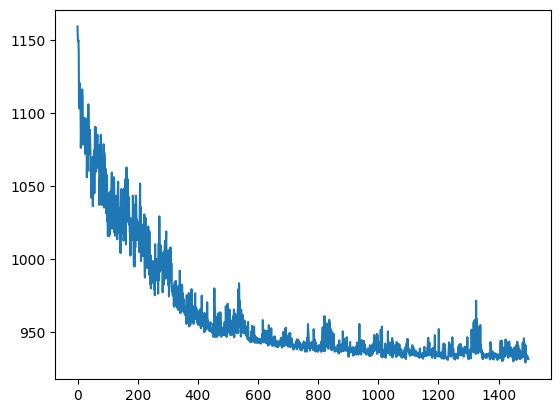

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 7.3477e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.1149e-05,  9.3132e-01],
         [ 5.2429e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           4.3653e-05,  1.6428e-02],
         [ 5.7622e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.1299e-03, -4.2007e-03],
         ...,
         [ 5.2430e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.2853e-01,  4.5872e-19],
         [ 5.9307e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -1.3126e-02, -4.9045e-20],
         [ 3.2878e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.2696e-03,  4.7484e-21]],

        [[ 5.7018e-02,  0.0000e+00, -1.1793e-03,  ...,  1.0031e-14,
          -2.7449e-05, -5.3623e-25],
         [ 9.5788e-02,  0.0000e+00,  6.8257e-02,  ..., -5.6948e-13,
           1.5583e-03,  3.0442e-23],
         [ 5.4906e-02,  0.0000e+00,  9.2840e-01,  ...,  1.4214e-12,
          -3.8895e-03, -7.5983e-23],
         ...,
         [ 5.4710e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



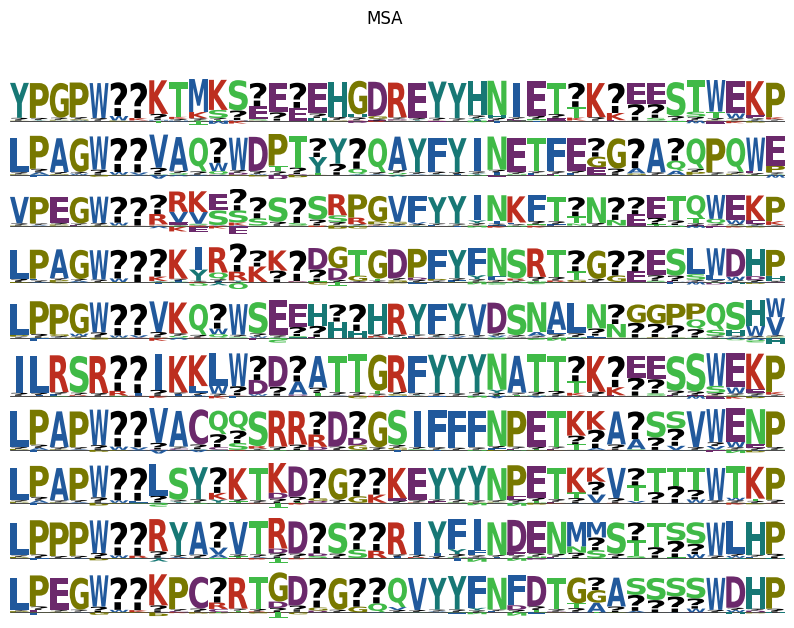

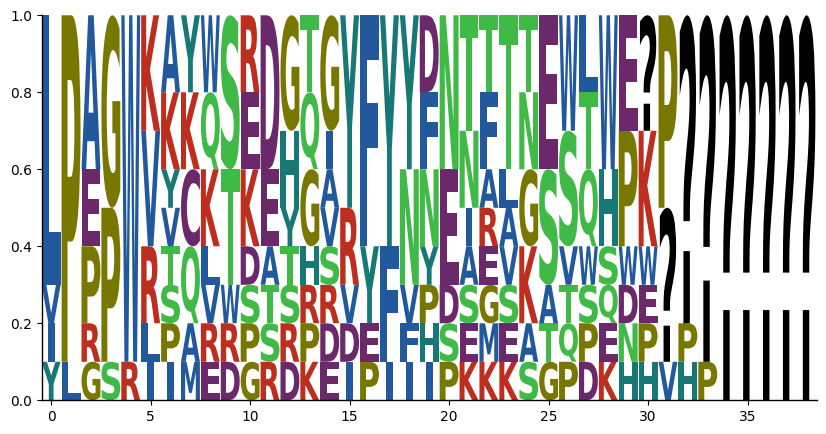

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



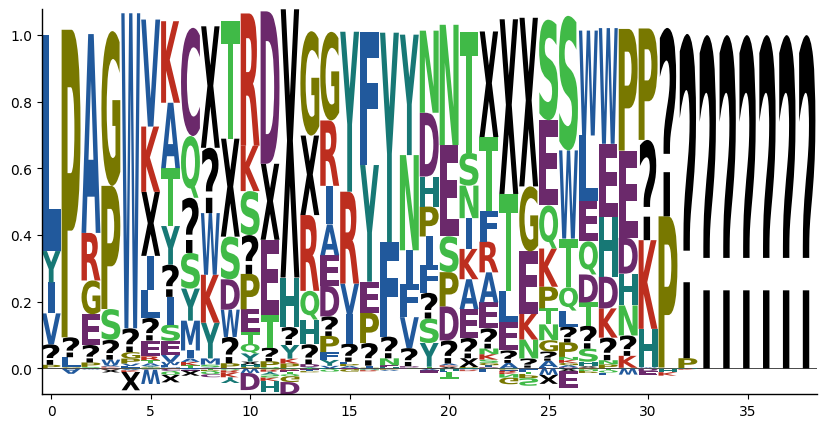

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



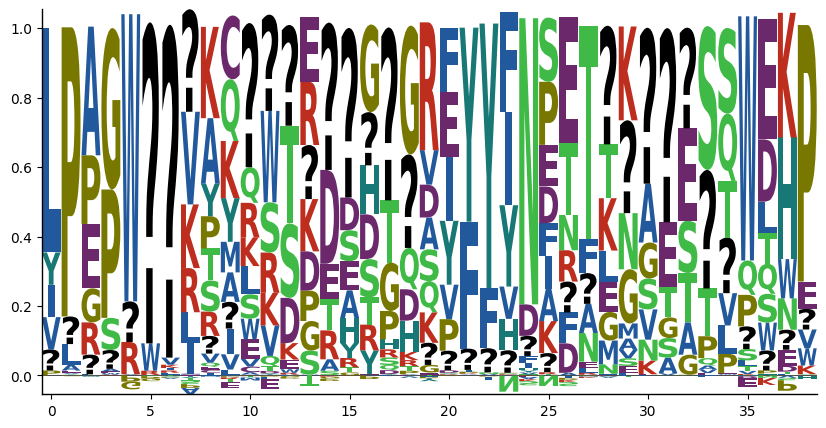

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



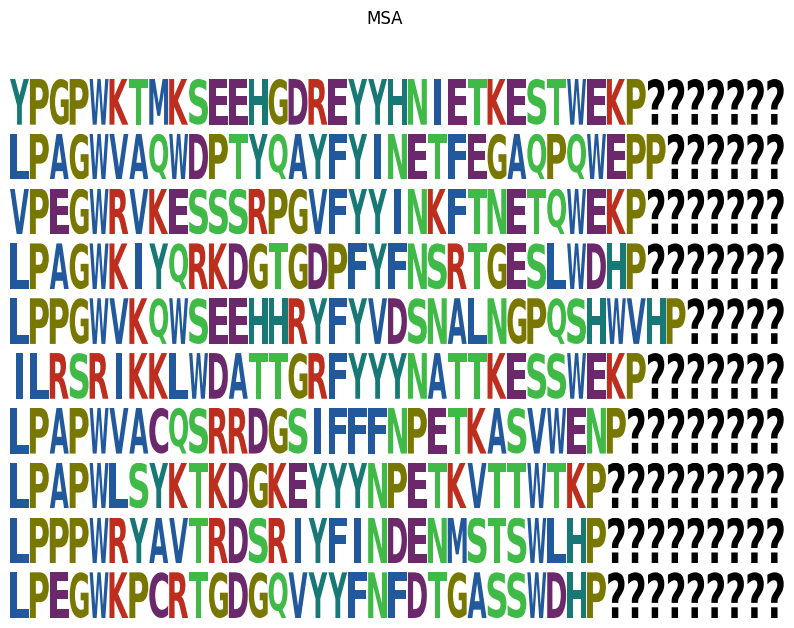

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


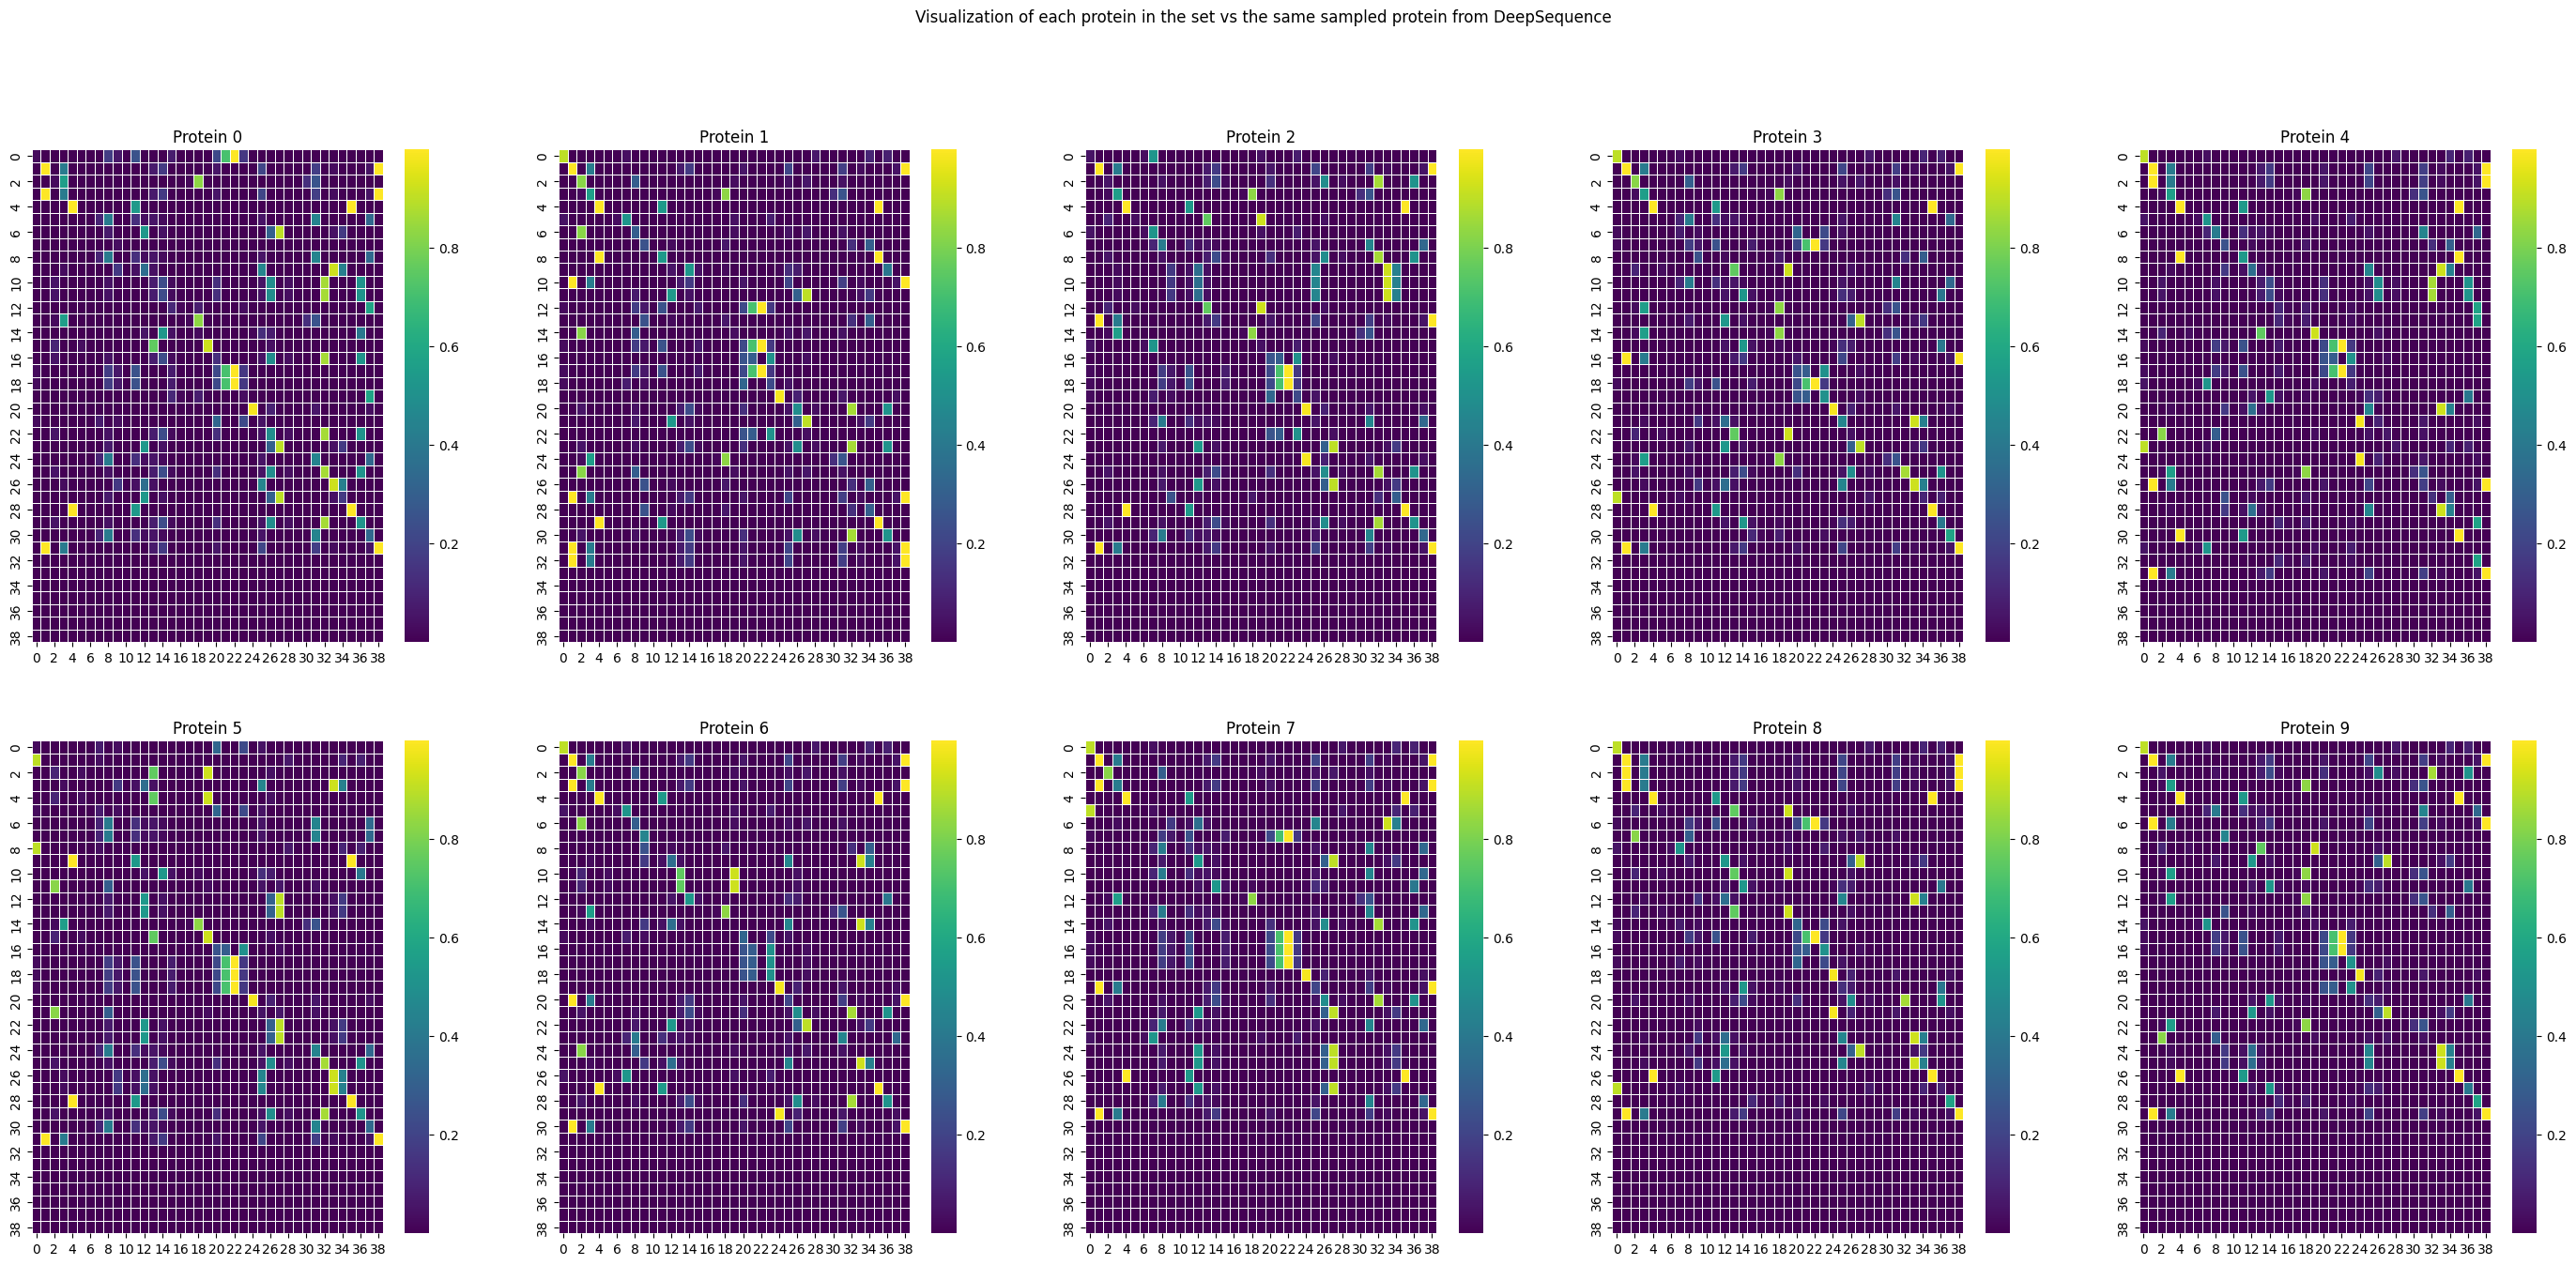

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



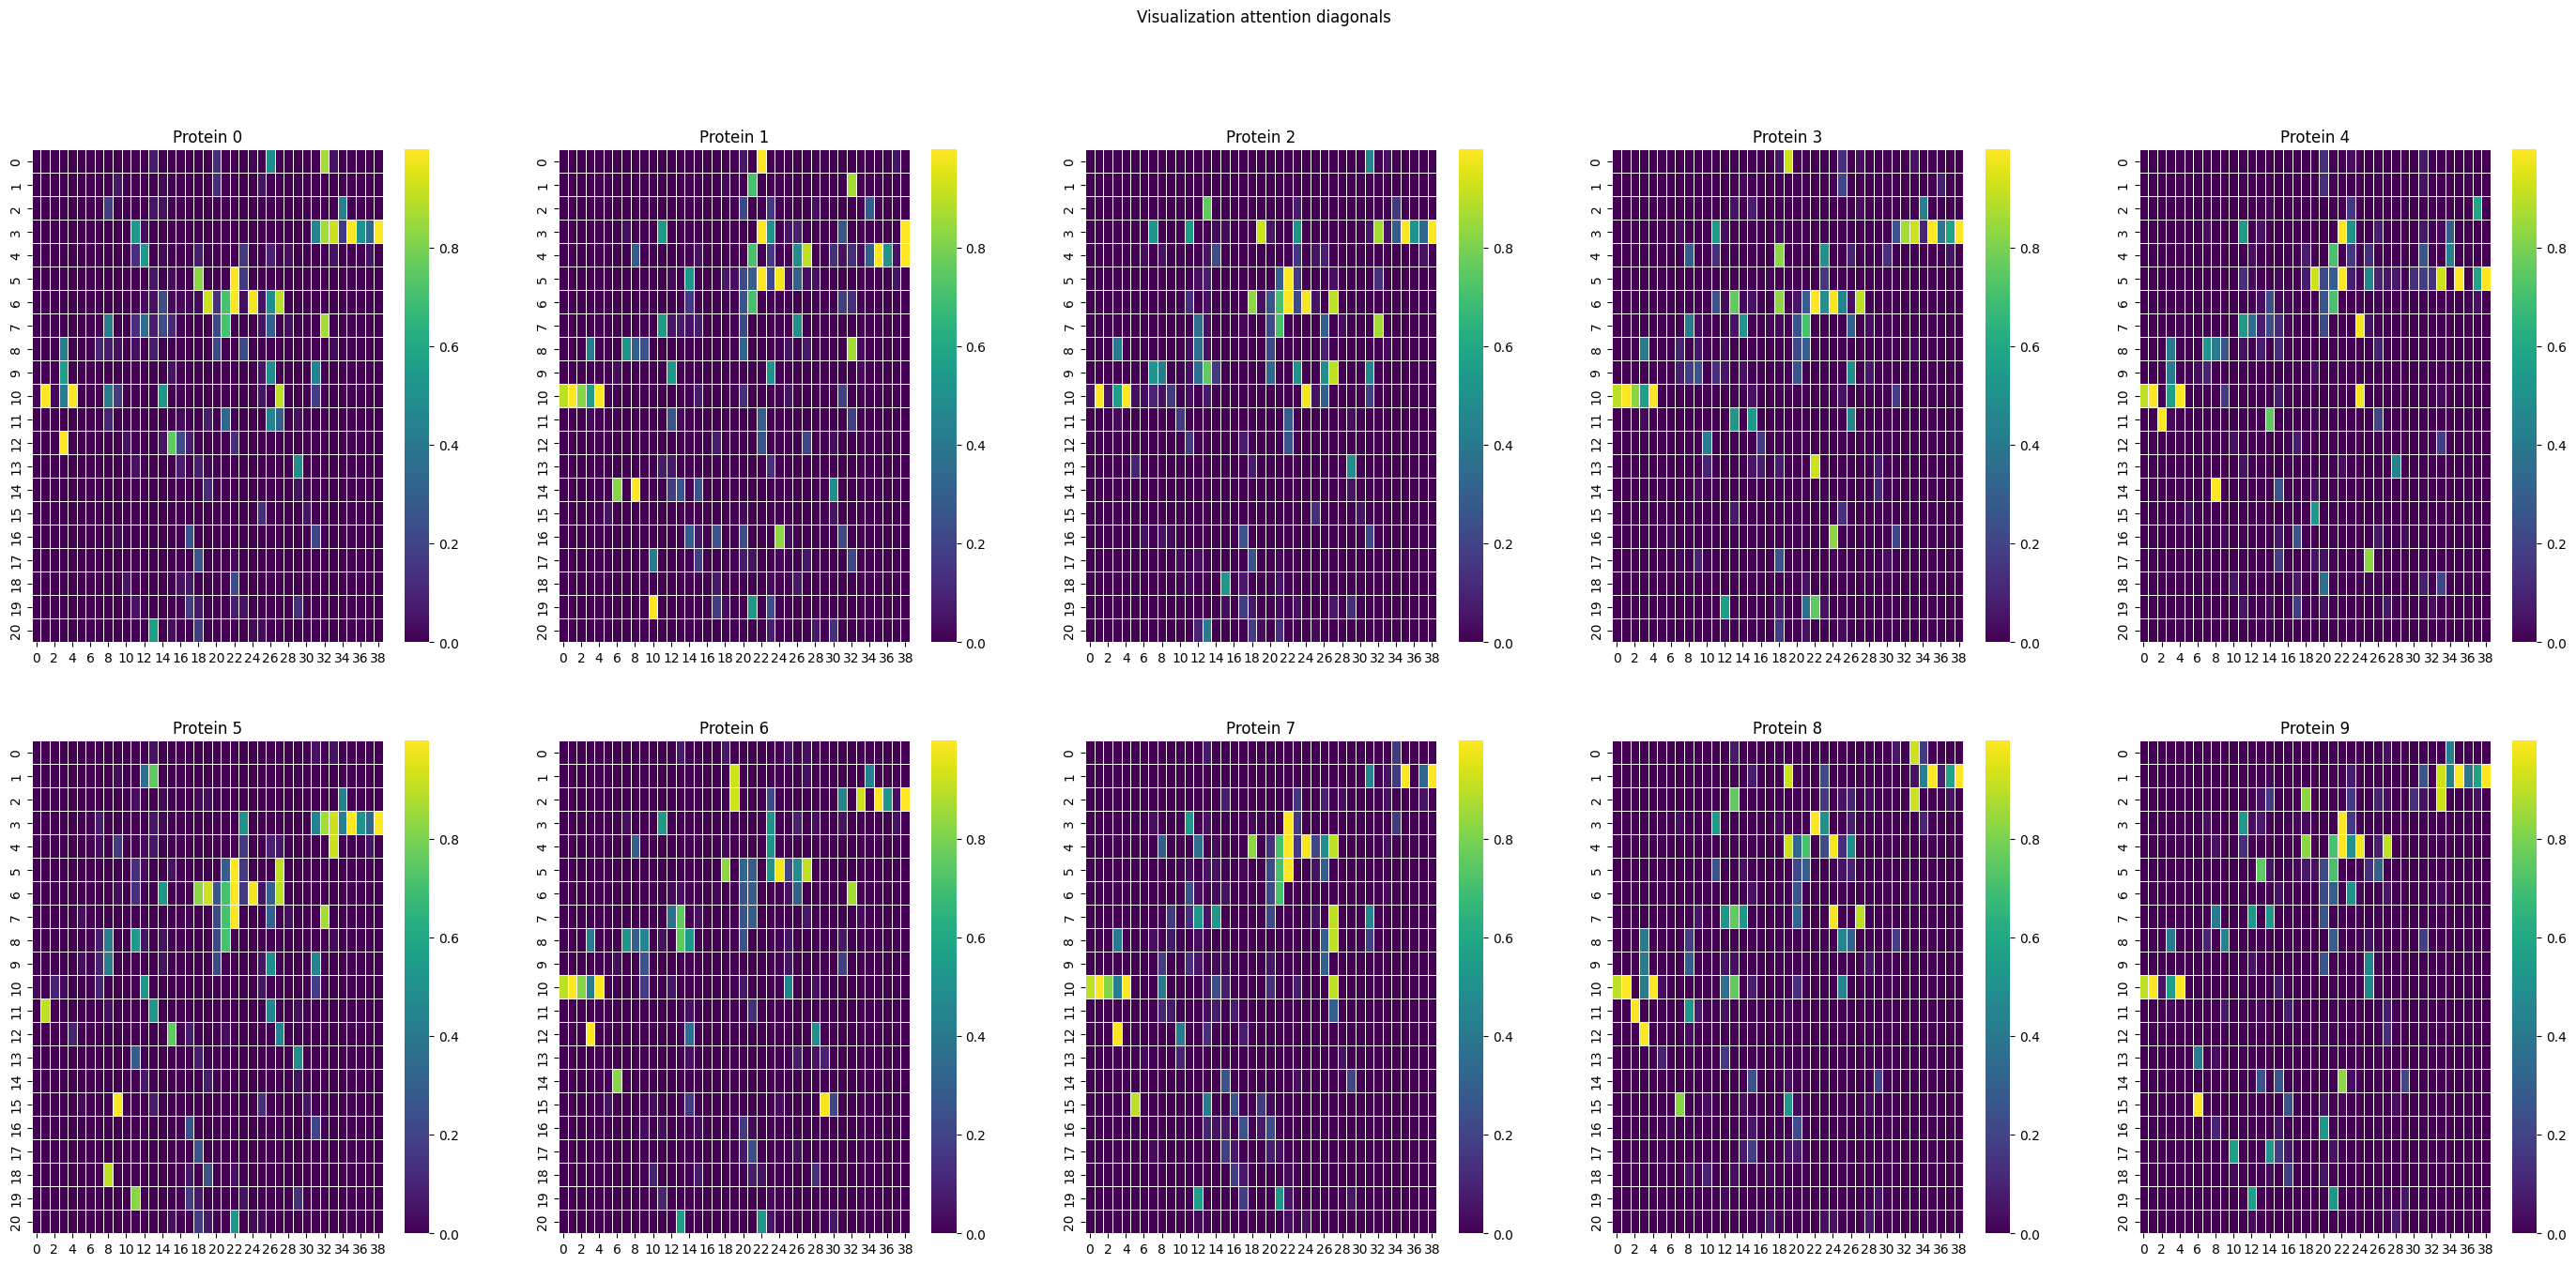

'\nMatrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])\nlist_attention = []\nget_diagonal_attention(Matrix, 2, -2, 2, list_attention)\n\nMatrix2 = Matrix.repeat(2,1,1)\nget_batch_diagonal_attention(Matrix2, 2, -2, 2)\n\nprint(list_attention)\n'

In [14]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

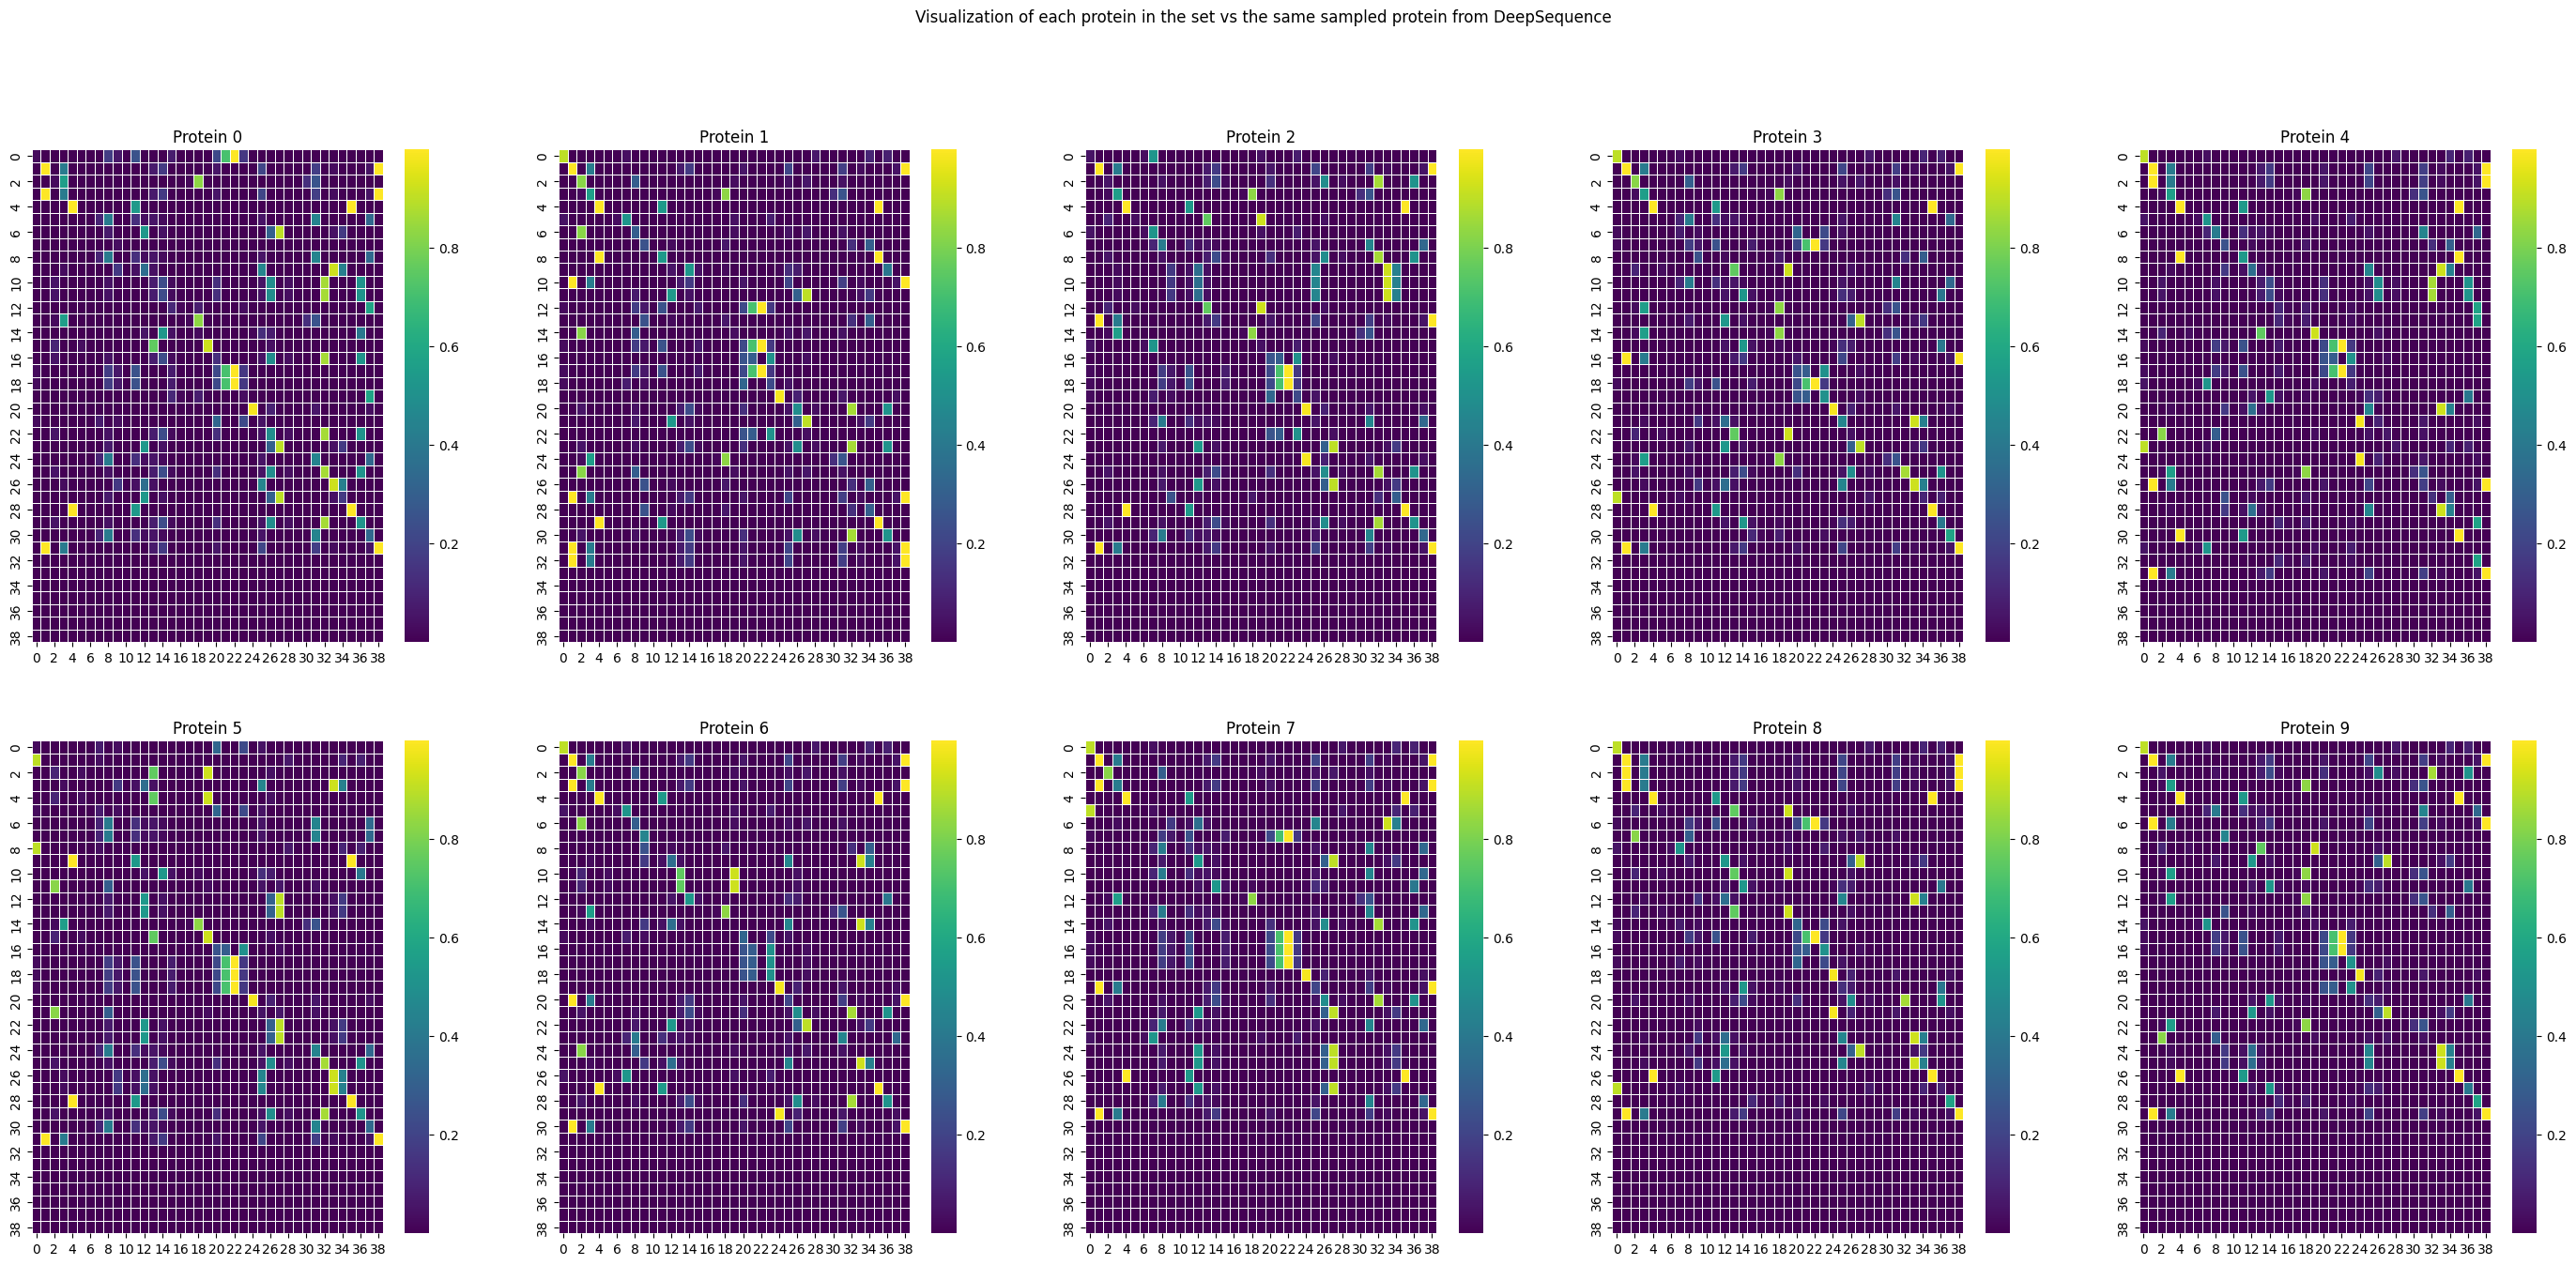

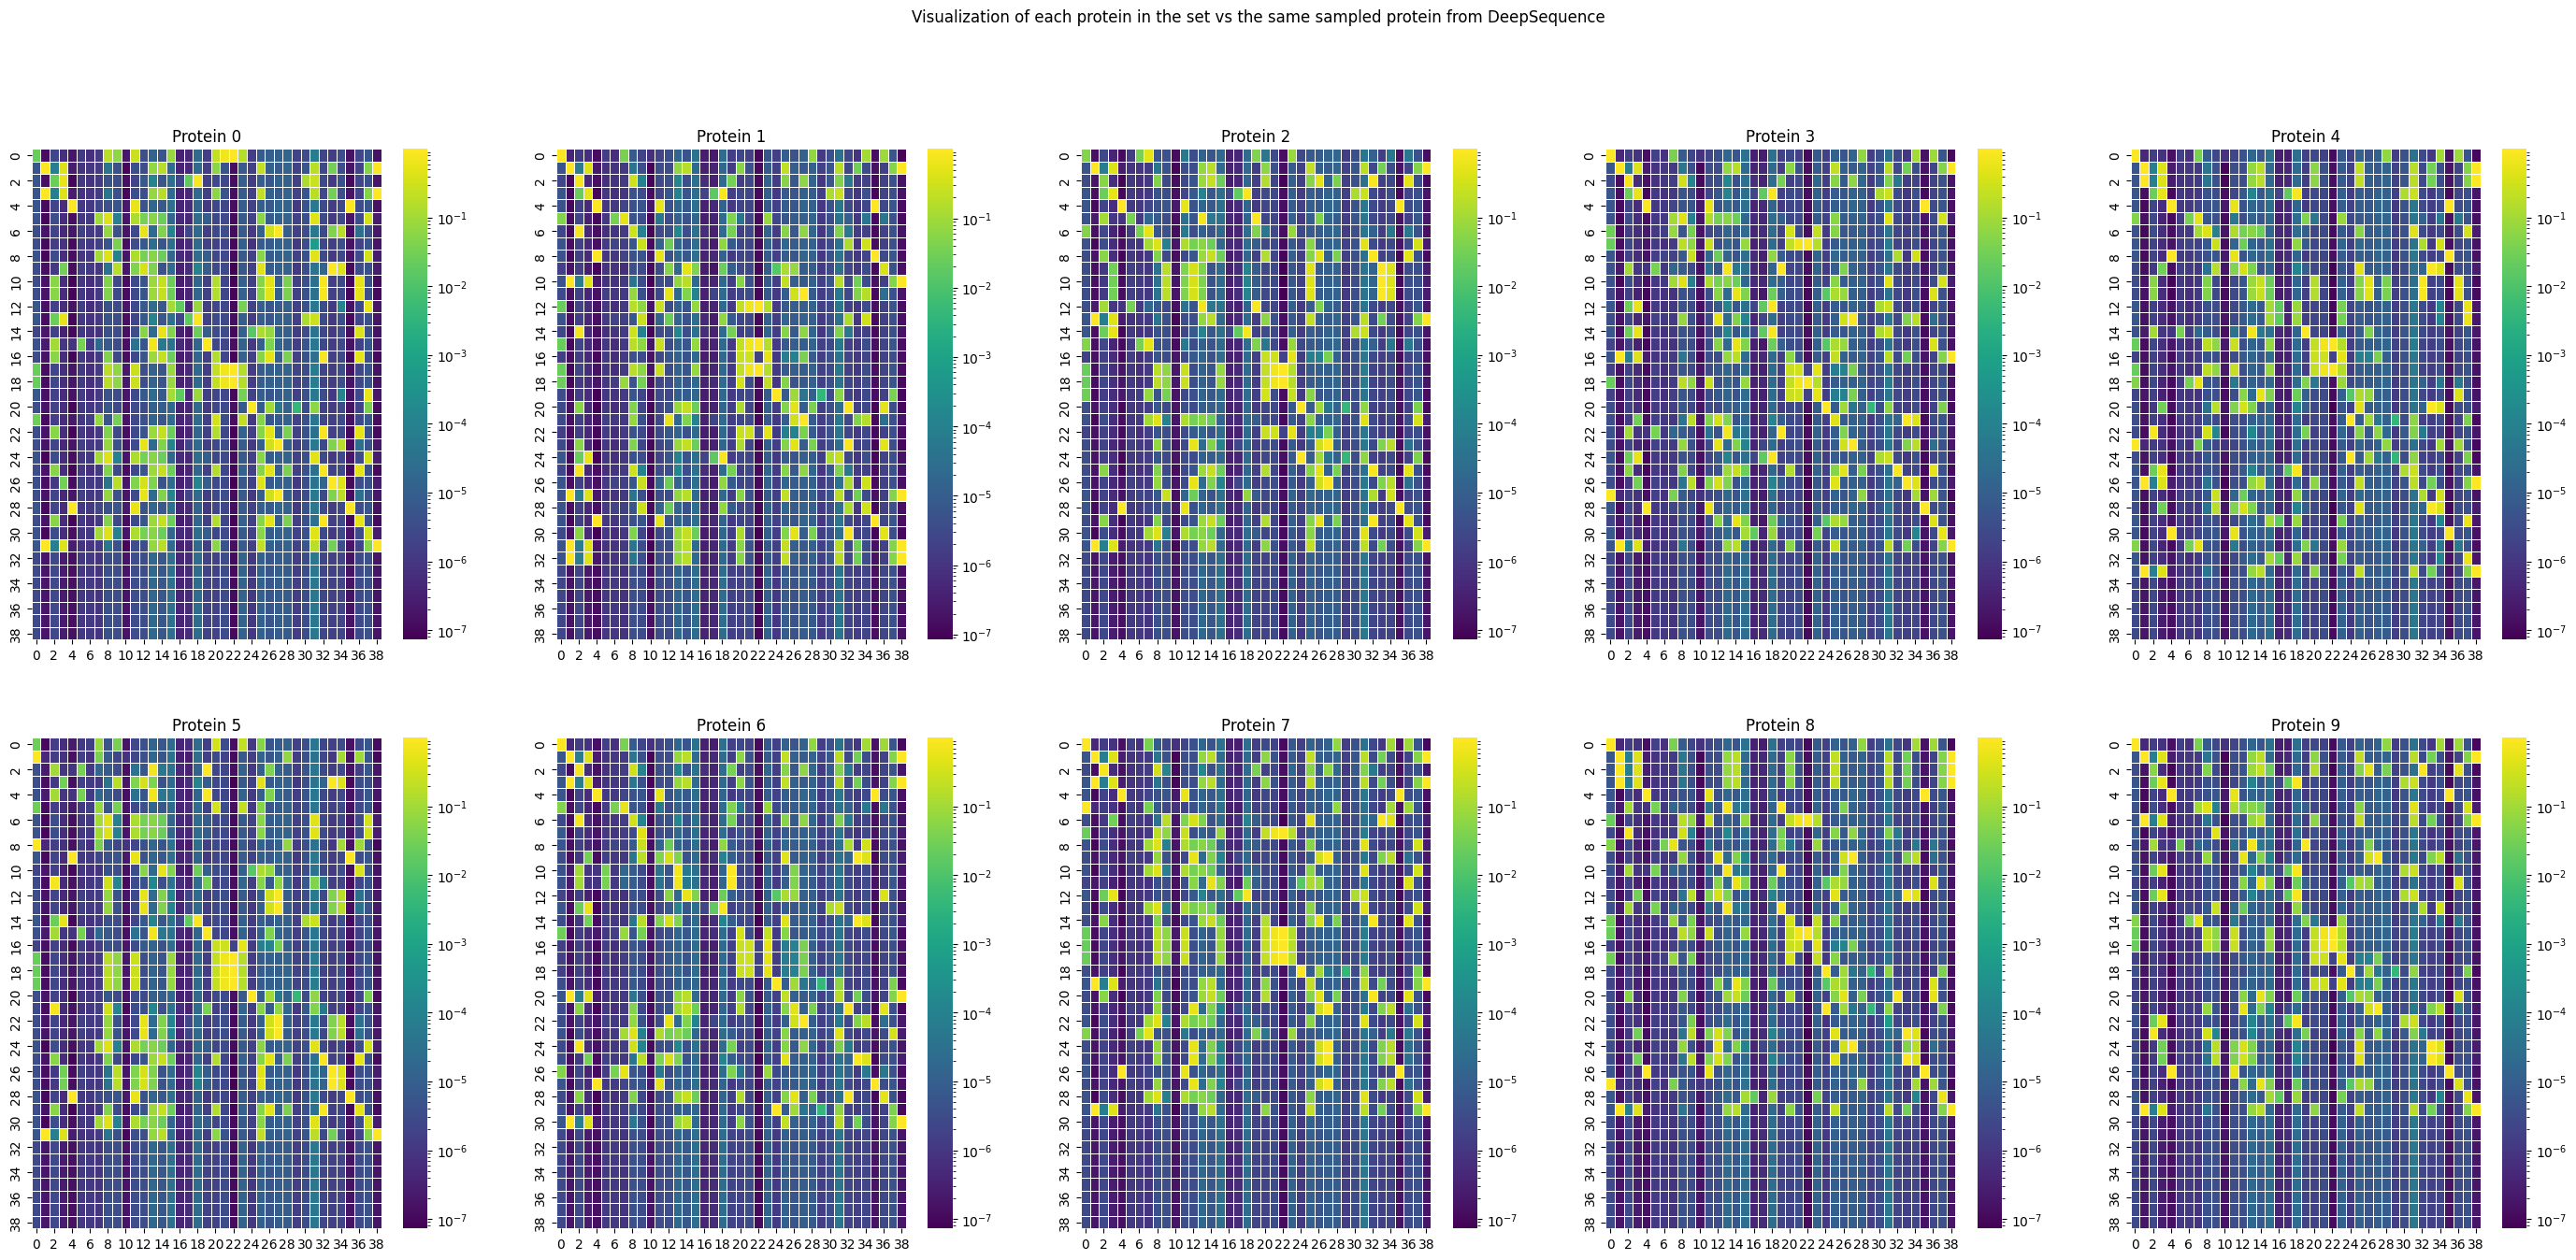

In [15]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()